AUTHOR: haro_cyber

DATE: 2021/2/5

#発展問題4(DCGAN)
次のデータを使ってポケモンを生成させよ。
 https://www.kaggle.com/vishalsubbiah/pokemon-images-and-types
 
 前回DCGANを使用したため、今回はPGGAN（Progressive Growing of GANs）を活用する。

 なお、論文のコードを直接使わないので、PGGANのコンセプトを見よう見まねで再現実装してみた。そのため実際のPGGANとは少々違うかもしれない。

まとめや考察は最下部に記載。


In [ ]:
!nvidia-smi

Tue Feb  2 11:48:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

##データの準備

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import glob


#ディレクトリ名などは適切に書き換える
files = glob.glob("/content/drive/MyDrive/DataFiles/pokemon/pokemon_dataset/images/images/*")   #GOODフォルダを使用する場合

#picフォルダの後のアスタリスクがポイント
#ここでfilesにフォルダ内のファイル名が代入される

x_train_1 = np.empty((0,8,8,3),dtype='uint8')
#size = (8,8)

x_train_2 = np.empty((0,16,16,3),dtype='uint8')
#size = (16,16)

x_train_3 = np.empty((0,32,32,3),dtype='uint8')
#size = (32,32)

x_train = np.empty((0,64,64,3),dtype='uint8')
#size = (64,64)

for fname in files:    #あとはForで1ファイルずつ実行されていく
  img = cv2.imread(fname)  
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (64,64))  #解像度を下げる
  x_train = np.append(x_train,[img],axis=0)
  img = cv2.resize(img, (32,32))
  x_train_3 = np.append(x_train_3,[img],axis=0)
  img = cv2.resize(img, (16,16))
  x_train_2 = np.append(x_train_2,[img],axis=0)
  img = cv2.resize(img, (8,8))
  x_train_1 = np.append(x_train_1,[img],axis=0)

print(x_train_1.shape)  #画像の枚数と形の確認　　（枚数,縦,横,色）
print(x_train_2.shape)  #画像の枚数と形の確認　　（枚数,縦,横,色）
print(x_train_3.shape)  #画像の枚数と形の確認　　（枚数,縦,横,色）
print(x_train.shape)  #画像の枚数と形の確認　　（枚数,縦,横,色）

(809, 8, 8, 3)
(809, 16, 16, 3)
(809, 32, 32, 3)
(809, 64, 64, 3)


In [ ]:
# チャネル次元の追加
# x_train = x_train[:,:,:,np.newaxis]　すでにカラー画像

# [-1,1]へスケール
x_train = x_train/127.5 - 1
x_train_1 = x_train_1/127.5 - 1
x_train_2 = x_train_2/127.5 - 1
x_train_3 = x_train_3/127.5 - 1

# axis=2の軸（垂直軸）に沿って左右に画像をひっくり返したものもデータに加えて二倍にする
# Nの方向に加えるので、axis=0方向にconcatenateする
x_train = np.concatenate([x_train, x_train[:,:,::-1,:]], axis=0)
x_train_1 = np.concatenate([x_train_1, x_train_1[:,:,::-1,:]], axis=0)
x_train_2 = np.concatenate([x_train_2, x_train_2[:,:,::-1,:]], axis=0)
x_train_3 = np.concatenate([x_train_3, x_train_3[:,:,::-1,:]], axis=0)

# 並び順をシャッフル
np.random.seed(32)
np.random.shuffle(x_train)
np.random.seed(32)
np.random.shuffle(x_train_1)
np.random.seed(32)
np.random.shuffle(x_train_2)
np.random.seed(32)
np.random.shuffle(x_train_3)


print('shape of x_train_1', x_train_1.shape)
print('shape of x_train_2', x_train_2.shape)
print('shape of x_train_3', x_train_3.shape)
print('shape of x_train', x_train.shape)

shape of x_train_1 (1618, 8, 8, 3)
shape of x_train_2 (1618, 16, 16, 3)
shape of x_train_3 (1618, 32, 32, 3)
shape of x_train (1618, 64, 64, 3)


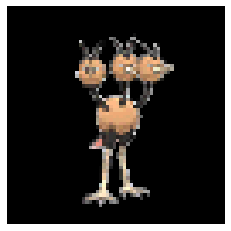

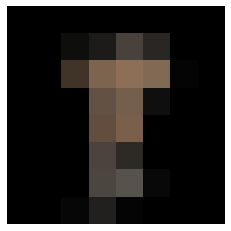

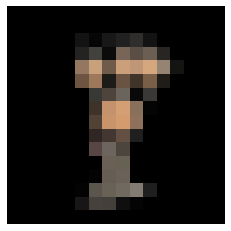

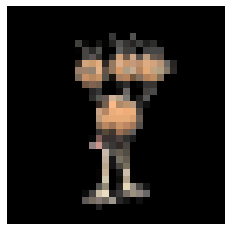

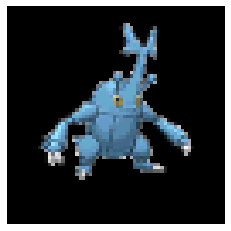

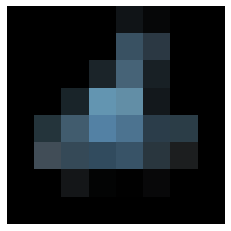

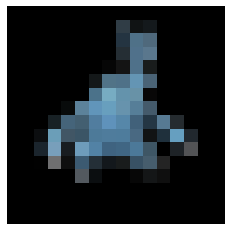

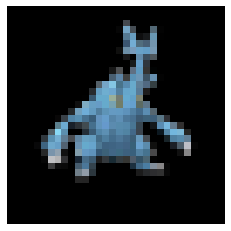

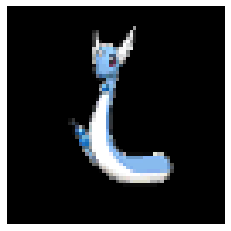

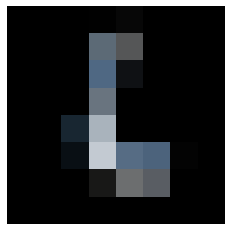

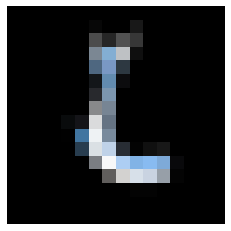

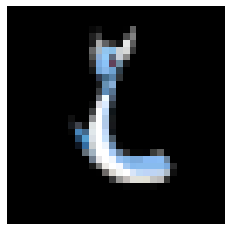

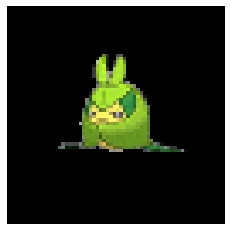

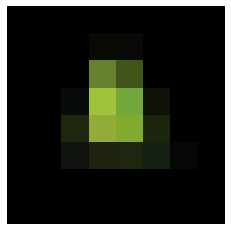

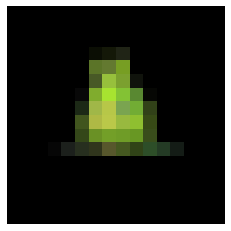

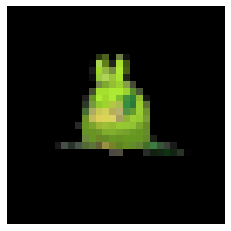

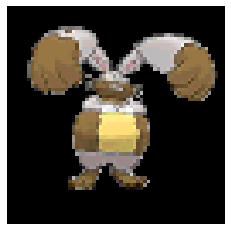

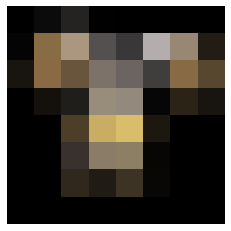

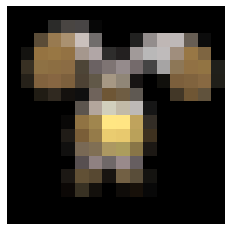

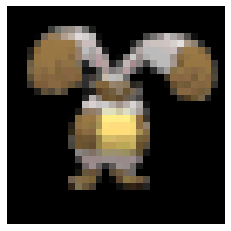

In [ ]:
for i in range(5):
    plt.imshow((x_train[i,:,:,:]+1)/2)
    plt.axis("off")
    plt.show()
    plt.imshow((x_train_1[i,:,:,:]+1)/2)
    plt.axis("off")
    plt.show()
    plt.imshow((x_train_2[i,:,:,:]+1)/2)
    plt.axis("off")
    plt.show()
    plt.imshow((x_train_3[i,:,:,:]+1)/2)
    plt.axis("off")
    plt.show()

##モデルの用意

##PGGAN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, Input
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

元論文：

https://arxiv.org/pdf/1710.10196.pdf

Github:

https://github.com/tkarras/progressive_growing_of_gans/blob/master/networks.py

解説：

http://www.thothchildren.com/chapter/5b3e27ba103f2f31687077c8


共有レイヤーについては以下サイトを参考に。

https://blog.shikoan.com/keras-change-inputs-on-shared-layer/

基本的なGeneratorとDiscriminatorの構造は瀧先生コードを参考に。

In [ ]:
latent_dim=100


#Generator
n_nodes = 512 * 4 * 4

#共有レイヤー
g_dense = Dense(n_nodes)
g_convt_1 = Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same')
g_convt_2 = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same')
g_convt_3 = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')
g_convt_4 = Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same')


#Generator model No.1
x_in = Input(shape=(latent_dim))
x = g_dense(x_in)
x = Activation('relu')(x)
x = Reshape((4, 4, 512))(x)
x = g_convt_1(x)
x = Activation('relu')(x)
x = Conv2D(3,(1,1),padding='same')(x)
x_out = Activation('tanh')(x)
g_1 = Model(inputs=x_in, outputs=x_out)
#Generator model No.2
x_in = Input(shape=(latent_dim))
x = g_dense(x_in)
x = Activation('relu')(x)
x = Reshape((4, 4, 512))(x)
x = g_convt_1(x)
x = Activation('relu')(x)
x = g_convt_2(x)
x = Activation('relu')(x)
x = Conv2D(3,(1,1),padding='same')(x)
x_out = Activation('tanh')(x)
g_2 = Model(inputs=x_in, outputs=x_out)
#Generator model No.3
x_in = Input(shape=(latent_dim))
x = g_dense(x_in)
x = Activation('relu')(x)
x = Reshape((4, 4, 512))(x)
x = g_convt_1(x)
x = Activation('relu')(x)
x = g_convt_2(x)
x = Activation('relu')(x)
x = g_convt_3(x)
x = Activation('relu')(x)
x = Conv2D(3,(1,1),padding='same')(x)
x_out = Activation('tanh')(x)
g_3 = Model(inputs=x_in, outputs=x_out)
#Generator model No.4
x_in = Input(shape=(latent_dim))
x = g_dense(x_in)
x = Activation('relu')(x)
x = Reshape((4, 4, 512))(x)
x = g_convt_1(x)
x = Activation('relu')(x)
x = g_convt_2(x)
x = Activation('relu')(x)
x = g_convt_3(x)
x = Activation('relu')(x)
x = g_convt_4(x)
x_out = Activation('tanh')(x)
g_4 = Model(inputs=x_in, outputs=x_out)

In [ ]:
g_1.summary()
g_2.summary()
g_3.summary()
g_4.summary()


#discriminator.summary()
#gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 8192)              827392    
_________________________________________________________________
activation (Activation)      (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         3277056   
_________________________________________________________________
activation_1 (Activation)    (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 3)           771   

In [ ]:
# discriminator ４つ

#d_1
d_1 = Sequential()
d_1.add(Conv2D(64, (5,5), padding='same', input_shape=(8,8,3)))
d_1.add(LeakyReLU(alpha=0.2))
d_1.add(Flatten())
d_1.add(Dropout(0.4))
d_1.add(Dense(1, activation='sigmoid'))

#d_2
d_2 = Sequential()
d_2.add(Conv2D(64, (5,5), padding='same', input_shape=(16,16,3)))
d_2.add(LeakyReLU(alpha=0.2))
d_2.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
d_2.add(LeakyReLU(alpha=0.2))
d_2.add(Flatten())
d_2.add(Dropout(0.4))
d_2.add(Dense(1, activation='sigmoid'))

#d_3
d_3 = Sequential()
d_3.add(Conv2D(64, (5,5), padding='same', input_shape=(32,32,3)))
d_3.add(LeakyReLU(alpha=0.2))
d_3.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
d_3.add(LeakyReLU(alpha=0.2))
d_3.add(Conv2D(256, (5,5), strides=(2,2), padding='same'))
d_3.add(LeakyReLU(alpha=0.2))
d_3.add(Flatten())
d_3.add(Dropout(0.4))
d_3.add(Dense(1, activation='sigmoid'))

#d_4
d_4 = Sequential()
d_4.add(Conv2D(64, (5,5), padding='same', input_shape=(64,64,3)))
d_4.add(LeakyReLU(alpha=0.2))
d_4.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
d_4.add(LeakyReLU(alpha=0.2))
d_4.add(Conv2D(256, (5,5), strides=(2,2), padding='same'))
d_4.add(LeakyReLU(alpha=0.2))
d_4.add(Conv2D(512, (5,5), strides=(2,2), padding='same'))
d_4.add(LeakyReLU(alpha=0.2))
d_4.add(Flatten())
d_4.add(Dropout(0.4))
d_4.add(Dense(1, activation='sigmoid'))

In [ ]:
d_1.summary()
d_2.summary()
d_3.summary()
d_4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 8, 8, 64)          4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4097      
Total params: 8,961
Trainable params: 8,961
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Out

In [ ]:
# コンパイル

opt = Adam(lr=0.0002, beta_1=0.5)

d_1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
d_1.trainable = False
d_2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
d_2.trainable = False
d_3.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
d_3.trainable = False
d_4.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
d_4.trainable = False

gan_1 = Sequential()
gan_1.add(g_1)
gan_1.add(d_1)
gan_1.compile(loss='binary_crossentropy', optimizer=opt)

gan_2 = Sequential()
gan_2.add(g_2)
gan_2.add(d_2)
gan_2.compile(loss='binary_crossentropy', optimizer=opt)

gan_3 = Sequential()
gan_3.add(g_3)
gan_3.add(d_3)
gan_3.compile(loss='binary_crossentropy', optimizer=opt)

gan_4 = Sequential()
gan_4.add(g_4)
gan_4.add(d_4)
gan_4.compile(loss='binary_crossentropy', optimizer=opt)

In [ ]:
gan_1.summary()
gan_2.summary()
gan_3.summary()
gan_4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 8, 8, 3)           4105219   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 8961      
Total params: 4,114,180
Trainable params: 4,105,219
Non-trainable params: 8,961
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 16, 16, 3)         4924163   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 217985    
Total params: 5,142,148
Trainable params: 4,924,163
Non-trainable params: 217,985
_________________________________________________________________
Mo

##訓練

In [ ]:
z_val =  np.random.randn(latent_dim)
z_val = z_val.reshape((1, latent_dim))

d_history = []
g_history = []
d_history_1 = []
g_history_1 = []
d_history_2 = []
g_history_2 = []
d_history_3 = []
g_history_3 = []

def train(x_train, n_epochs=200, n_batch=128):

    bat_per_epoch = int(x_train.shape[0] // n_batch)
    y_real = np.ones((n_batch,))
    y_fake = np.zeros((n_batch,))

    for i in range(n_epochs):
        
        for j in range(bat_per_epoch):

            # Dの訓練をreal、fakeの二段階に分けて実装。この方がうまくいきやすい。
            x_batch = x_train[j*n_batch:(j+1)*n_batch,:]
            x_batch_1 = x_train_1[j*n_batch:(j+1)*n_batch,:]
            x_batch_2 = x_train_2[j*n_batch:(j+1)*n_batch,:]
            x_batch_3 = x_train_3[j*n_batch:(j+1)*n_batch,:]

            ## (8,8,3)
            d_loss_real, _ = d_1.train_on_batch(x_batch_1, y_real)

            z = np.random.randn(n_batch*latent_dim)
            z = z.reshape((n_batch, latent_dim))
            x_fake = g_1.predict(z)
            d_loss_fake, _ = d_1.train_on_batch(x_fake, y_fake)

            # realとfakeのlossの平均値でDのlossを定義
            d_loss = (d_loss_real + d_loss_fake)/2
            d_history_1.append(d_loss)

            # Gの訓練
            z = np.random.randn(n_batch*latent_dim)
            z = z.reshape((n_batch, latent_dim))

            g_loss = gan_1.train_on_batch(z, y_real)
            g_history_1.append(g_loss)

            ##(16,16,3)
            d_loss_real, _ = d_2.train_on_batch(x_batch_2, y_real)

            z = np.random.randn(n_batch*latent_dim)
            z = z.reshape((n_batch, latent_dim))
            x_fake = g_2.predict(z)
            d_loss_fake, _ = d_2.train_on_batch(x_fake, y_fake)

            # realとfakeのlossの平均値でDのlossを定義
            d_loss = (d_loss_real + d_loss_fake)/2
            d_history_2.append(d_loss)

            # Gの訓練
            z = np.random.randn(n_batch*latent_dim)
            z = z.reshape((n_batch, latent_dim))

            g_loss = gan_2.train_on_batch(z, y_real)
            g_history_2.append(g_loss)

            ##(32,32,3)
            d_loss_real, _ = d_3.train_on_batch(x_batch_3, y_real)

            z = np.random.randn(n_batch*latent_dim)
            z = z.reshape((n_batch, latent_dim))
            x_fake = g_3.predict(z)
            d_loss_fake, _ = d_3.train_on_batch(x_fake, y_fake)

            # realとfakeのlossの平均値でDのlossを定義
            d_loss = (d_loss_real + d_loss_fake)/2
            d_history_3.append(d_loss)

            # Gの訓練
            z = np.random.randn(n_batch*latent_dim)
            z = z.reshape((n_batch, latent_dim))

            g_loss = gan_3.train_on_batch(z, y_real)
            g_history_3.append(g_loss)

            ##(64,64,3)
            d_loss_real, _ = d_4.train_on_batch(x_batch, y_real)

            z = np.random.randn(n_batch*latent_dim)
            z = z.reshape((n_batch, latent_dim))
            x_fake = g_4.predict(z)
            d_loss_fake, _ = d_4.train_on_batch(x_fake, y_fake)

            # realとfakeのlossの平均値でDのlossを定義
            d_loss = (d_loss_real + d_loss_fake)/2
            d_history.append(d_loss)

            # Gの訓練
            z = np.random.randn(n_batch*latent_dim)
            z = z.reshape((n_batch, latent_dim))

            g_loss = gan_4.train_on_batch(z, y_real)
            g_history.append(g_loss)

            if j  == 0:
                print('epoch', i)
                print(d_loss, g_loss)
                x_val = g_4.predict(z_val)
                plt.imshow((x_val[0,:,:,:]+1)/2)
                plt.axis("off")
                plt.show()


epoch 0
0.01668840751517564 7.948397159576416


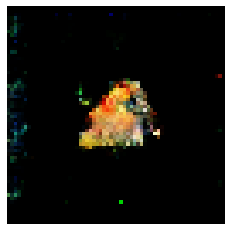

epoch 1
0.03619844454806298 8.67846965789795


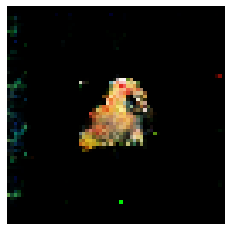

epoch 2
0.04027206636965275 8.821611404418945


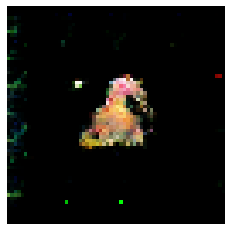

epoch 3
0.012969807256013155 7.922337532043457


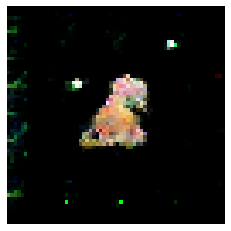

epoch 4
0.054083775728940964 10.2968168258667


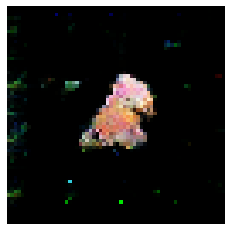

epoch 5
0.09561936929821968 12.71496868133545


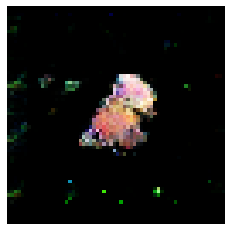

epoch 6
0.050989251874852926 11.776700973510742


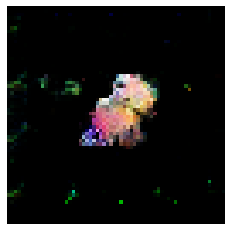

epoch 7
0.02334711980074644 8.671724319458008


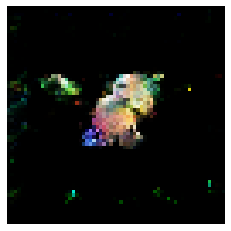

epoch 8
0.05887497105868533 11.007837295532227


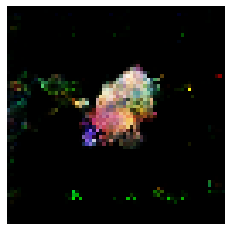

epoch 9
0.029733138766459888 13.190475463867188


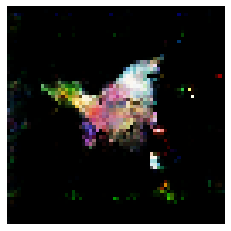

epoch 10
0.01950954459607601 11.603668212890625


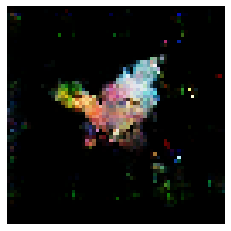

epoch 11
0.04507030267268419 8.905340194702148


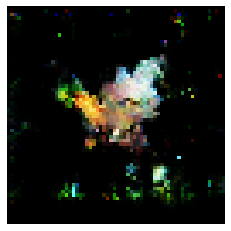

epoch 12
0.010235926136374474 8.44369888305664


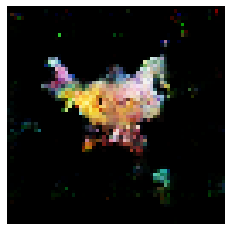

epoch 13
0.0022336243418976665 8.98723030090332


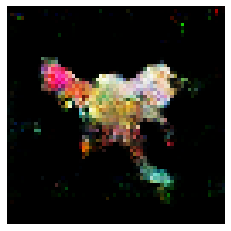

epoch 14
0.004298946470953524 9.369977951049805


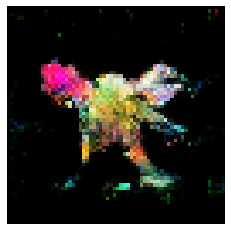

epoch 15
0.007193693658336997 9.36318302154541


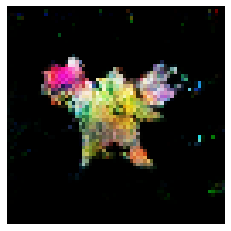

epoch 16
0.004048664588481188 8.904085159301758


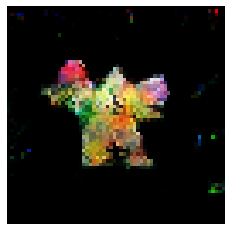

epoch 17
0.014839714393019676 9.777681350708008


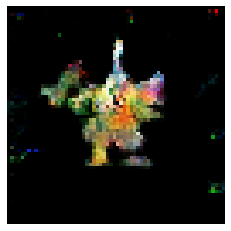

epoch 18
0.039668965502642095 9.28189754486084


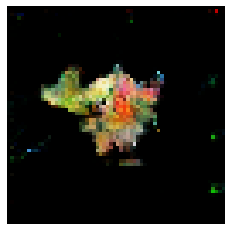

epoch 19
0.011339570861309767 9.822578430175781


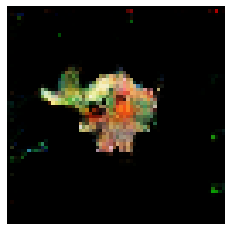

epoch 20
0.015346898697316647 9.067671775817871


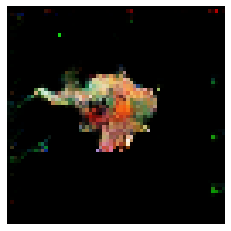

epoch 21
0.07198985107243061 14.59875202178955


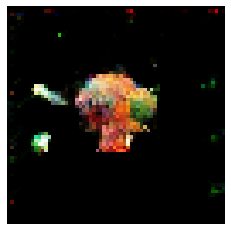

epoch 22
0.021400226280093193 8.775811195373535


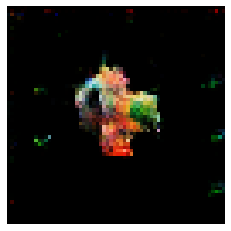

epoch 23
0.03402488166466355 9.11004638671875


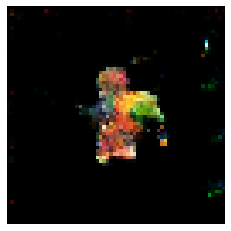

epoch 24
0.003249974106438458 10.21302604675293


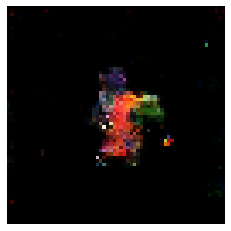

epoch 25
0.013274724944494665 8.989593505859375


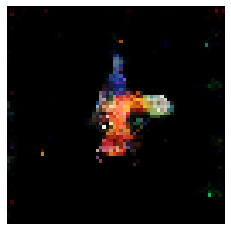

epoch 26
0.014804536709561944 9.837545394897461


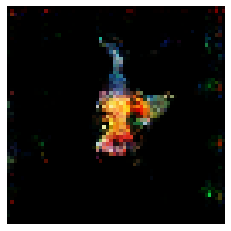

epoch 27
0.009280613157898188 11.055452346801758


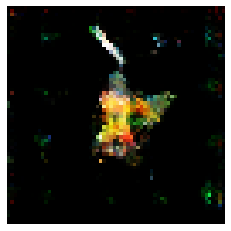

epoch 28
0.02394580518011935 10.4800443649292


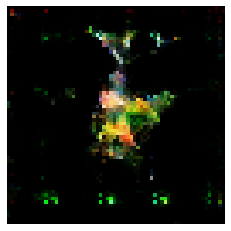

epoch 29
0.01972543983720243 11.313289642333984


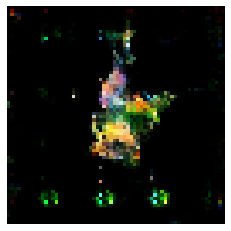

epoch 30
0.02220566663891077 10.891871452331543


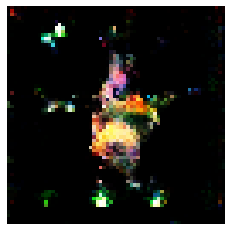

epoch 31
0.020279696211218834 9.464898109436035


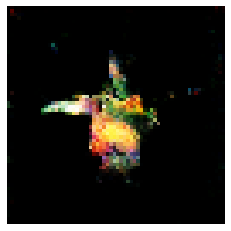

epoch 32
0.0042506573954597116 9.63913345336914


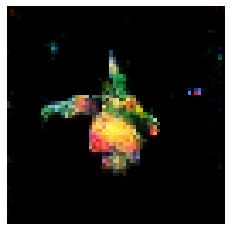

epoch 33
0.07084222510457039 10.729679107666016


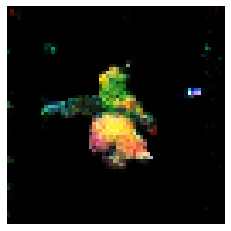

epoch 34
0.04608122259378433 11.577465057373047


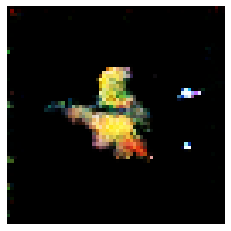

epoch 35
0.022145627066493034 8.602094650268555


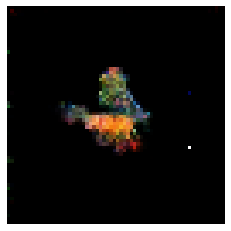

epoch 36
0.00307765175239183 9.420634269714355


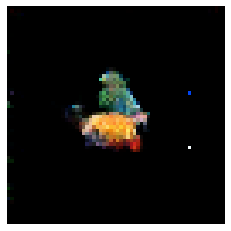

epoch 37
0.009773342870175838 9.470638275146484


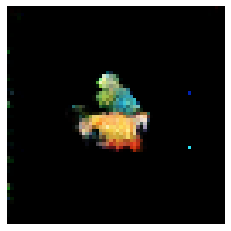

epoch 38
0.00410810491302982 8.957605361938477


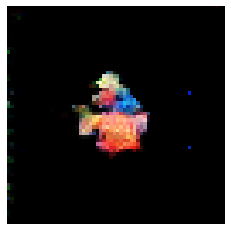

epoch 39
0.006798246875405312 11.063626289367676


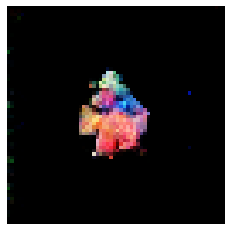

epoch 40
0.017065920401364565 12.201483726501465


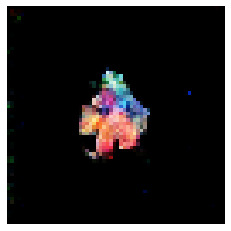

epoch 41
0.007163640111684799 10.016040802001953


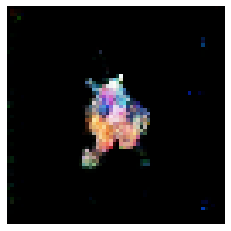

epoch 42
0.010479846154339612 8.840080261230469


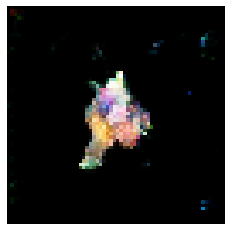

epoch 43
0.025299835484474897 12.034820556640625


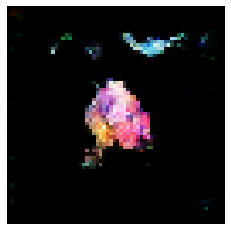

epoch 44
0.013455093139782548 10.344779968261719


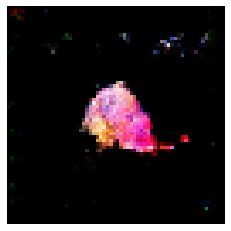

epoch 45
0.02324759226758033 17.202674865722656


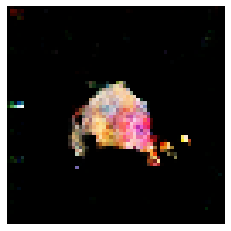

epoch 46
0.005221671191975474 8.86591911315918


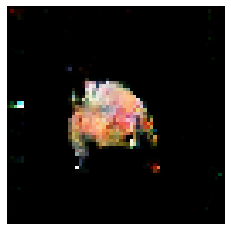

epoch 47
0.01088371779769659 10.107770919799805


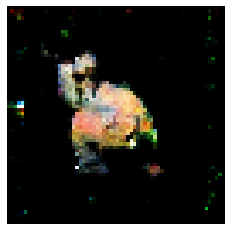

epoch 48
0.014316629618406296 10.297468185424805


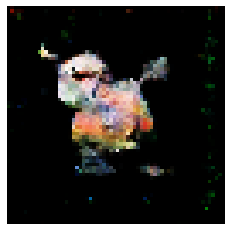

epoch 49
0.014262434095144272 10.41222858428955


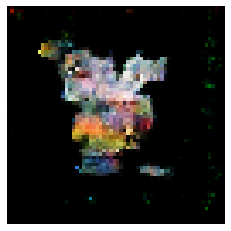

epoch 50
0.02961202821329567 29.208995819091797


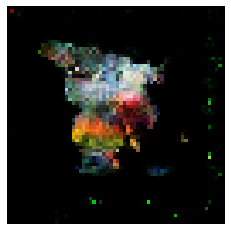

epoch 51
0.17291022837162678 42.71420669555664


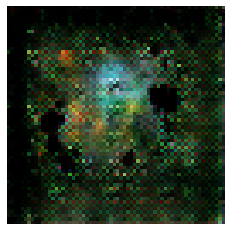

epoch 52
2.1172863095998764 20.148853302001953


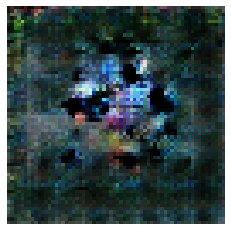

epoch 53
1.919989824295044 19.798107147216797


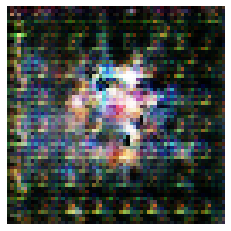

epoch 54
0.5299129486083984 9.864480972290039


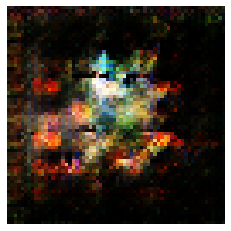

epoch 55
1.7906265041502394 21.96969985961914


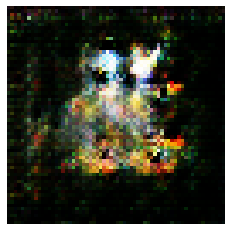

epoch 56
0.3393014222383499 8.800263404846191


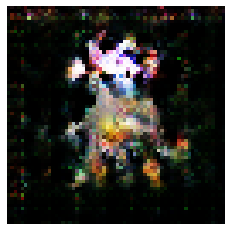

epoch 57
0.2292180471122265 7.858366966247559


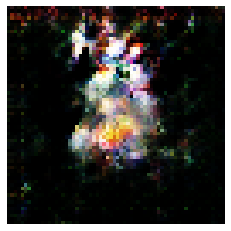

epoch 58
0.3251952826976776 8.540791511535645


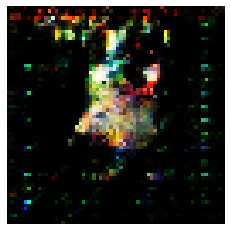

epoch 59
0.21383346896618605 8.908055305480957


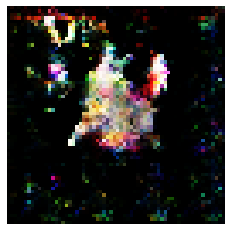

epoch 60
0.30304431822150946 7.317568778991699


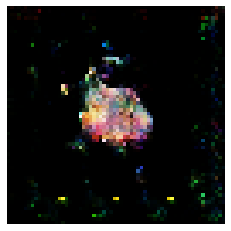

epoch 61
0.17341552674770355 7.034478187561035


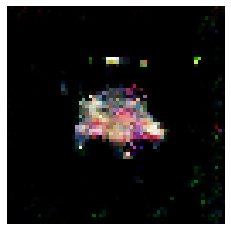

epoch 62
0.33690042793750763 9.993621826171875


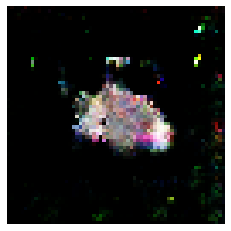

epoch 63
0.06824140250682831 8.512701988220215


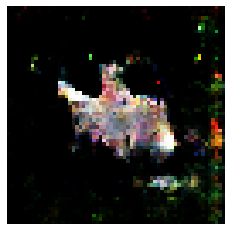

epoch 64
0.161521065980196 7.856671333312988


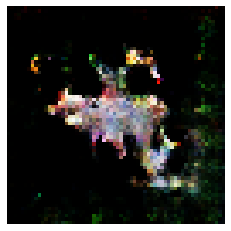

epoch 65
0.27683524787425995 10.129975318908691


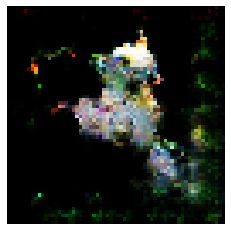

epoch 66
0.03956270590424538 7.005224227905273


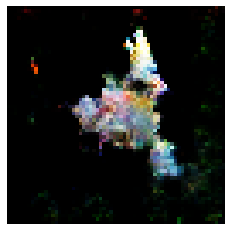

epoch 67
0.023733841255307198 7.42650842666626


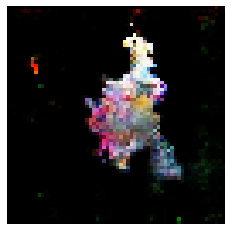

epoch 68
0.10417575389146805 7.988462448120117


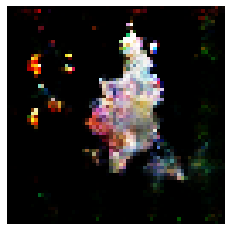

epoch 69
0.11758409067988396 11.589387893676758


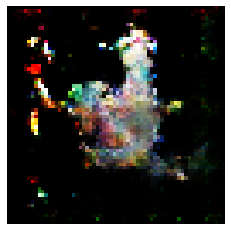

epoch 70
0.028587557841092348 7.136537551879883


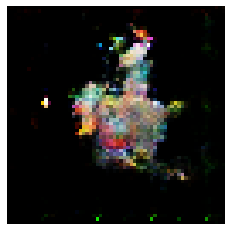

epoch 71
0.06863116472959518 9.109102249145508


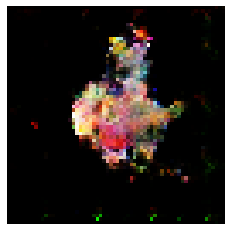

epoch 72
0.006892440840601921 8.755446434020996


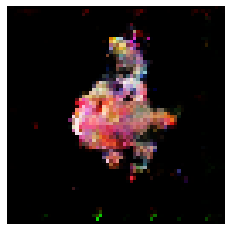

epoch 73
0.032282731495797634 7.525501251220703


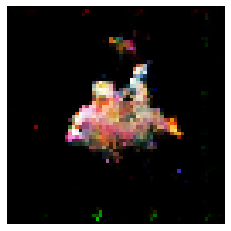

epoch 74
0.15027401596307755 9.433406829833984


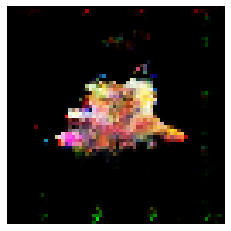

epoch 75
0.147371307015419 8.217950820922852


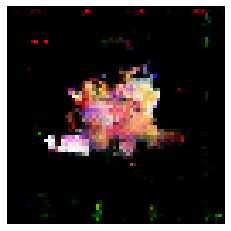

epoch 76
0.07377649657428265 7.8470869064331055


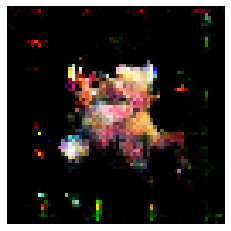

epoch 77
0.11432061344385147 10.42292594909668


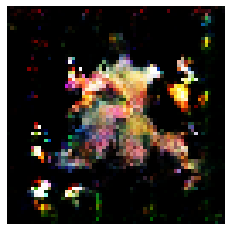

epoch 78
0.022756842896342278 8.044488906860352


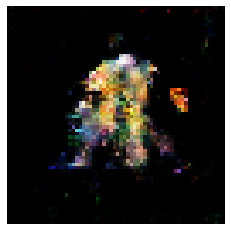

epoch 79
0.033856065943837166 8.817647933959961


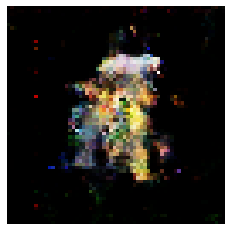

epoch 80
0.07472525909543037 8.863561630249023


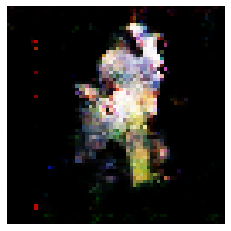

epoch 81
0.06262474367395043 11.064125061035156


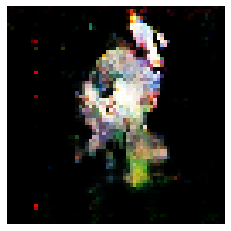

epoch 82
0.01879378780722618 8.420673370361328


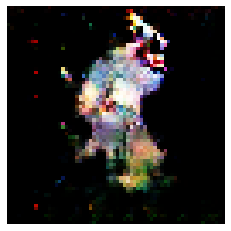

epoch 83
0.030828718096017838 8.783920288085938


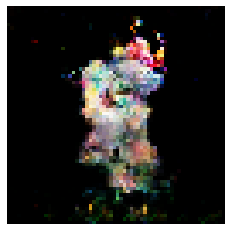

epoch 84
0.03743183519691229 8.190160751342773


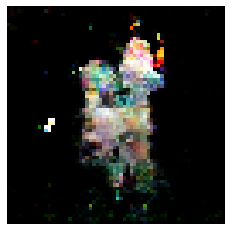

epoch 85
0.06064316304400563 11.102386474609375


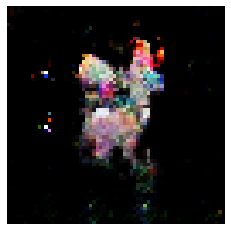

epoch 86
0.07507380656898022 8.167532920837402


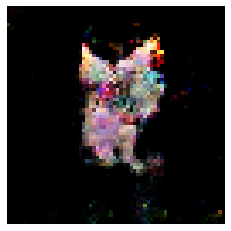

epoch 87
0.04488802840933204 8.884913444519043


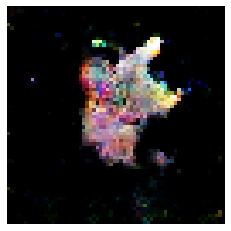

epoch 88
0.02884246688336134 10.029863357543945


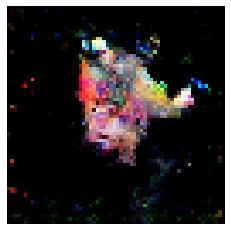

epoch 89
0.06950436159968376 8.99264144897461


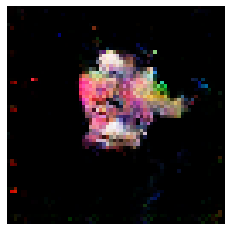

epoch 90
0.038151307962834835 9.539545059204102


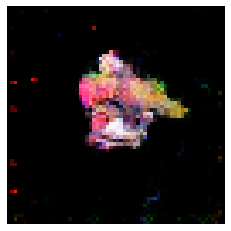

epoch 91
0.05185572151094675 9.009557723999023


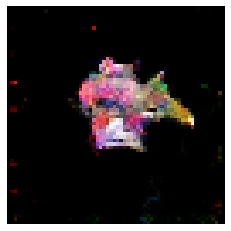

epoch 92
0.014624345116317272 8.489660263061523


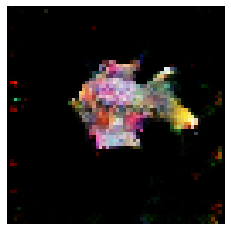

epoch 93
0.03774907812476158 8.239703178405762


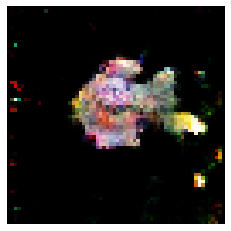

epoch 94
0.03730935603380203 9.378532409667969


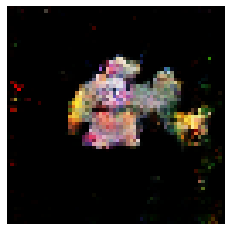

epoch 95
0.030537297949194908 8.097845077514648


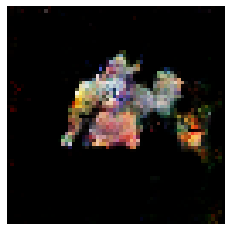

epoch 96
0.0759692620486021 7.429522514343262


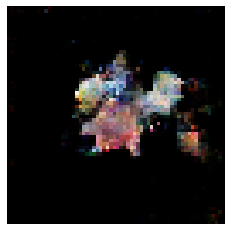

epoch 97
0.03128145355731249 7.635760307312012


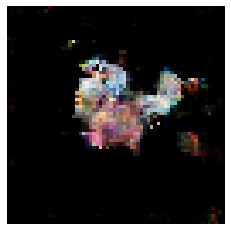

epoch 98
0.035533520858734846 7.746315002441406


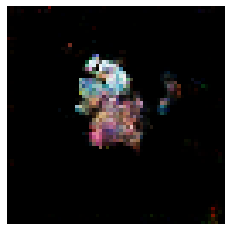

epoch 99
0.014350260142236948 9.017532348632812


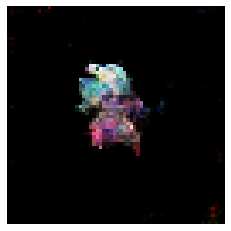

epoch 100
0.06508907116949558 10.029510498046875


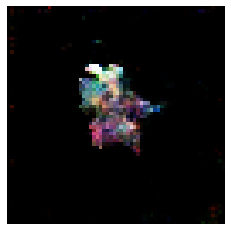

epoch 101
0.04008549079298973 8.080802917480469


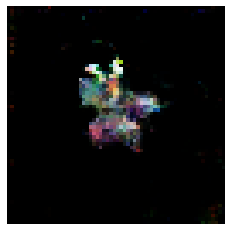

epoch 102
0.05243984702974558 8.527214050292969


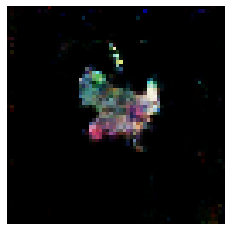

epoch 103
0.030860641971230507 9.1980619430542


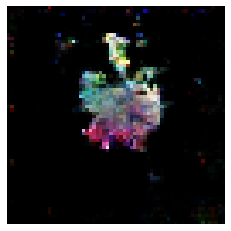

epoch 104
0.044298606168013066 9.40280532836914


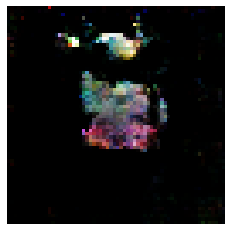

epoch 105
0.019120273180305958 8.596426010131836


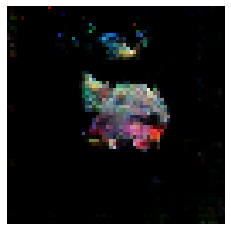

epoch 106
0.026488414965569973 7.768792152404785


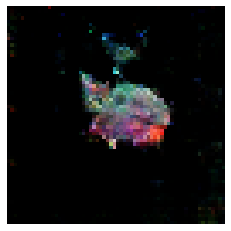

epoch 107
0.02115737390704453 8.310544967651367


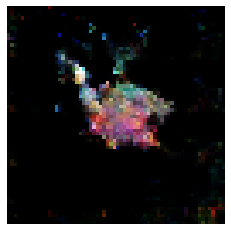

epoch 108
0.013886293862015009 8.328523635864258


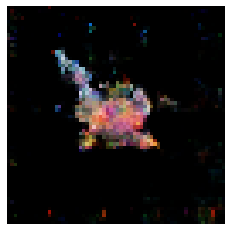

epoch 109
0.055805355310440063 9.73815631866455


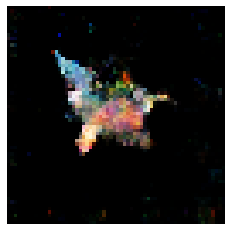

epoch 110
0.0657534059137106 7.904140472412109


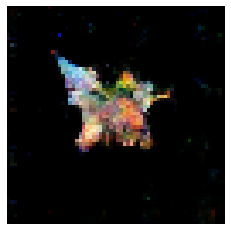

epoch 111
0.007648594910278916 7.785029411315918


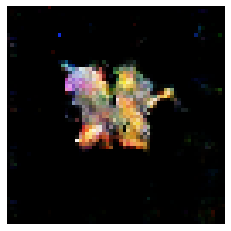

epoch 112
0.030460049398243427 8.36805534362793


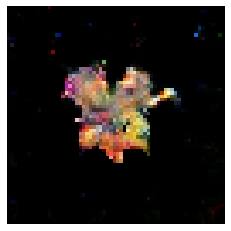

epoch 113
0.06949086114764214 9.364849090576172


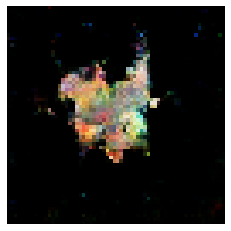

epoch 114
0.061292801052331924 11.697138786315918


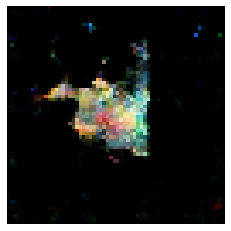

epoch 115
0.007027113228105009 9.173970222473145


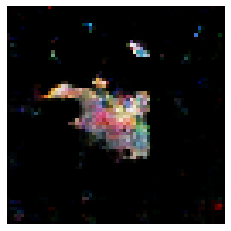

epoch 116
0.050343992188572884 9.456937789916992


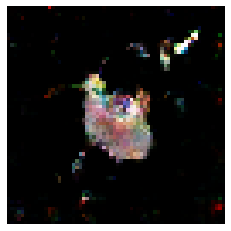

epoch 117
0.009349485393613577 7.61247444152832


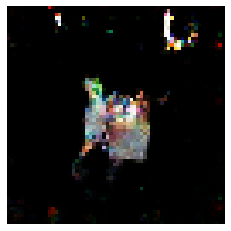

epoch 118
0.0715368203818798 10.724222183227539


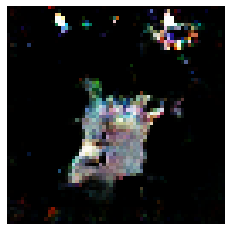

epoch 119
0.09755195677280426 11.787033081054688


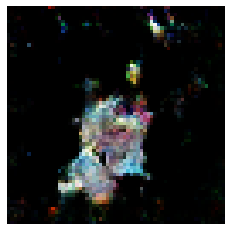

epoch 120
0.05317138694226742 9.873849868774414


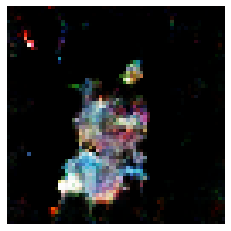

epoch 121
0.04246414126828313 11.826576232910156


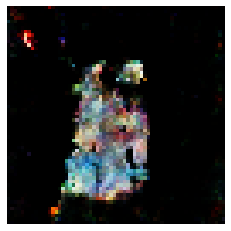

epoch 122
0.041213542222976685 13.176623344421387


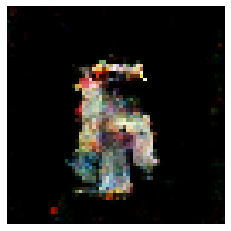

epoch 123
0.024717818945646286 8.788662910461426


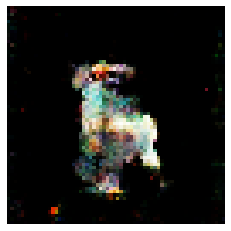

epoch 124
0.05267728120088577 10.019588470458984


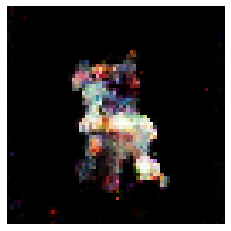

epoch 125
0.010660746367648244 9.618950843811035


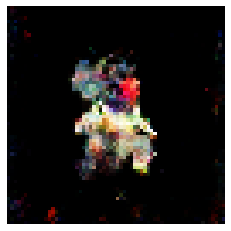

epoch 126
0.08020909503102303 9.987831115722656


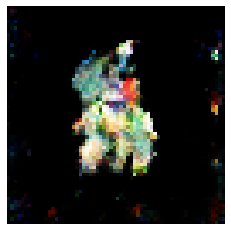

epoch 127
0.006425961764762178 11.453194618225098


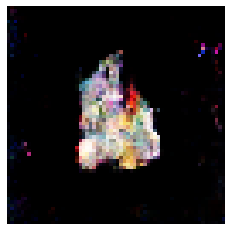

epoch 128
0.029275236185640097 8.984190940856934


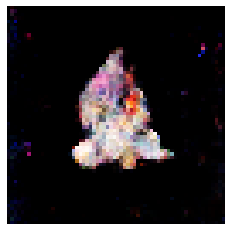

epoch 129
0.01405963092111051 9.393409729003906


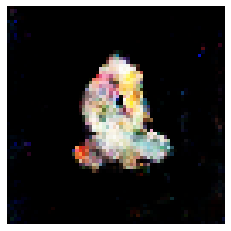

epoch 130
0.029484061058610678 8.59469985961914


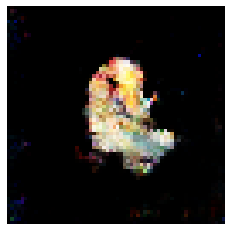

epoch 131
0.012113765580579638 8.879465103149414


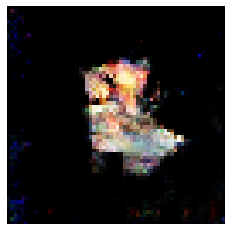

epoch 132
0.027033702470362186 9.454460144042969


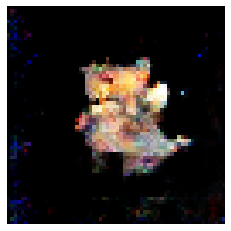

epoch 133
0.007564040250144899 8.613447189331055


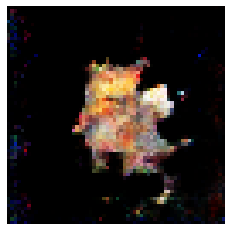

epoch 134
0.02775684231892228 9.785965919494629


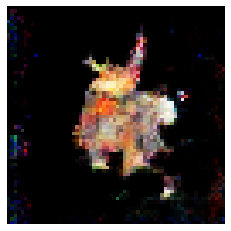

epoch 135
0.008052439661696553 9.679450988769531


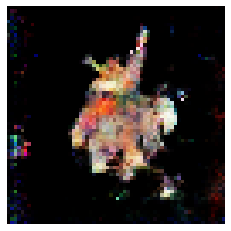

epoch 136
0.013872010167688131 9.135327339172363


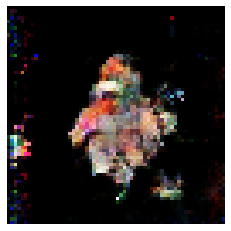

epoch 137
0.008042898960411549 9.467443466186523


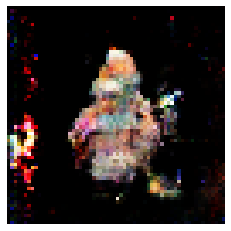

epoch 138
0.029065546579658985 9.549972534179688


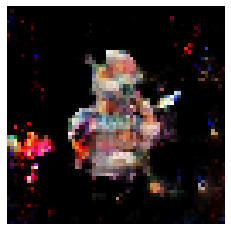

epoch 139
0.03496022615581751 8.953997611999512


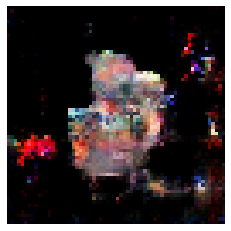

epoch 140
0.017946251900866628 9.776017189025879


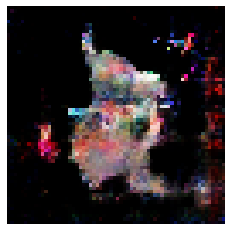

epoch 141
0.1007603257894516 10.338058471679688


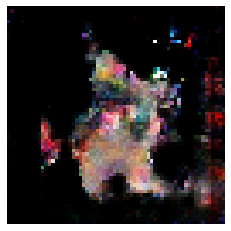

epoch 142
0.007860995770897716 10.512749671936035


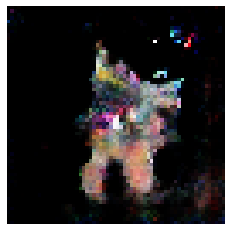

epoch 143
0.012252036634890828 17.618803024291992


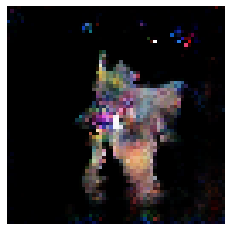

epoch 144
0.0180092453956604 11.508415222167969


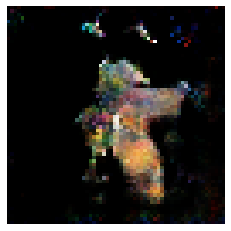

epoch 145
0.005136627645697445 11.068941116333008


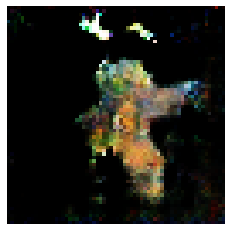

epoch 146
0.01908917771652341 10.764215469360352


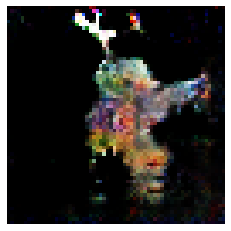

epoch 147
0.013596570817753673 9.673047065734863


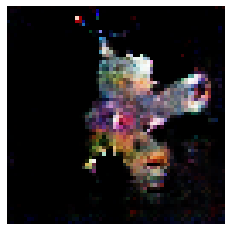

epoch 148
0.03247900400310755 10.292586326599121


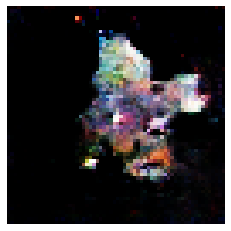

epoch 149
0.02366278343833983 11.18652057647705


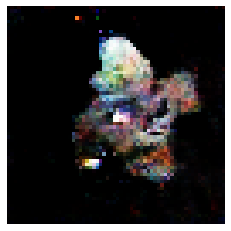

epoch 150
0.004973824485205114 9.563121795654297


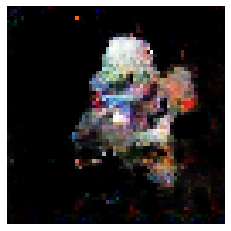

epoch 151
0.005966918775811791 11.210220336914062


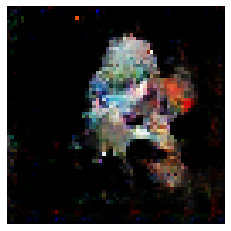

epoch 152
0.061503616627305746 14.48653793334961


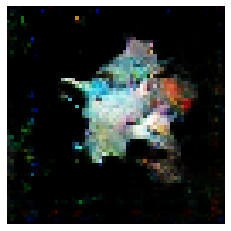

epoch 153
0.025210244115442038 13.011962890625


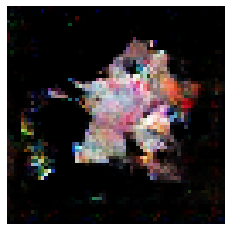

epoch 154
0.013366610743105412 10.044583320617676


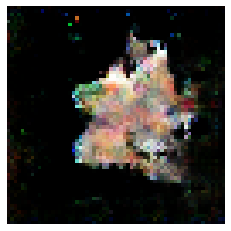

epoch 155
0.004554157159873284 13.994747161865234


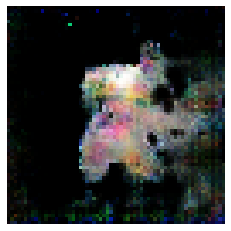

epoch 156
0.09557772427797318 13.987811088562012


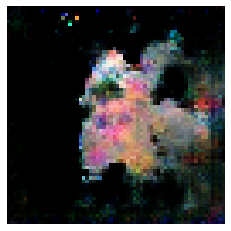

epoch 157
0.029940047301352024 9.199697494506836


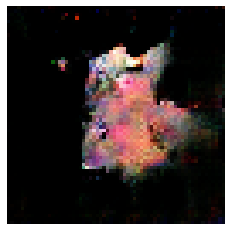

epoch 158
0.00276254685013555 12.35483169555664


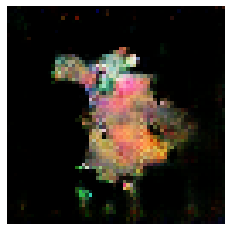

epoch 159
0.11986814392730594 11.487266540527344


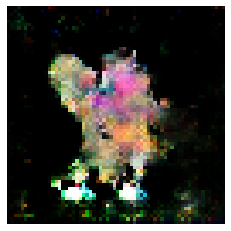

epoch 160
0.006491635169368237 9.128043174743652


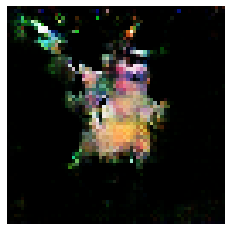

epoch 161
0.008799470262601972 8.902336120605469


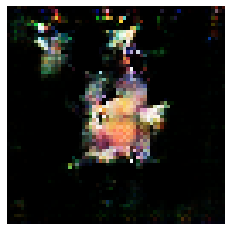

epoch 162
0.03543042903766036 8.563047409057617


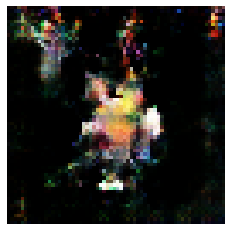

epoch 163
0.04130216787598329 16.142261505126953


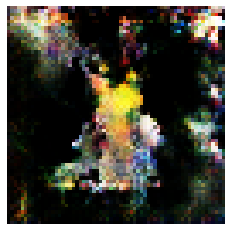

epoch 164
0.039939732290804386 17.535274505615234


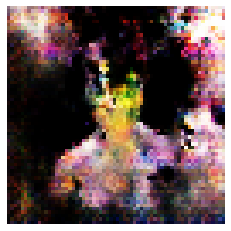

epoch 165
0.10802485406034634 19.679967880249023


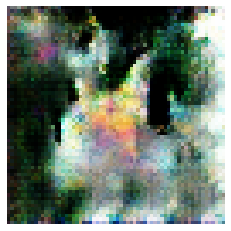

epoch 166
27.75233268737793 164.00811767578125


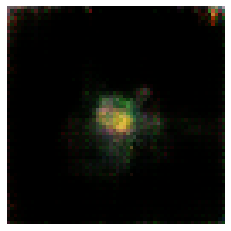

epoch 167
0.8736124709248543 19.17498016357422


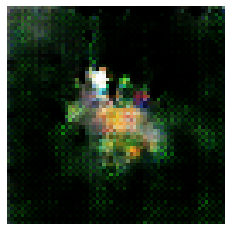

epoch 168
0.9365237653255463 11.609675407409668


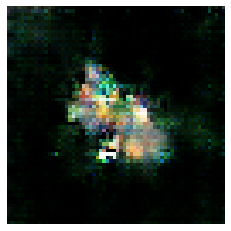

epoch 169
0.3151304251514375 10.413599014282227


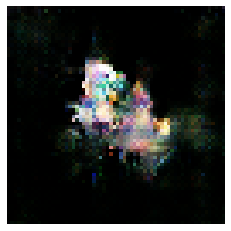

epoch 170
0.3465619385242462 8.923826217651367


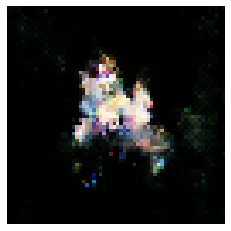

epoch 171
0.08125101681798697 8.413858413696289


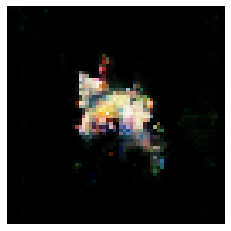

epoch 172
0.18518496304750443 9.69420051574707


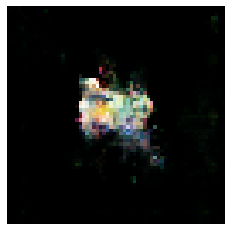

epoch 173
0.115809615701437 10.427820205688477


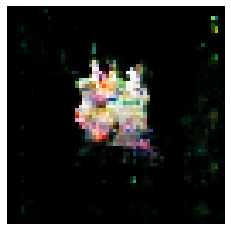

epoch 174
0.36735497415065765 8.305925369262695


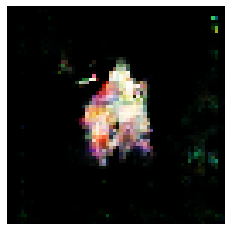

epoch 175
0.13182618468999863 7.229348659515381


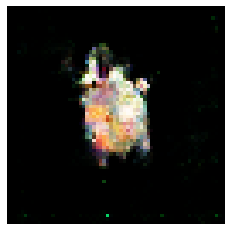

epoch 176
0.12734560295939445 6.057787895202637


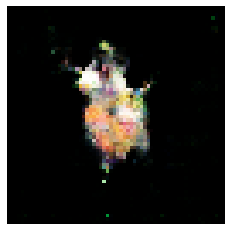

epoch 177
0.07404361851513386 7.774989128112793


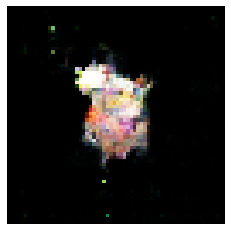

epoch 178
0.08140812441706657 8.498916625976562


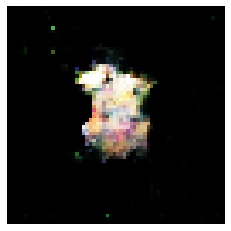

epoch 179
0.23564085364341736 10.765663146972656


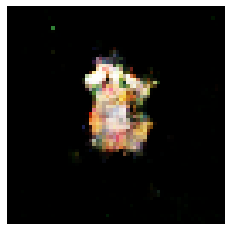

epoch 180
0.13264282792806625 7.942618370056152


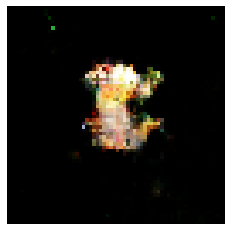

epoch 181
0.12407432869076729 10.42037296295166


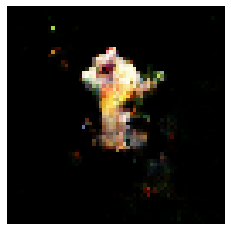

epoch 182
0.1401800736784935 10.963106155395508


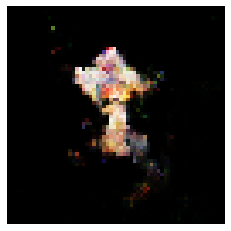

epoch 183
0.08204803615808487 9.892757415771484


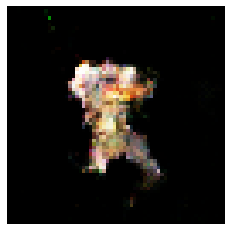

epoch 184
0.1262150313705206 10.005131721496582


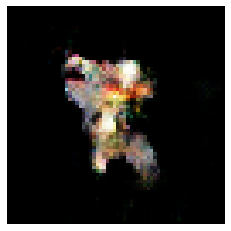

epoch 185
0.3397098332643509 11.948192596435547


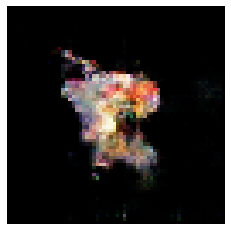

epoch 186
0.04366512782871723 7.905154228210449


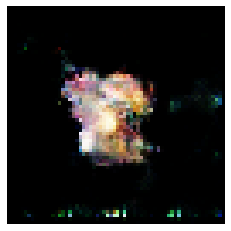

epoch 187
0.04659285023808479 9.598350524902344


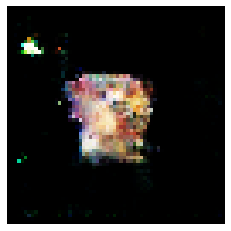

epoch 188
0.14952390268445015 11.920385360717773


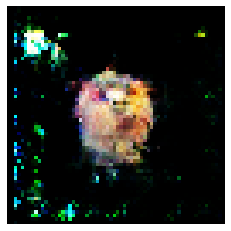

epoch 189
0.0753289945423603 16.449291229248047


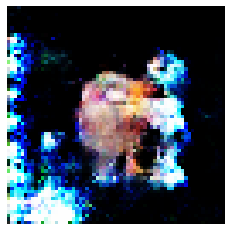

epoch 190
0.016876551206223667 7.470942497253418


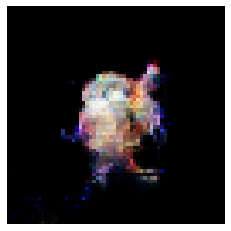

epoch 191
0.0557536818087101 8.289111137390137


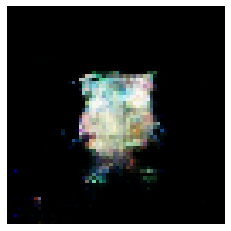

epoch 192
0.17996313679032028 13.92207145690918


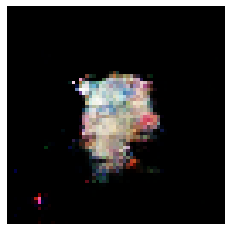

epoch 193
0.0329344910569489 16.245119094848633


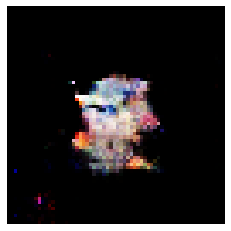

epoch 194
0.23028726875782013 14.80272102355957


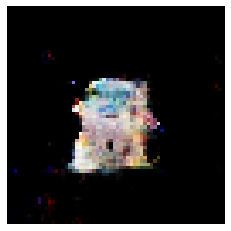

epoch 195
0.05463919974863529 8.105202674865723


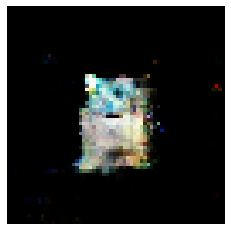

epoch 196
0.07342438399791718 7.9596757888793945


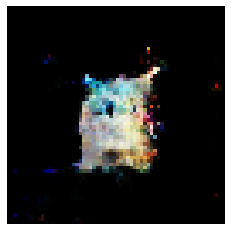

epoch 197
0.03834891505539417 8.83729362487793


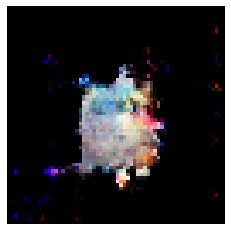

epoch 198
0.0627300813794136 10.713008880615234


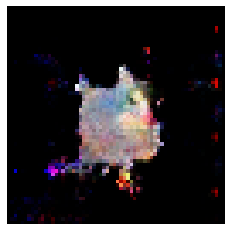

epoch 199
0.1321318857371807 11.994607925415039


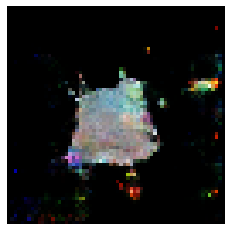

epoch 200
0.030090948566794395 8.137727737426758


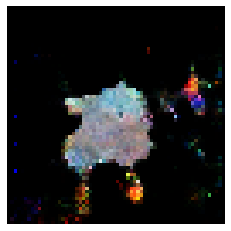

epoch 201
0.04433458694256842 9.907110214233398


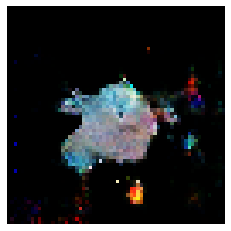

epoch 202
0.03897670656442642 9.775201797485352


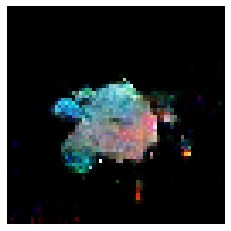

epoch 203
0.02310869819484651 8.600774765014648


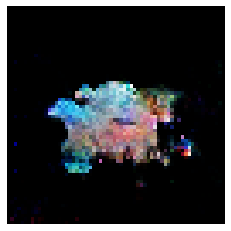

epoch 204
0.04268611967563629 11.562745094299316


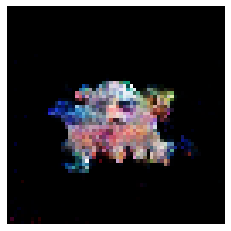

epoch 205
0.058871214278042316 7.582578659057617


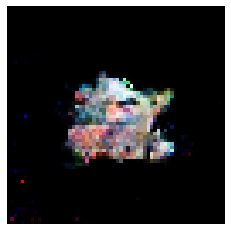

epoch 206
0.043818240985274315 9.966875076293945


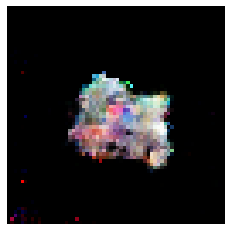

epoch 207
0.03227400593459606 9.700261116027832


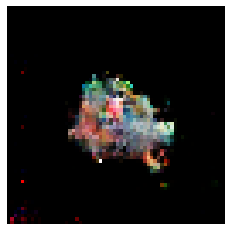

epoch 208
0.05426472797989845 13.407700538635254


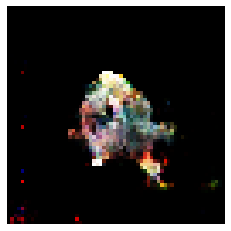

epoch 209
0.11639382131397724 18.70722198486328


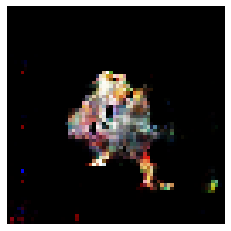

epoch 210
0.0643608164973557 11.313275337219238


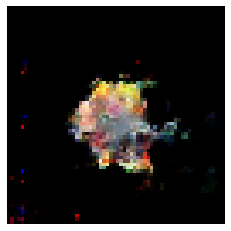

epoch 211
0.046581003814935684 7.706849575042725


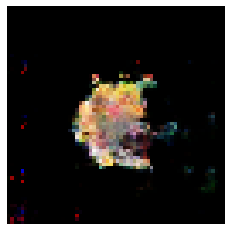

epoch 212
0.06423515267670155 8.662674903869629


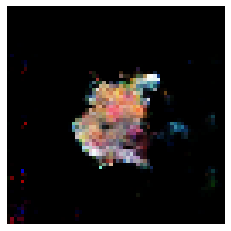

epoch 213
0.0333602549508214 9.346277236938477


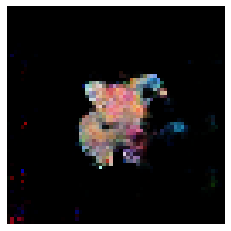

epoch 214
0.033258718613069504 10.661426544189453


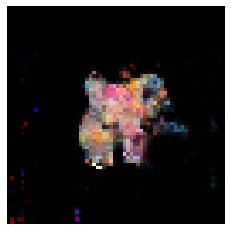

epoch 215
0.0053427021484822035 13.520200729370117


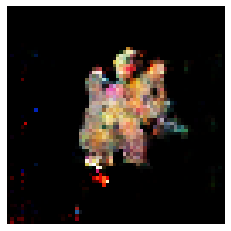

epoch 216
0.015385838283691555 10.295068740844727


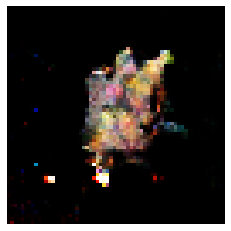

epoch 217
0.016283518634736538 10.494986534118652


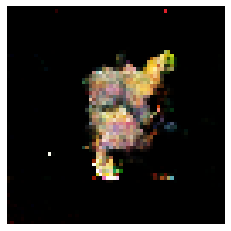

epoch 218
0.007996252621524036 9.585736274719238


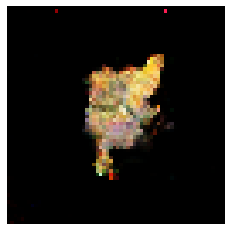

epoch 219
0.08953177556395531 14.266992568969727


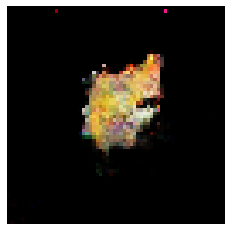

epoch 220
0.07634275034070015 12.768858909606934


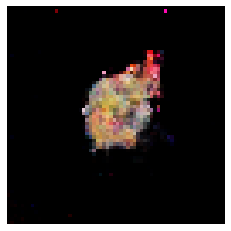

epoch 221
0.030194042716175318 11.115289688110352


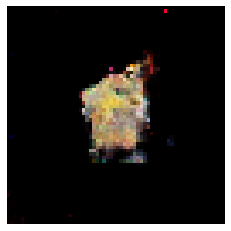

epoch 222
0.023436102084815502 9.644429206848145


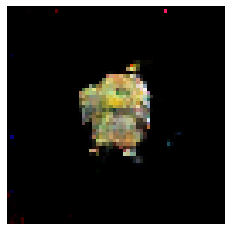

epoch 223
0.006403848063200712 9.525126457214355


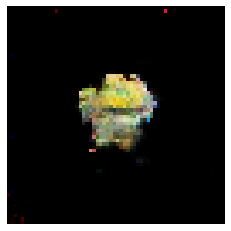

epoch 224
0.041081326082348824 8.73816204071045


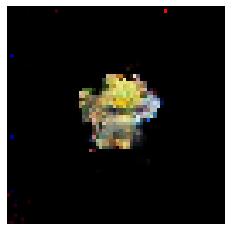

epoch 225
0.049185898154973984 8.450506210327148


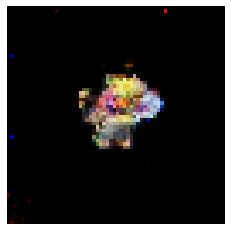

epoch 226
0.045437226071953773 9.750932693481445


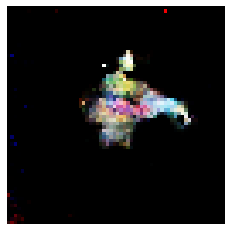

epoch 227
0.007425837218761444 9.723237991333008


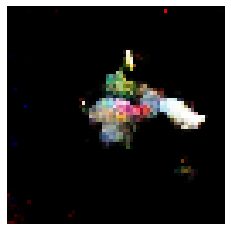

epoch 228
0.0037609155115205795 10.927719116210938


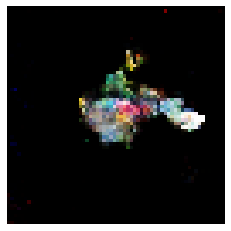

epoch 229
0.0199181716889143 9.807706832885742


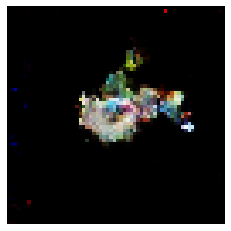

epoch 230
0.01705959509126842 12.205089569091797


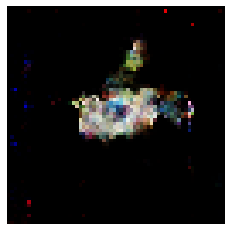

epoch 231
0.029314420244190842 10.021723747253418


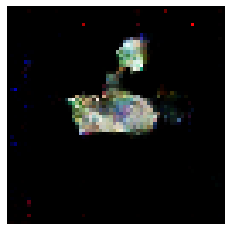

epoch 232
0.005149833858013153 11.580636024475098


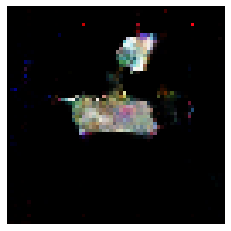

epoch 233
0.021801404654979706 12.197227478027344


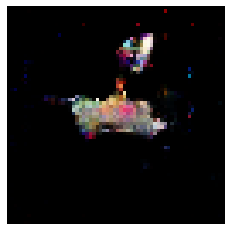

epoch 234
0.009878481505438685 9.932354927062988


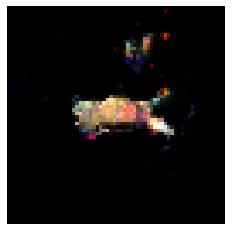

epoch 235
0.02901605609804392 10.704238891601562


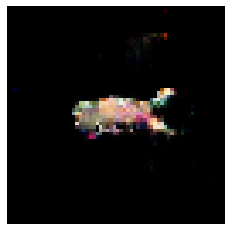

epoch 236
0.02093933871947229 10.868683815002441


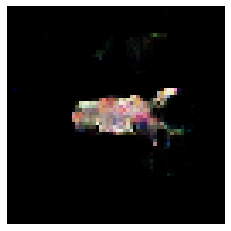

epoch 237
0.051890283823013306 12.515932083129883


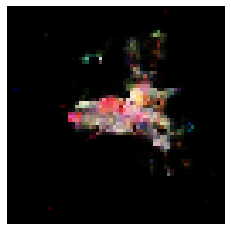

epoch 238
0.031070878729224205 14.690179824829102


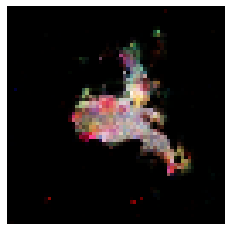

epoch 239
0.02411928924266249 11.731669425964355


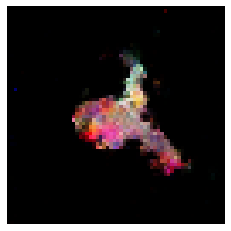

epoch 240
0.05509200692176819 15.462126731872559


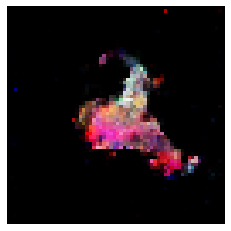

epoch 241
0.15630599856376648 16.569950103759766


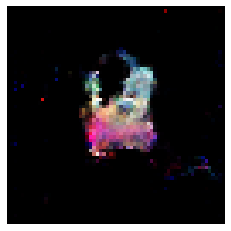

epoch 242
0.07862646505236626 10.959260940551758


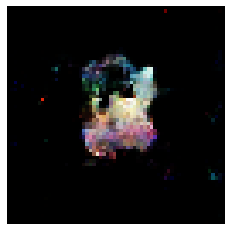

epoch 243
0.061159306205809116 17.048215866088867


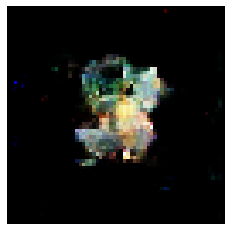

epoch 244
0.011479568609502167 14.138322830200195


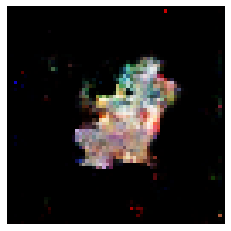

epoch 245
0.00394377252086997 11.380313873291016


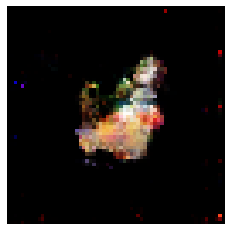

epoch 246
0.0305701345205307 13.151050567626953


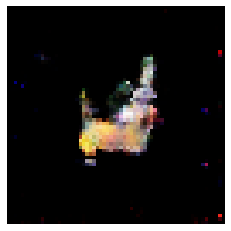

epoch 247
0.044141052290797234 11.333625793457031


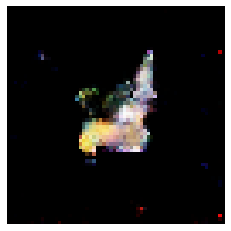

epoch 248
0.03579191374592483 10.878265380859375


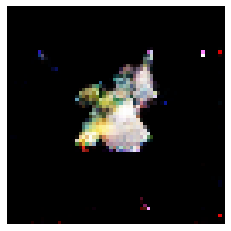

epoch 249
0.011332551715895534 14.61484146118164


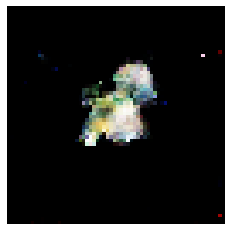

epoch 250
0.0026813976583071053 10.448596954345703


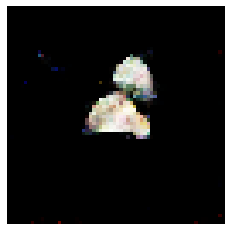

epoch 251
0.010344994254410267 10.061443328857422


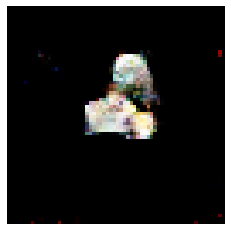

epoch 252
0.046762153040617704 15.036336898803711


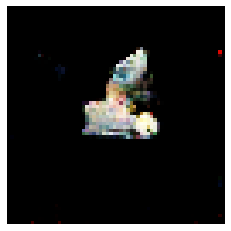

epoch 253
0.007160698412917554 10.306105613708496


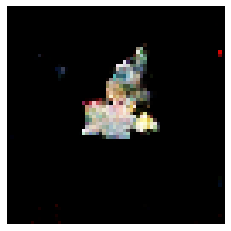

epoch 254
0.010259238944854587 10.158308982849121


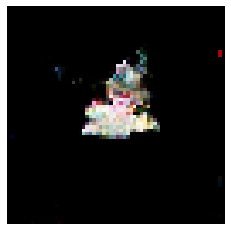

epoch 255
0.026143977418541908 9.96772289276123


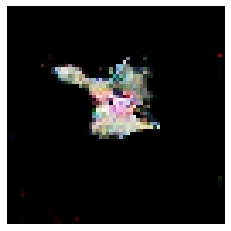

epoch 256
0.020388124510645866 11.47746467590332


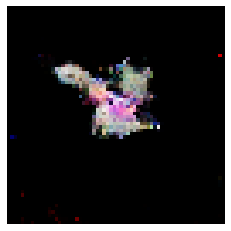

epoch 257
0.003485025488771498 10.852701187133789


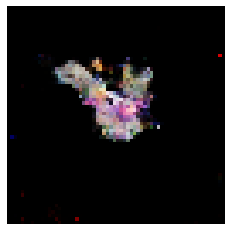

epoch 258
0.015852557495236397 11.663688659667969


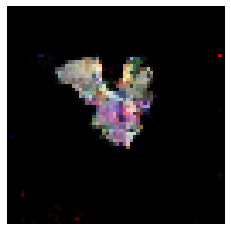

epoch 259
0.013371206354349852 8.877148628234863


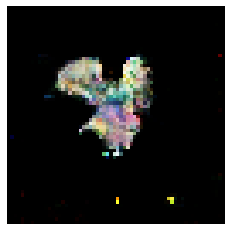

epoch 260
0.023988673696294427 13.85371208190918


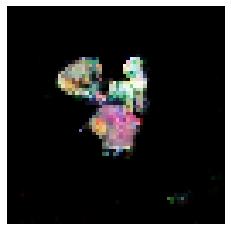

epoch 261
0.01910630287602544 10.541701316833496


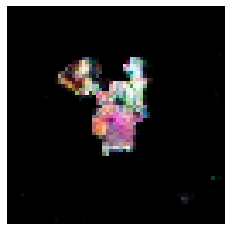

epoch 262
0.07201494462788105 13.305240631103516


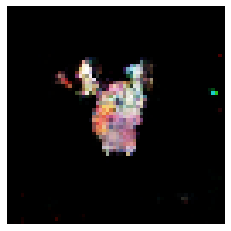

epoch 263
0.1007645484060049 12.366955757141113


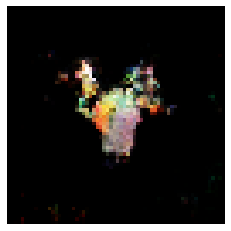

epoch 264
0.00930247048381716 10.89123249053955


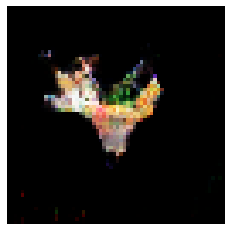

epoch 265
0.0345157862175256 15.421602249145508


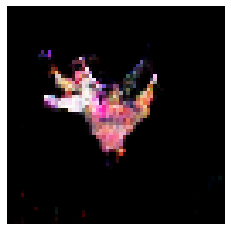

epoch 266
0.00942743825726211 9.035564422607422


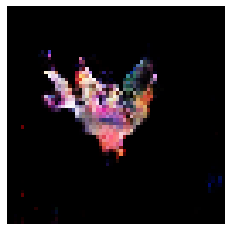

epoch 267
0.012893409468233585 13.382713317871094


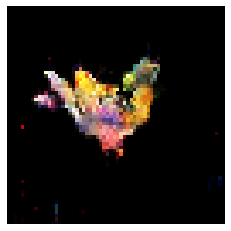

epoch 268
0.031326090916991234 10.586843490600586


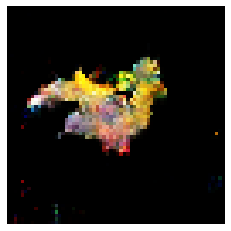

epoch 269
0.08066167347715236 13.975461959838867


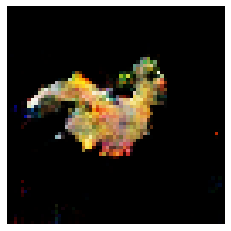

epoch 270
0.02814829722046852 9.802857398986816


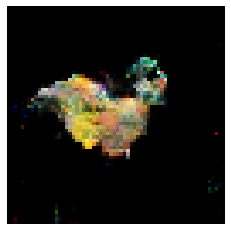

epoch 271
0.036761319264769554 11.62990951538086


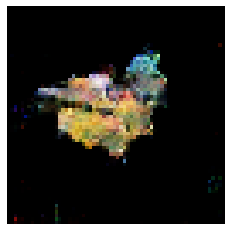

epoch 272
0.03700437242514454 12.023727416992188


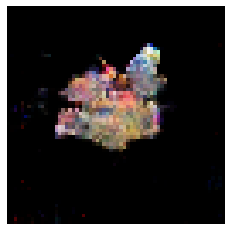

epoch 273
0.018207757268100977 11.524884223937988


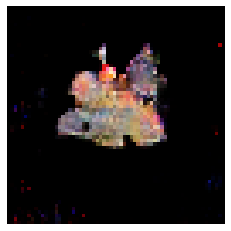

epoch 274
0.01235916092991829 9.511940002441406


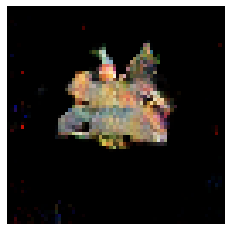

epoch 275
0.04896459635347128 14.672087669372559


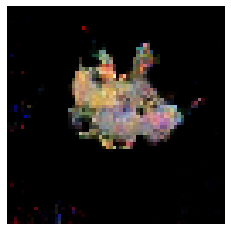

epoch 276
0.008098311605863273 13.613518714904785


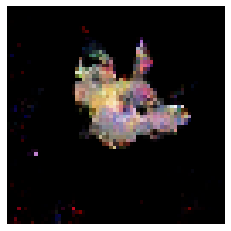

epoch 277
0.038907704409211874 14.127817153930664


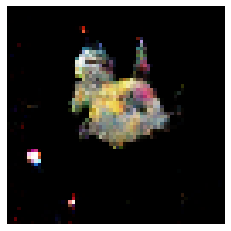

epoch 278
0.03303419717121869 15.783885955810547


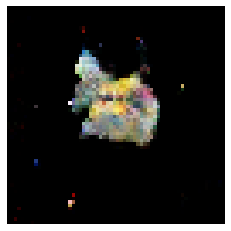

epoch 279
0.20477470755577087 17.104721069335938


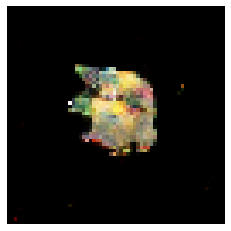

epoch 280
0.02120893821120262 13.982908248901367


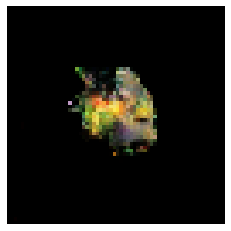

epoch 281
0.009156111744232476 12.552815437316895


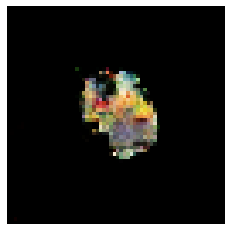

epoch 282
0.024520471692085266 12.347185134887695


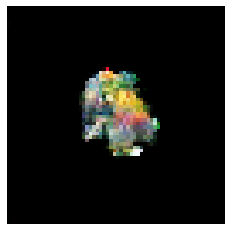

epoch 283
0.02961060032248497 10.210975646972656


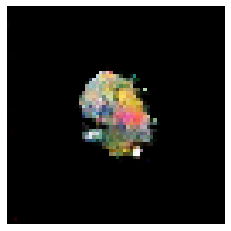

epoch 284
0.03740450832992792 8.050302505493164


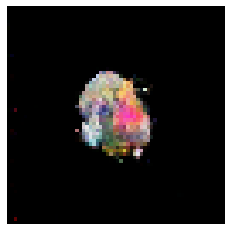

epoch 285
0.0256818215129897 9.03164005279541


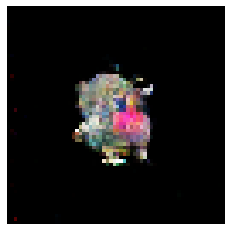

epoch 286
0.01217474980512634 11.230361938476562


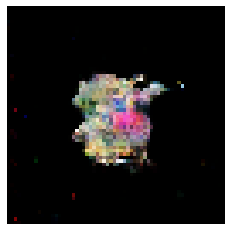

epoch 287
0.0196164408698678 10.039791107177734


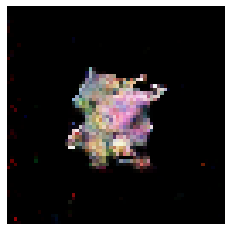

epoch 288
0.06800789373301086 15.024036407470703


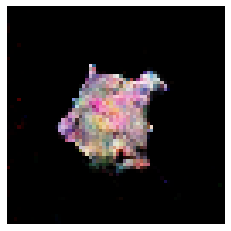

epoch 289
0.0003237786640966078 16.14270782470703


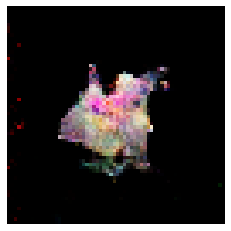

epoch 290
0.005307588842697442 10.423954010009766


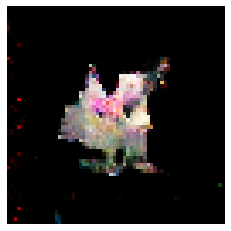

epoch 291
0.00796827162412228 14.109442710876465


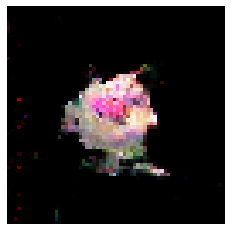

epoch 292
0.008291670819744468 11.511919021606445


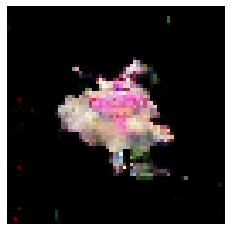

epoch 293
0.03104233229532838 10.476964950561523


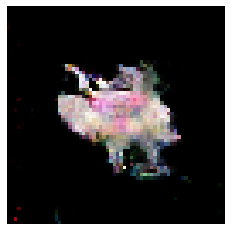

epoch 294
0.005439497821498662 10.975057601928711


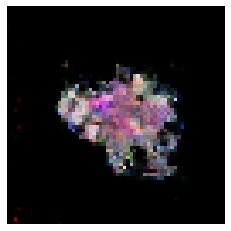

epoch 295
0.03424329636618495 15.115388870239258


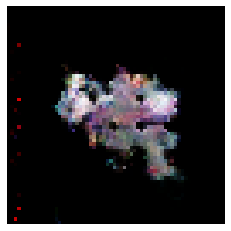

epoch 296
0.01982008432969451 14.32835578918457


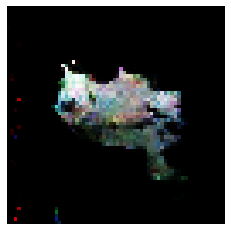

epoch 297
0.0010905604576691985 11.994345664978027


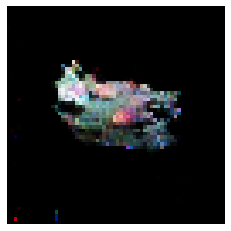

epoch 298
0.0014499427052214742 11.14754867553711


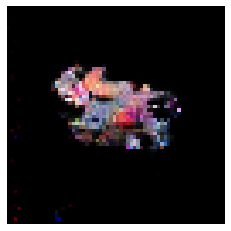

epoch 299
0.001944641797535951 10.661567687988281


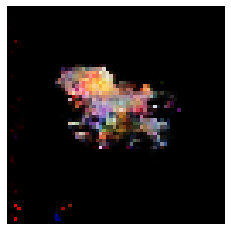

epoch 300
0.004521395778283477 11.534518241882324


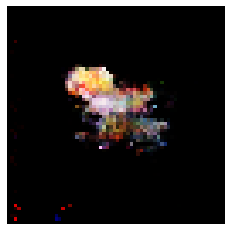

epoch 301
0.014913994004018605 17.93967056274414


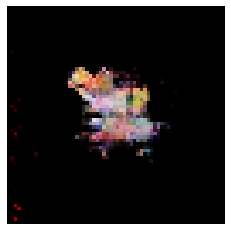

epoch 302
0.001964842391316779 13.27056884765625


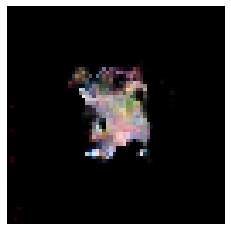

epoch 303
0.0038317554972309154 16.19497299194336


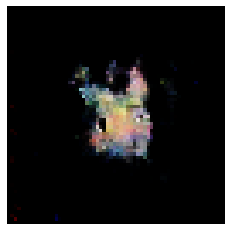

epoch 304
0.01789054438995663 12.340208053588867


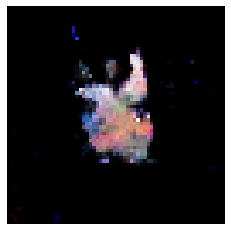

epoch 305
0.13940830899264256 21.85080909729004


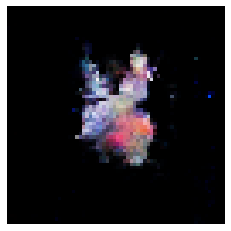

epoch 306
0.04257476931570636 20.896678924560547


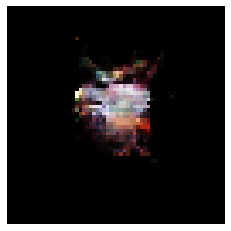

epoch 307
0.005187633214518428 12.078536987304688


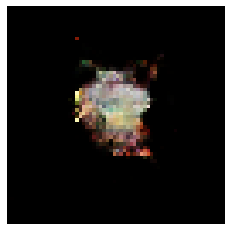

epoch 308
0.0930517875822261 12.348428726196289


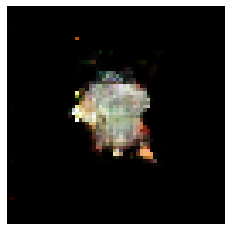

epoch 309
0.0023537209490314126 10.476470947265625


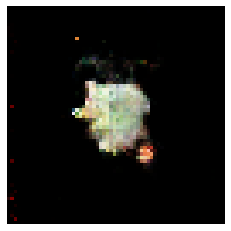

epoch 310
0.0033976798731600866 17.28827667236328


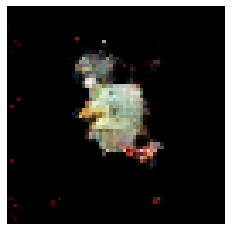

epoch 311
0.04388240072876215 12.08293342590332


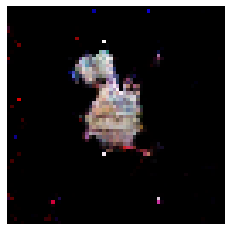

epoch 312
0.062487632036209106 19.433263778686523


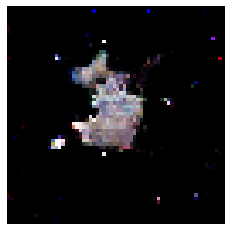

epoch 313
0.06507556270480563 18.36109161376953


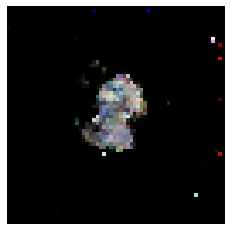

epoch 314
0.00429529557004571 15.532129287719727


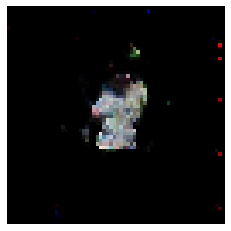

epoch 315
0.001963675626029726 11.415014266967773


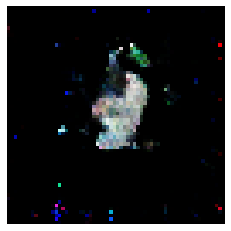

epoch 316
0.0009104831551667303 14.416193008422852


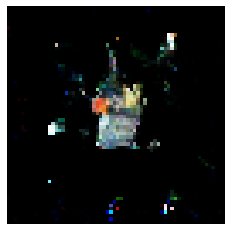

epoch 317
0.004968317924067378 18.00600242614746


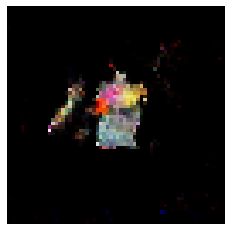

epoch 318
0.01435569359659894 10.242867469787598


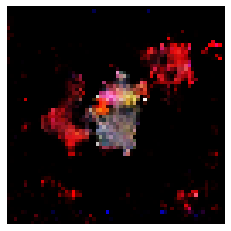

epoch 319
0.004457967821508646 10.898050308227539


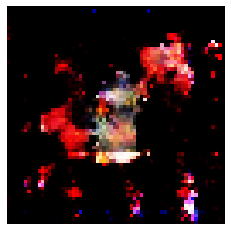

epoch 320
29.09541842341423 159.47219848632812


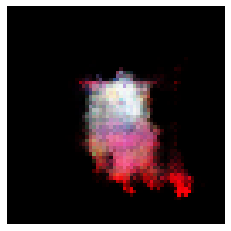

epoch 321
1.837185151875019 19.72195816040039


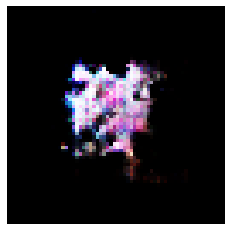

epoch 322
2.4538277983665466 25.54150390625


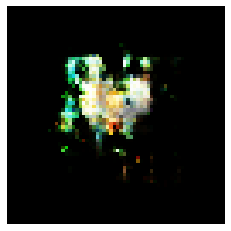

epoch 323
1.2320408821105957 10.665861129760742


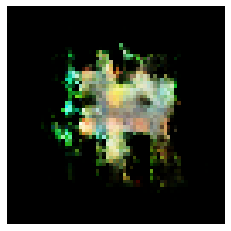

epoch 324
1.2033182978630066 11.956192970275879


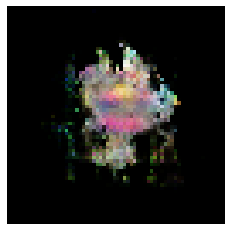

epoch 325
0.5680654048919678 7.646276950836182


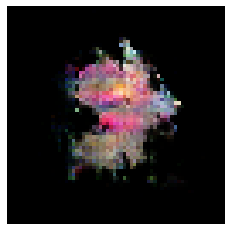

epoch 326
0.4510194957256317 6.541822910308838


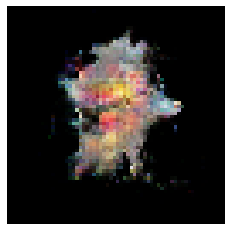

epoch 327
0.4617481231689453 8.051502227783203


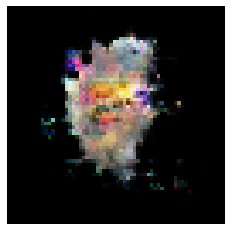

epoch 328
0.5172941833734512 8.953965187072754


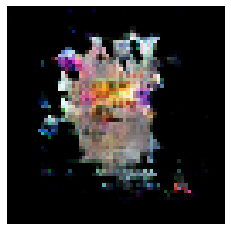

epoch 329
0.675041675567627 11.247392654418945


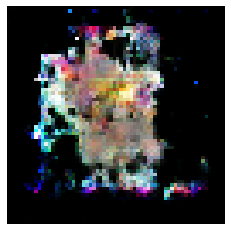

epoch 330
0.5248964577913284 7.457975387573242


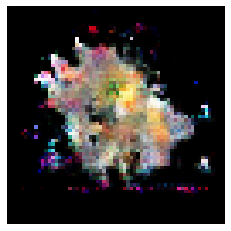

epoch 331
0.4227873161435127 7.9177350997924805


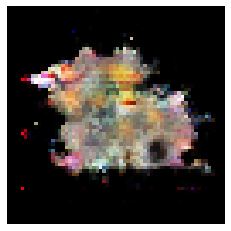

epoch 332
0.7937057912349701 9.792495727539062


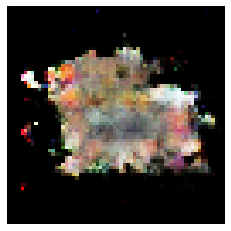

epoch 333
0.3515400290489197 6.247402191162109


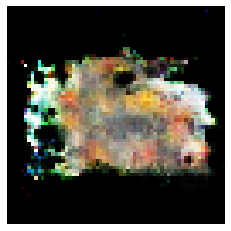

epoch 334
0.5176504254341125 9.464920043945312


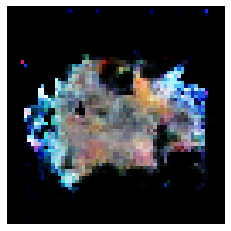

epoch 335
0.2982069253921509 8.26988410949707


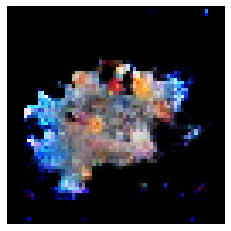

epoch 336
0.11816680431365967 8.42737102508545


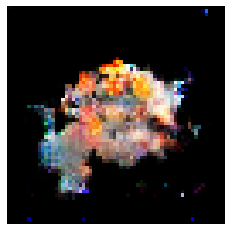

epoch 337
0.4164973199367523 9.751529693603516


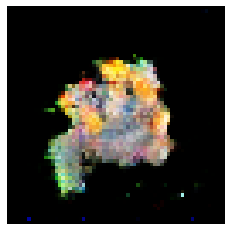

epoch 338
0.3109423518180847 8.389286041259766


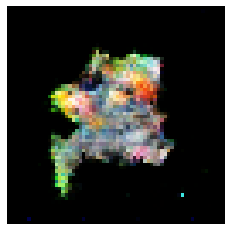

epoch 339
0.34639520943164825 9.542640686035156


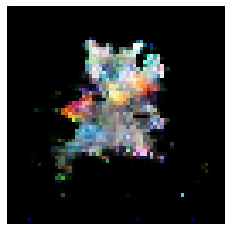

epoch 340
0.2572767436504364 8.496097564697266


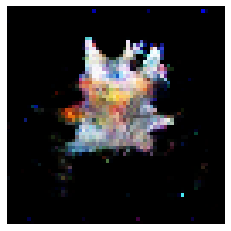

epoch 341
0.17947595566511154 6.705533981323242


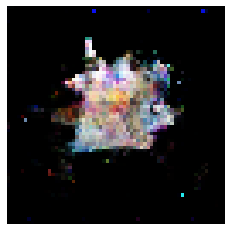

epoch 342
0.21106189489364624 8.113356590270996


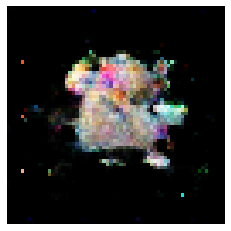

epoch 343
0.09081747382879257 6.933075428009033


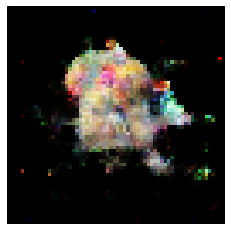

epoch 344
0.22842294722795486 7.668282985687256


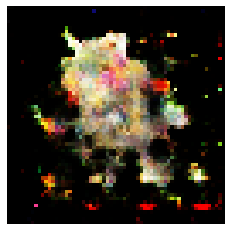

epoch 345
0.34968578815460205 10.911195755004883


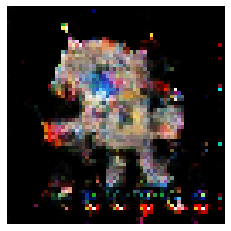

epoch 346
0.24680176377296448 11.620628356933594


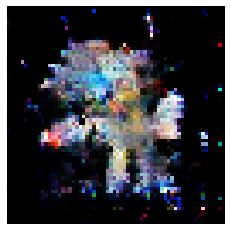

epoch 347
0.06971397995948792 6.153575897216797


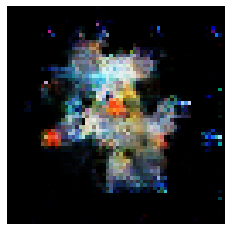

epoch 348
0.1581660434603691 7.946263790130615


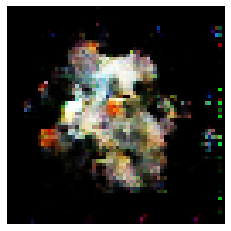

epoch 349
0.16348635405302048 8.187023162841797


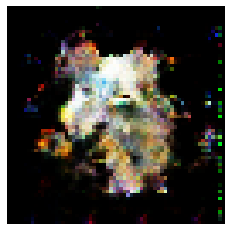

epoch 350
0.120115265250206 8.639771461486816


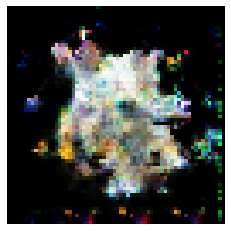

epoch 351
0.0980977900326252 9.639398574829102


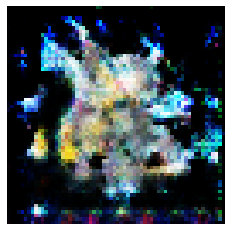

epoch 352
0.02832533832406625 12.929753303527832


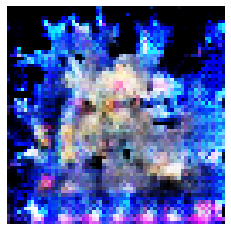

epoch 353
0.16606946947471712 27.968671798706055


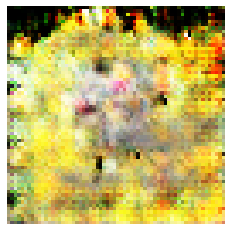

epoch 354
1.5353780975856353 12.583179473876953


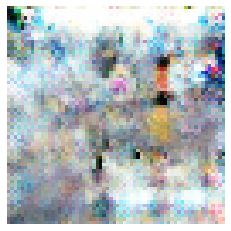

epoch 355
1.7532073734182632 13.768181800842285


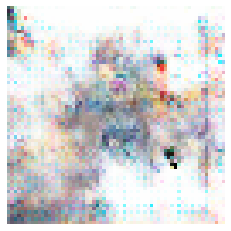

epoch 356
0.7530223280191422 9.661750793457031


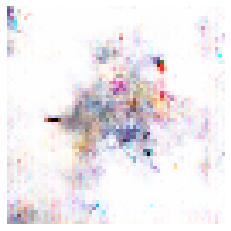

epoch 357
0.7996540814638138 9.747024536132812


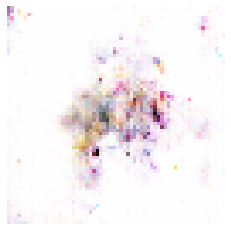

epoch 358
0.6434387713670731 9.546319961547852


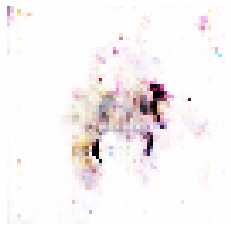

epoch 359
0.4070526261930354 10.266010284423828


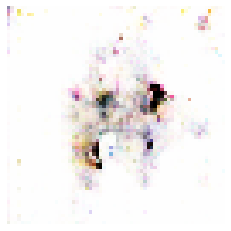

epoch 360
0.5474147498607635 8.980188369750977


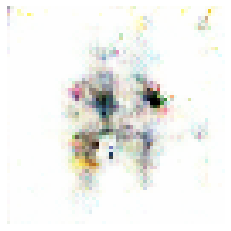

epoch 361
0.52828598767519 7.354825019836426


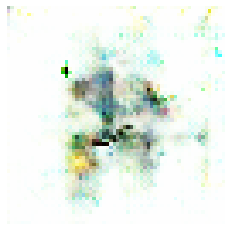

epoch 362
0.33201901614665985 5.522895812988281


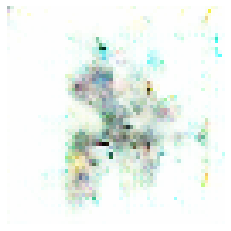

epoch 363
0.4201231673359871 6.118561744689941


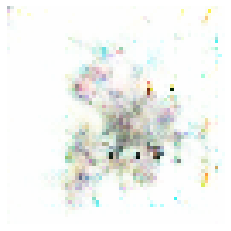

epoch 364
0.46193765103816986 6.582947731018066


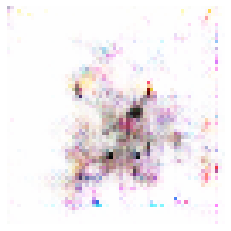

epoch 365
0.34221598878502846 5.80149507522583


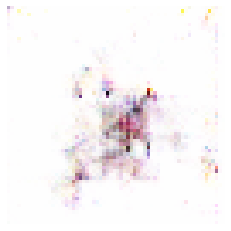

epoch 366
0.3296947479248047 5.86551570892334


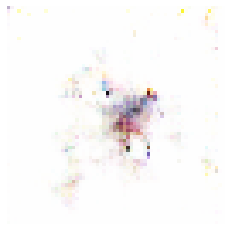

epoch 367
0.34809716418385506 5.0817179679870605


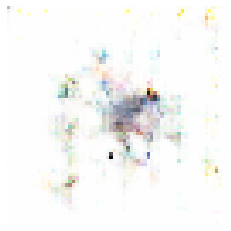

epoch 368
0.40363230713410303 9.280669212341309


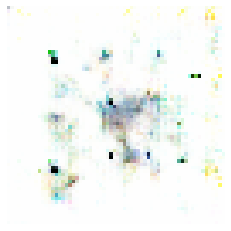

epoch 369
0.30221572518348694 5.821785926818848


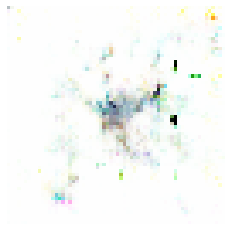

epoch 370
0.2763909250497818 5.569943428039551


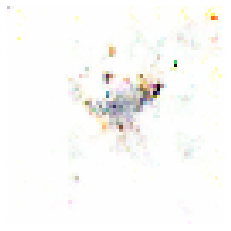

epoch 371
0.35726532340049744 5.852349758148193


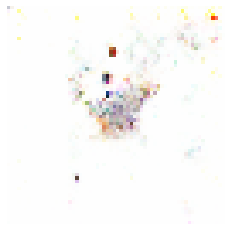

epoch 372
0.3290553018450737 5.713535785675049


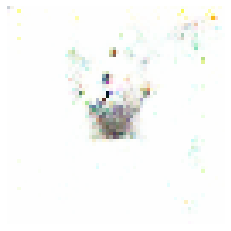

epoch 373
0.29283956065773964 5.753694534301758


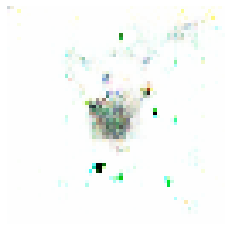

epoch 374
0.265387587249279 4.528166770935059


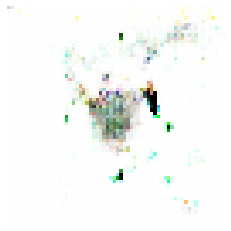

epoch 375
0.21942635625600815 5.3305792808532715


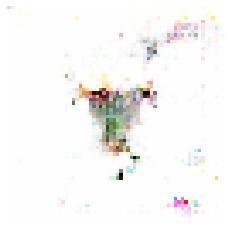

epoch 376
0.23201215639710426 5.105189323425293


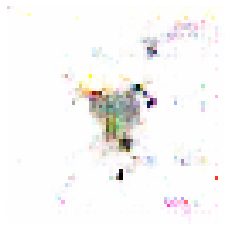

epoch 377
0.29277922213077545 6.097269058227539


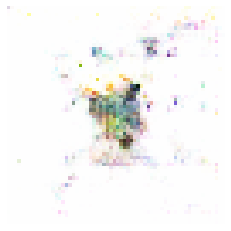

epoch 378
0.3106347620487213 5.990871906280518


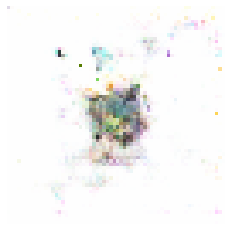

epoch 379
0.1946919709444046 5.335336685180664


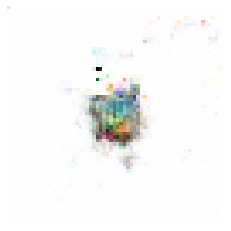

epoch 380
0.36194950342178345 6.381095886230469


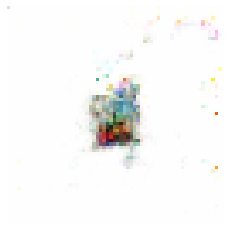

epoch 381
0.2239816002547741 4.27647590637207


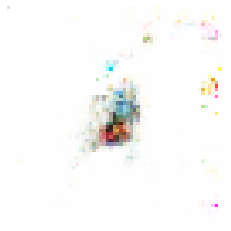

epoch 382
0.13706187903881073 5.344017505645752


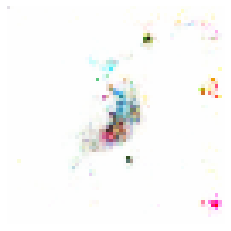

epoch 383
0.16885895654559135 5.576135635375977


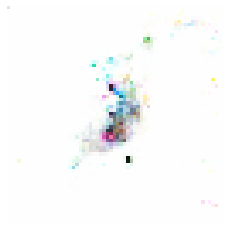

epoch 384
0.1986791007220745 5.645359516143799


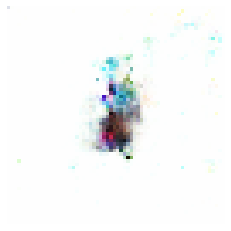

epoch 385
0.13605552725493908 5.221620559692383


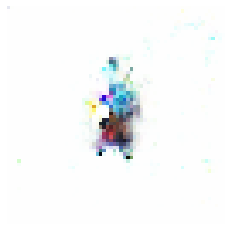

epoch 386
0.15965793328359723 5.5361175537109375


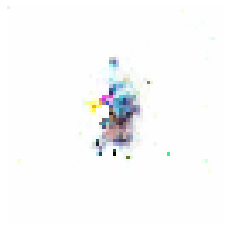

epoch 387
0.138489356264472 5.022524833679199


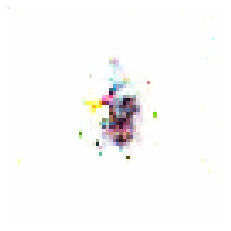

epoch 388
0.15042185597121716 5.185544490814209


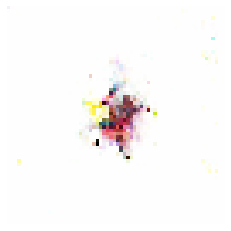

epoch 389
0.1605948731303215 7.283746242523193


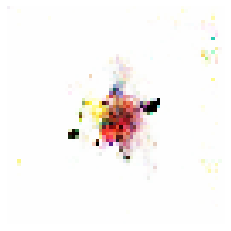

epoch 390
0.1993449442088604 5.2453742027282715


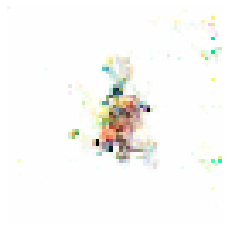

epoch 391
0.22635582089424133 5.599124908447266


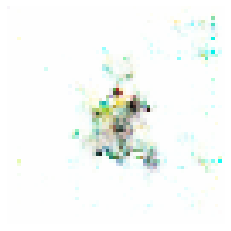

epoch 392
0.1612054742872715 5.12349271774292


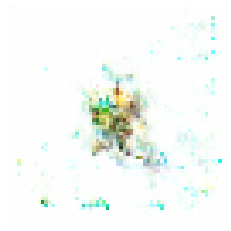

epoch 393
0.15195021405816078 5.265902996063232


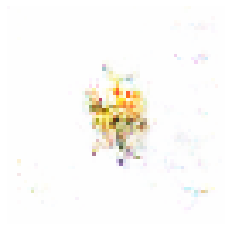

epoch 394
0.1623731106519699 6.318588733673096


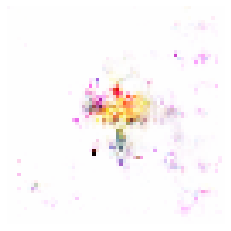

epoch 395
0.1865980587899685 6.434327125549316


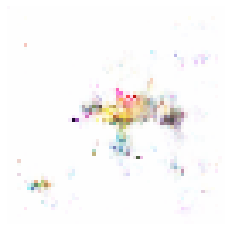

epoch 396
0.1488894298672676 6.09414529800415


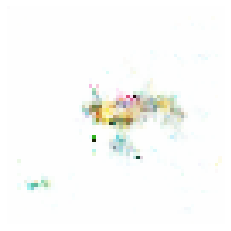

epoch 397
0.15279129147529602 5.809247970581055


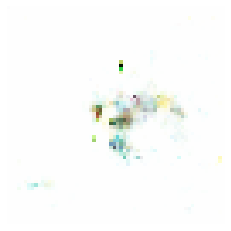

epoch 398
0.10034596174955368 6.121965408325195


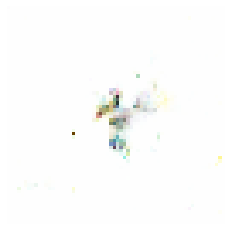

epoch 399
0.10869744420051575 5.866730213165283


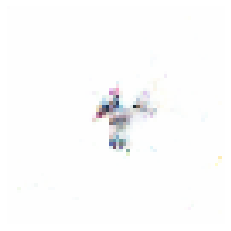

epoch 400
0.10086484625935555 5.394232273101807


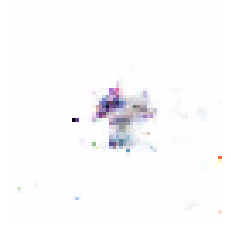

epoch 401
0.1062544584274292 5.469649314880371


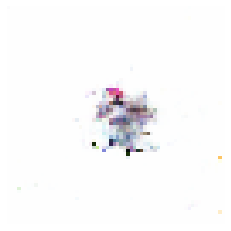

epoch 402
0.1076352708041668 5.295748710632324


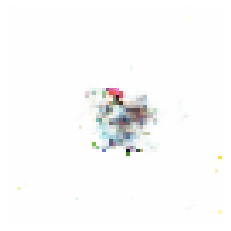

epoch 403
0.09782422706484795 5.367307662963867


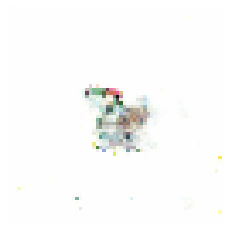

epoch 404
0.09571124240756035 5.015607833862305


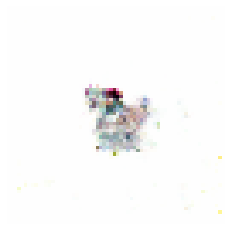

epoch 405
0.08345277048647404 5.837465286254883


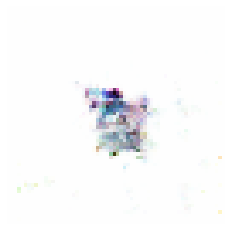

epoch 406
0.10668593645095825 5.563891887664795


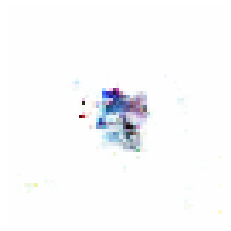

epoch 407
0.11319837532937527 5.289639949798584


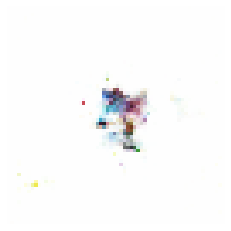

epoch 408
0.09223168343305588 5.898202896118164


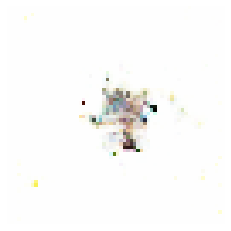

epoch 409
0.06785158812999725 4.8778395652771


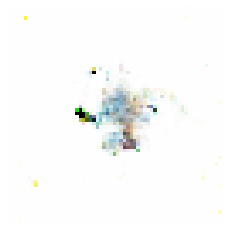

epoch 410
0.09365055337548256 5.779467582702637


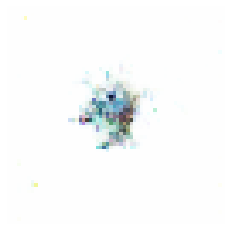

epoch 411
0.11069035902619362 5.219671726226807


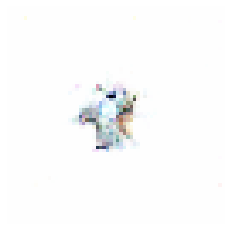

epoch 412
0.08795192092657089 5.646069526672363


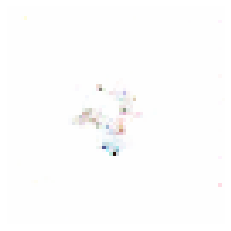

epoch 413
0.05347918998450041 6.165416240692139


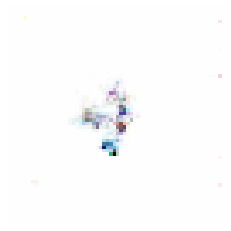

epoch 414
0.07423610985279083 5.9159674644470215


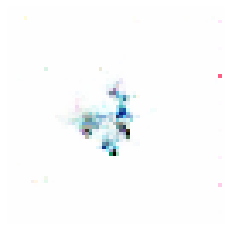

epoch 415
0.06807183474302292 5.098735809326172


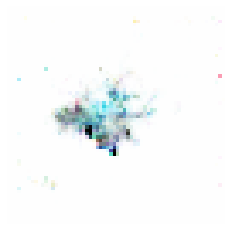

epoch 416
0.08477646647952497 7.038976192474365


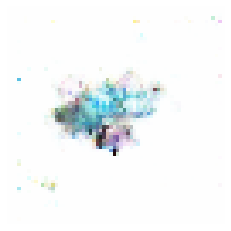

epoch 417
0.05986792966723442 6.313324928283691


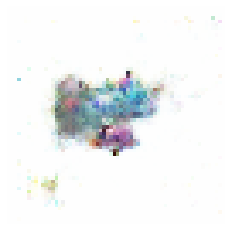

epoch 418
0.16442623734474182 8.015411376953125


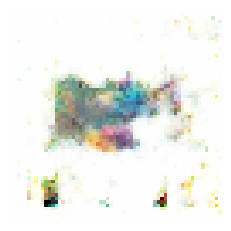

epoch 419
0.09475613385438919 6.451786041259766


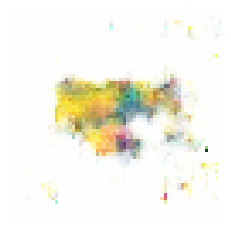

epoch 420
0.21127422104473226 11.181798934936523


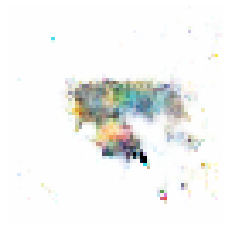

epoch 421
0.11755615472793579 6.374663352966309


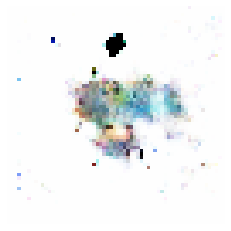

epoch 422
0.07748191524296999 5.5679931640625


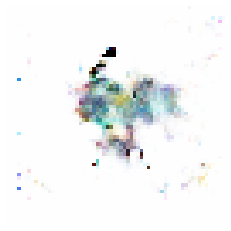

epoch 423
0.07260309159755707 5.170562744140625


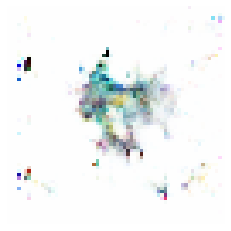

epoch 424
0.06473032757639885 6.2728400230407715


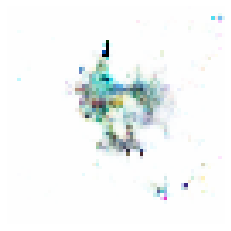

epoch 425
0.0469411532394588 5.9203715324401855


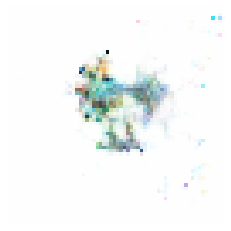

epoch 426
0.04761135671287775 5.675560474395752


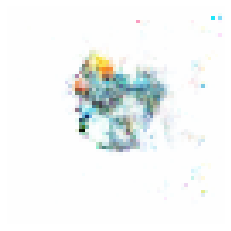

epoch 427
0.09621642902493477 5.774890899658203


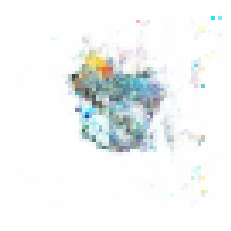

epoch 428
0.06059432774782181 5.608885288238525


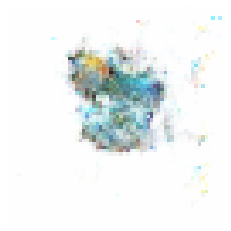

epoch 429
0.06627119705080986 5.677596092224121


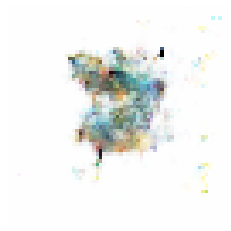

epoch 430
0.10482755675911903 6.796622276306152


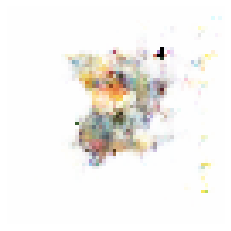

epoch 431
0.07841530069708824 6.622988224029541


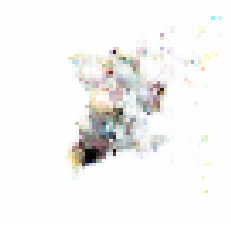

epoch 432
0.10875614732503891 6.937396049499512


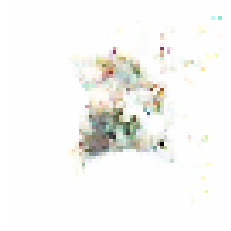

epoch 433
0.05014124512672424 5.900233268737793


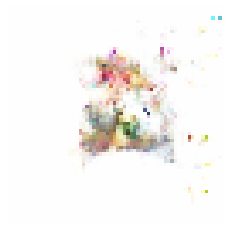

epoch 434
0.055946276523172855 5.780036926269531


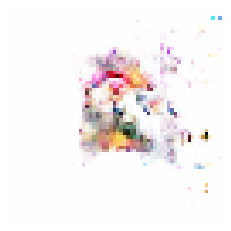

epoch 435
0.06690447474829853 7.636285781860352


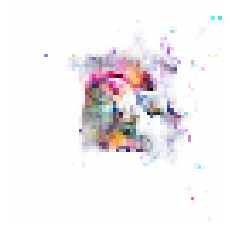

epoch 436
0.07656040787696838 7.012652397155762


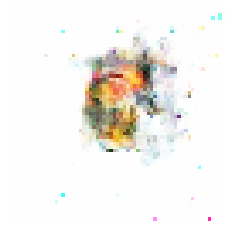

epoch 437
0.07382921129465103 6.63798713684082


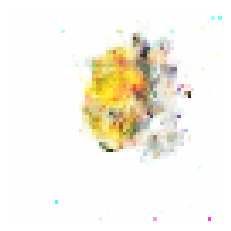

epoch 438
0.07163011282682419 6.62813663482666


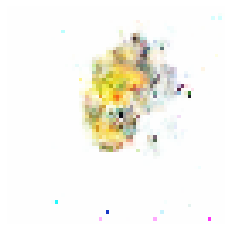

epoch 439
0.06494244188070297 6.235567092895508


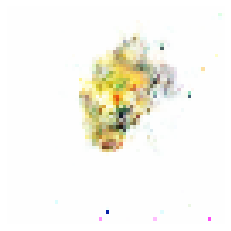

epoch 440
0.056285496801137924 5.714726448059082


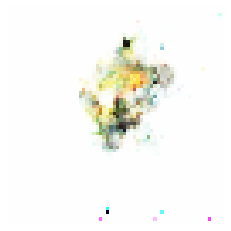

epoch 441
0.030436767265200615 5.837425231933594


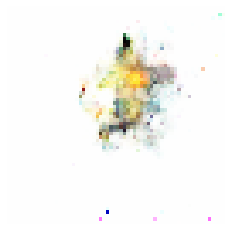

epoch 442
0.03614313155412674 5.608599662780762


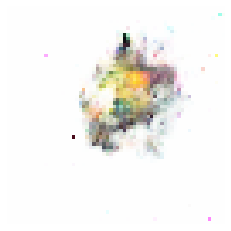

epoch 443
0.047107141464948654 5.3968305587768555


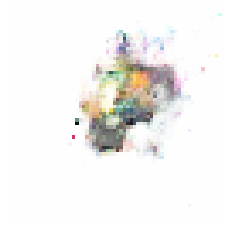

epoch 444
0.03324060142040253 5.937112331390381


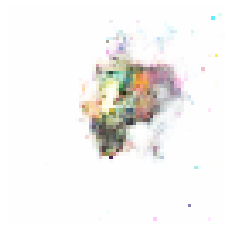

epoch 445
0.04353663232177496 6.114836692810059


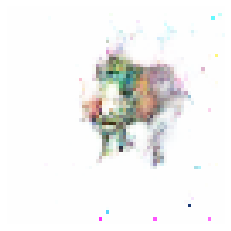

epoch 446
0.053080261684954166 5.85211181640625


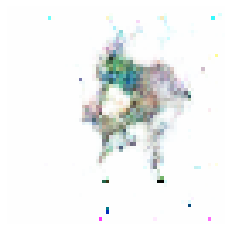

epoch 447
0.04566508252173662 6.9981889724731445


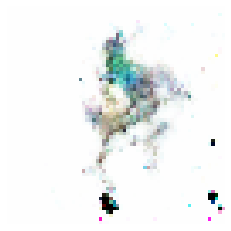

epoch 448
0.07798884809017181 8.156351089477539


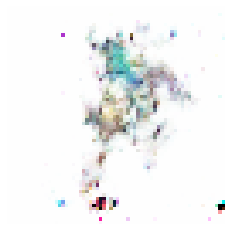

epoch 449
0.05558392405509949 7.10960578918457


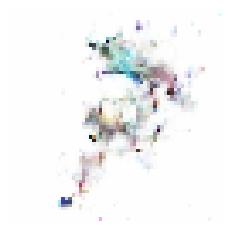

epoch 450
0.04977431986480951 6.494322776794434


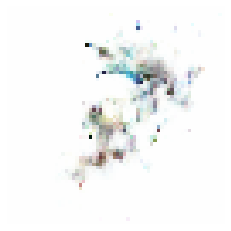

epoch 451
0.03575144335627556 6.967803955078125


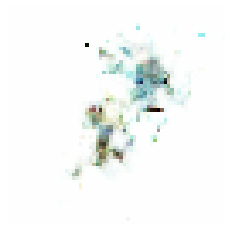

epoch 452
0.06512273289263248 6.685676574707031


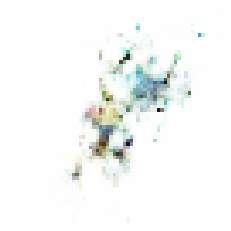

epoch 453
0.04745323024690151 6.7589802742004395


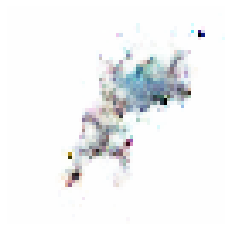

epoch 454
0.04933580942451954 5.436038017272949


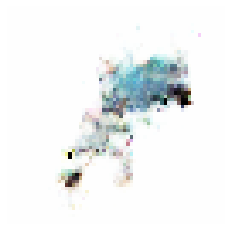

epoch 455
0.027743572951294482 7.57649040222168


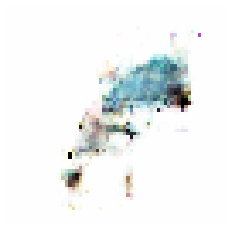

epoch 456
0.02380083128809929 6.608096122741699


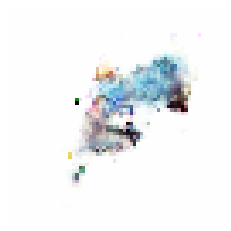

epoch 457
0.02767687663435936 6.248637676239014


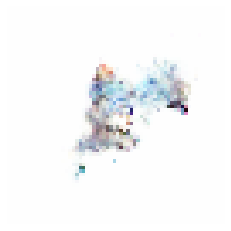

epoch 458
0.026075780391693115 5.988162040710449


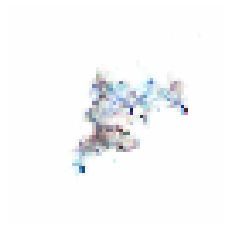

epoch 459
0.0631189662963152 6.667932987213135


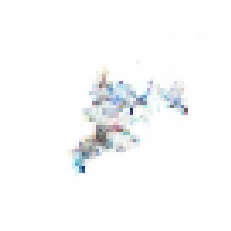

epoch 460
0.037051474675536156 6.923638343811035


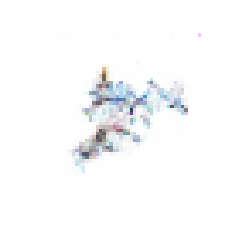

epoch 461
0.027479900047183037 7.337568283081055


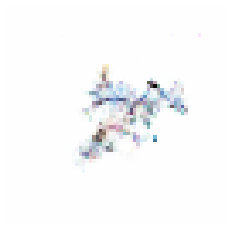

epoch 462
0.020490383729338646 6.325067520141602


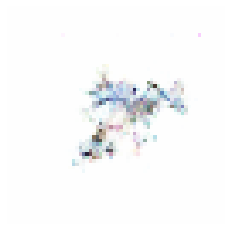

epoch 463
0.04333677748218179 6.214097023010254


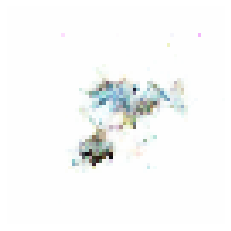

epoch 464
0.0450337678194046 6.822039604187012


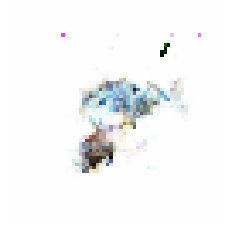

epoch 465
0.06145578436553478 6.40948486328125


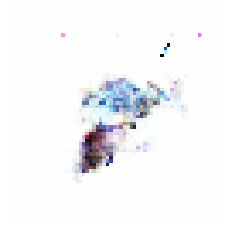

epoch 466
0.040261453948915005 7.910397052764893


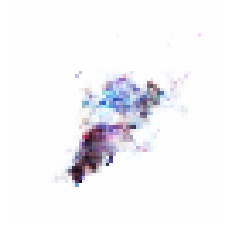

epoch 467
0.0572951752692461 7.142228126525879


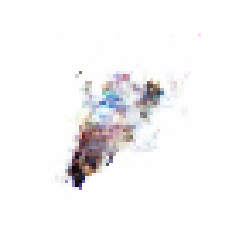

epoch 468
0.03687977232038975 5.906542778015137


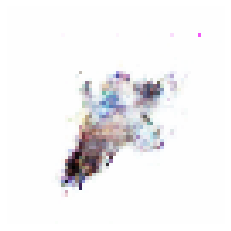

epoch 469
0.032791015692055225 6.711550712585449


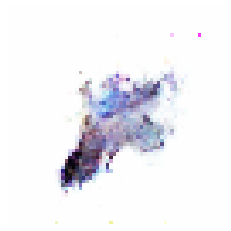

epoch 470
0.07133807986974716 6.690349578857422


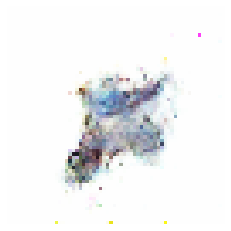

epoch 471
0.027741853147745132 7.127456188201904


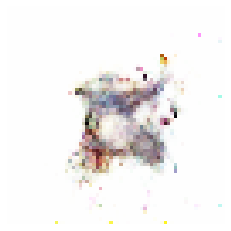

epoch 472
0.020686832256615162 6.74613094329834


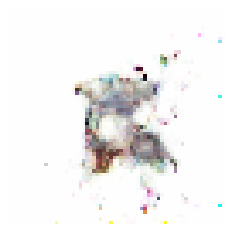

epoch 473
0.010697852354496717 7.046136379241943


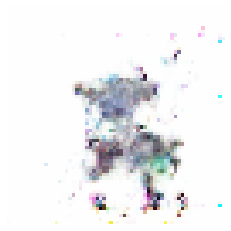

epoch 474
0.025074690580368042 7.084012508392334


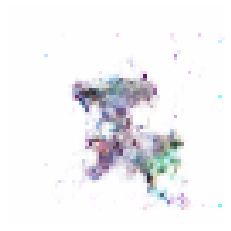

epoch 475
0.04230855777859688 8.66443920135498


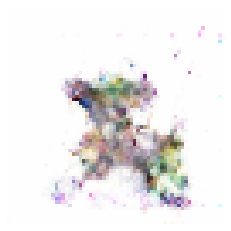

epoch 476
0.03332606237381697 7.7827959060668945


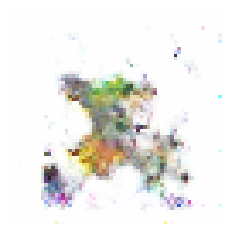

epoch 477
0.041836727410554886 7.7787981033325195


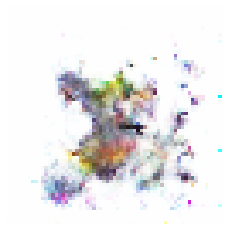

epoch 478
0.014605839736759663 6.418613433837891


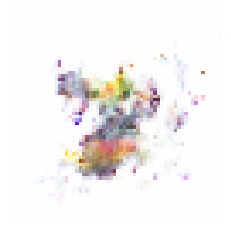

epoch 479
0.050202496349811554 8.145225524902344


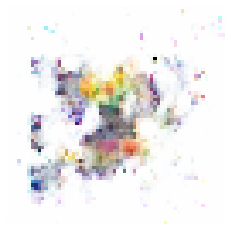

epoch 480
0.02661750838160515 7.4258270263671875


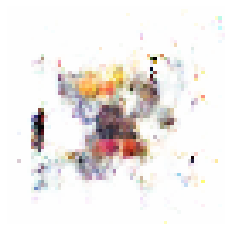

epoch 481
0.045012932270765305 9.587636947631836


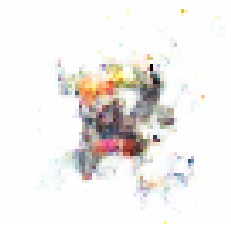

epoch 482
0.02462654933333397 6.9303436279296875


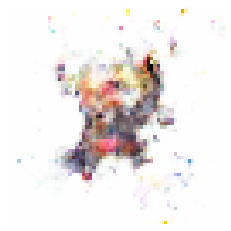

epoch 483
0.04161842726171017 8.723550796508789


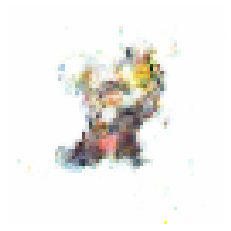

epoch 484
0.019601093605160713 7.010684967041016


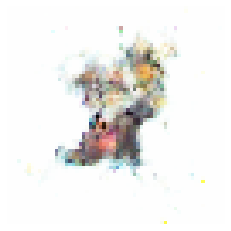

epoch 485
0.0495077702216804 11.89541244506836


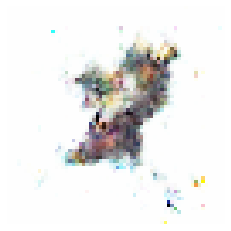

epoch 486
0.09581667557358742 9.908782958984375


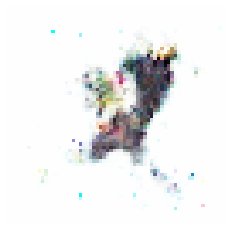

epoch 487
0.02156273159198463 7.1636176109313965


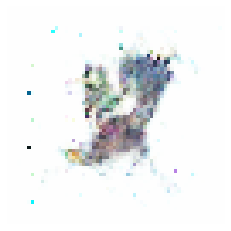

epoch 488
0.0262757521122694 7.737824440002441


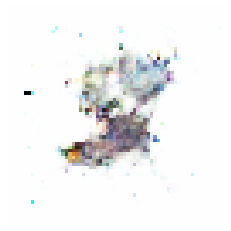

epoch 489
0.029132001101970673 6.615400314331055


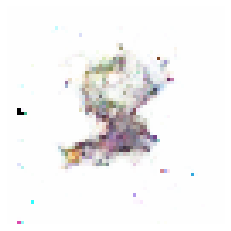

epoch 490
0.05002775741741061 5.472496032714844


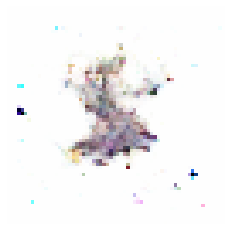

epoch 491
0.014737114775925875 7.292985916137695


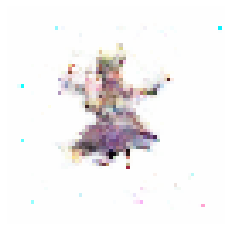

epoch 492
0.007785774534568191 8.13363265991211


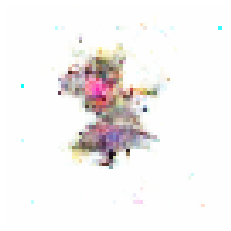

epoch 493
0.017367723397910595 6.085402011871338


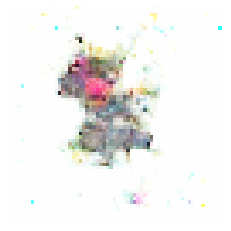

epoch 494
0.009199247695505619 8.92426872253418


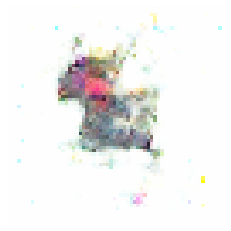

epoch 495
0.011593198869377375 7.19677209854126


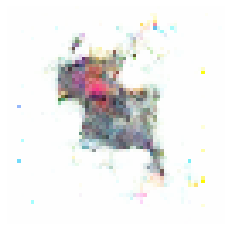

epoch 496
0.012662116438150406 7.129388332366943


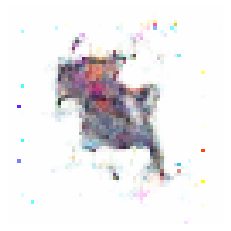

epoch 497
0.01697031781077385 8.456029891967773


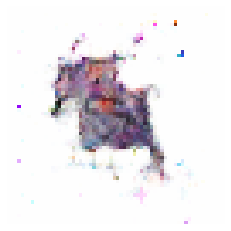

epoch 498
0.02394441980868578 8.107481002807617


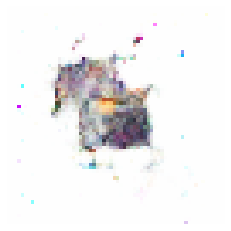

epoch 499
0.023396841250360012 7.251473903656006


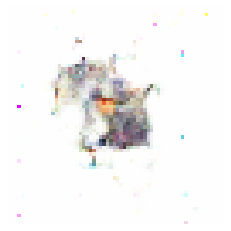

epoch 500
0.0216590603813529 7.474120616912842


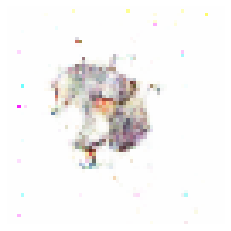

epoch 501
0.005911565967835486 7.374011993408203


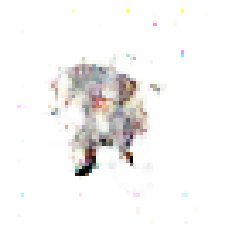

epoch 502
0.015644182916730642 7.877880096435547


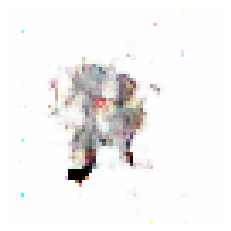

epoch 503
0.013955548871308565 6.991442680358887


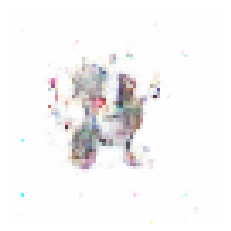

epoch 504
0.011207583826035261 7.707437992095947


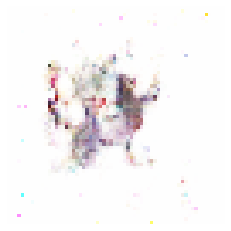

epoch 505
0.0123266177251935 7.342902183532715


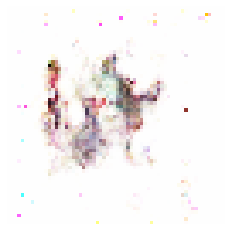

epoch 506
0.012750778114423156 6.883468151092529


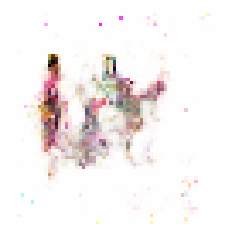

epoch 507
0.0042508898768574 7.256819725036621


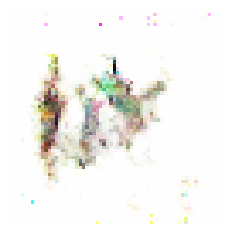

epoch 508
0.012320129200816154 7.874976634979248


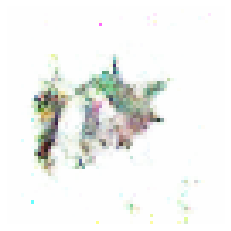

epoch 509
0.011895253788679838 7.701633453369141


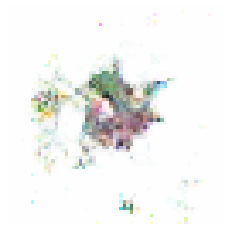

epoch 510
0.010968598071485758 7.854438304901123


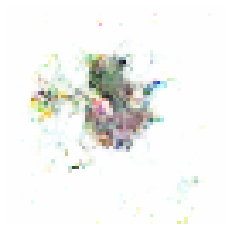

epoch 511
0.01963788247667253 7.9139814376831055


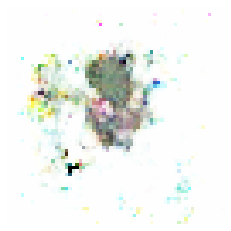

epoch 512
0.018815454735886306 7.001491546630859


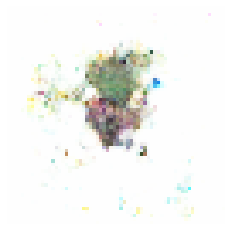

epoch 513
0.011462248861789703 8.268256187438965


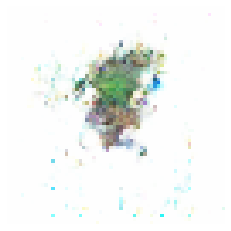

epoch 514
0.024831343442201614 8.227598190307617


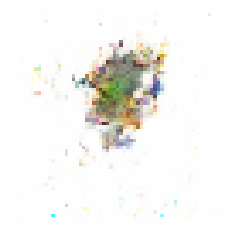

epoch 515
0.048101628199219704 12.212773323059082


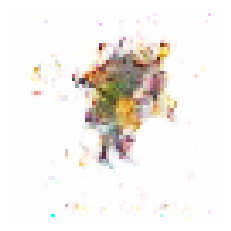

epoch 516
0.030199792701750994 7.665027141571045


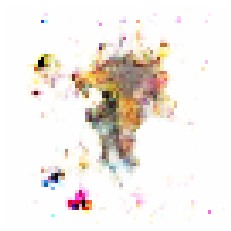

epoch 517
0.02080028597265482 9.248348236083984


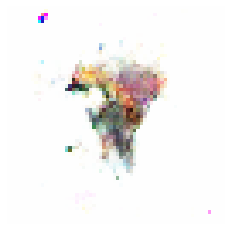

epoch 518
0.005699125351384282 8.296016693115234


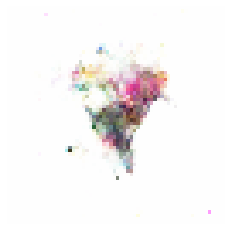

epoch 519
0.015411654487252235 7.166066646575928


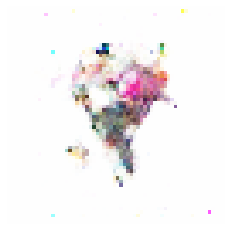

epoch 520
0.0018733546021394432 8.22173023223877


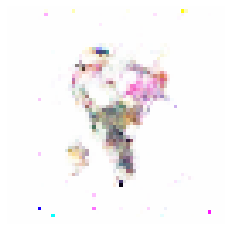

epoch 521
0.011944278609007597 8.186593055725098


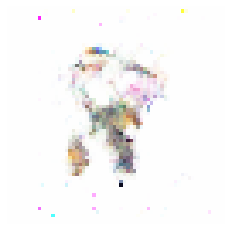

epoch 522
0.004605302587151527 7.066685199737549


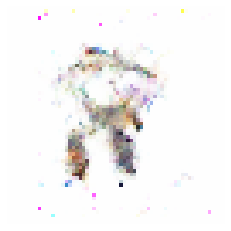

epoch 523
0.004735101712867618 8.621206283569336


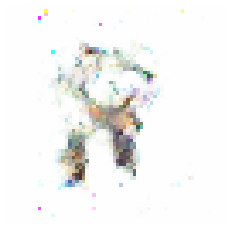

epoch 524
0.013432757463306189 8.06328010559082


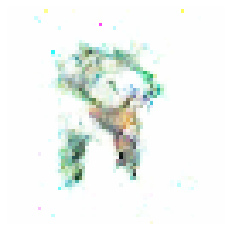

epoch 525
0.011795033235102892 7.589730739593506


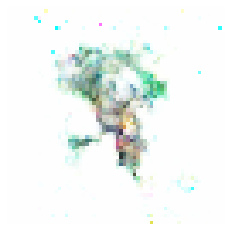

epoch 526
0.04486820101737976 13.918590545654297


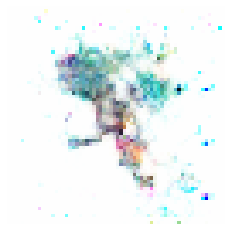

epoch 527
0.030319398269057274 8.069783210754395


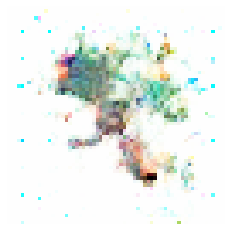

epoch 528
0.062156641855835915 13.896536827087402


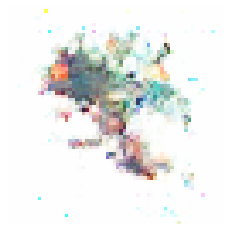

epoch 529
0.006689475383609533 6.265334129333496


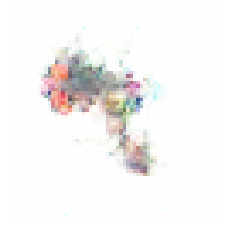

epoch 530
0.004574676975607872 8.375100135803223


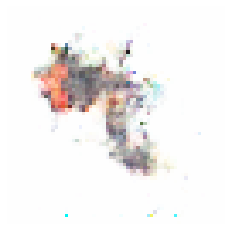

epoch 531
0.044003876857459545 9.136056900024414


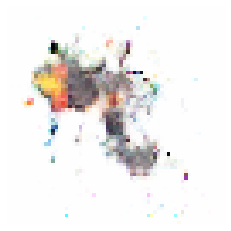

epoch 532
0.006696950062178075 9.743688583374023


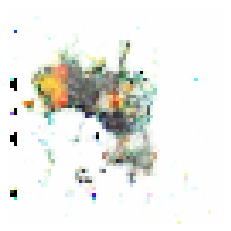

epoch 533
0.01091663702391088 10.807304382324219


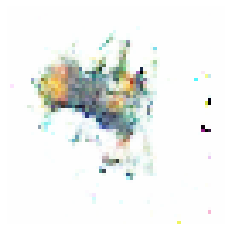

epoch 534
0.03298385161906481 10.400757789611816


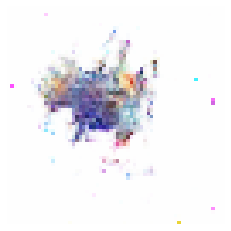

epoch 535
0.01728872477542609 7.704129219055176


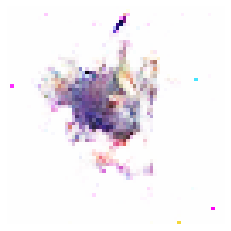

epoch 536
0.0027323647518642247 7.755351543426514


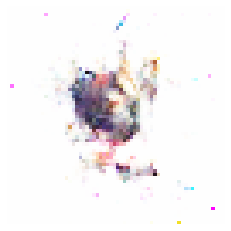

epoch 537
0.008720173183974111 12.960030555725098


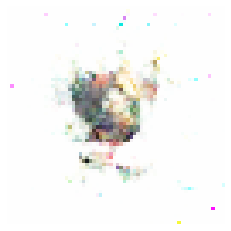

epoch 538
0.003037102273083292 8.28089427947998


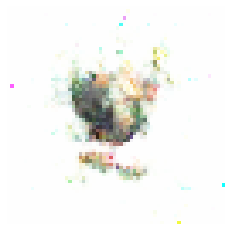

epoch 539
0.005040451884269714 7.6266069412231445


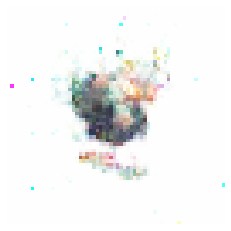

epoch 540
0.018467579036951065 9.56419563293457


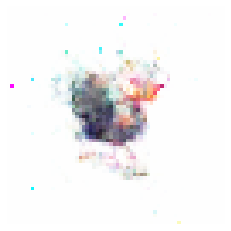

epoch 541
0.019592479337006807 8.220365524291992


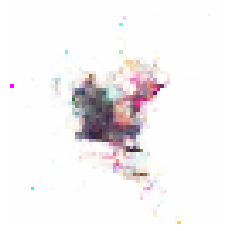

epoch 542
0.007956285029649734 7.452572345733643


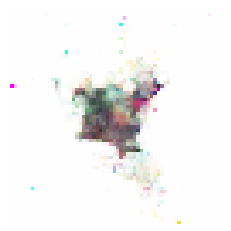

epoch 543
0.0020965017611160874 7.76659631729126


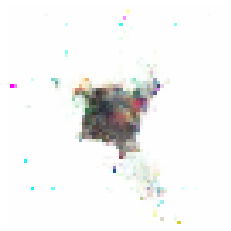

epoch 544
0.011610108311288059 8.790943145751953


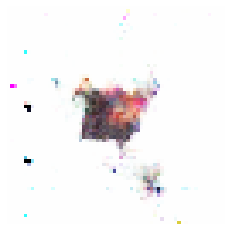

epoch 545
0.006991614354774356 8.141326904296875


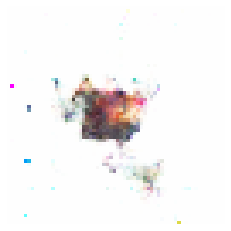

epoch 546
0.0053994543850421906 8.905012130737305


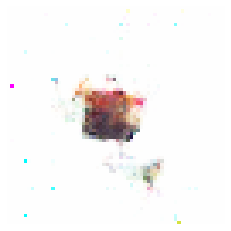

epoch 547
0.003831869224086404 8.87797737121582


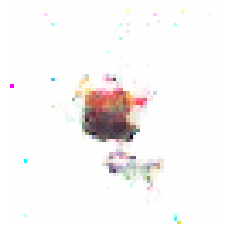

epoch 548
0.0010945209360215813 8.964365005493164


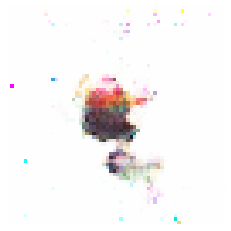

epoch 549
0.0030928029445931315 9.526334762573242


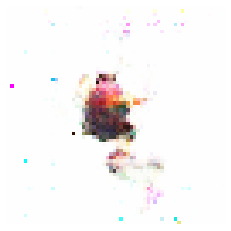

epoch 550
0.0031350849894806743 8.68111801147461


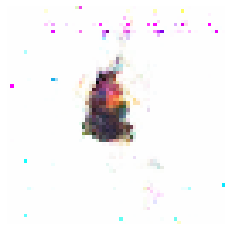

epoch 551
0.0036204542266204953 7.877167224884033


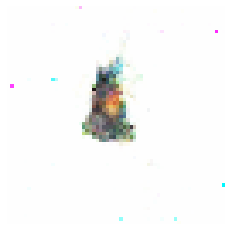

epoch 552
0.0020988219184800982 7.933447360992432


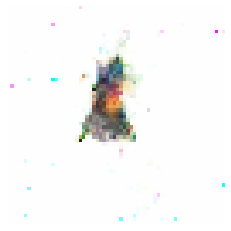

epoch 553
0.009739215485751629 7.000022888183594


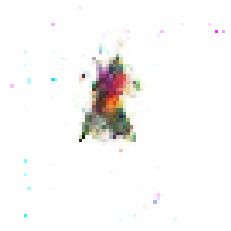

epoch 554
0.004749795189127326 8.302970886230469


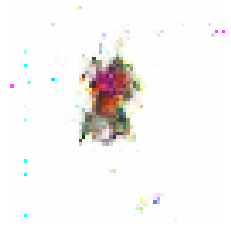

epoch 555
0.004046323825605214 8.029193878173828


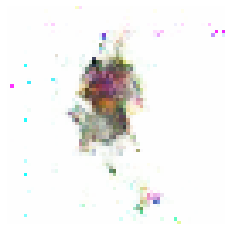

epoch 556
0.0013680908305104822 9.507192611694336


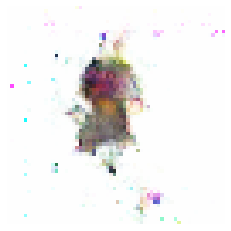

epoch 557
0.003805853397352621 9.809600830078125


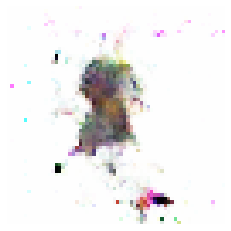

epoch 558
0.006760882446542382 8.088322639465332


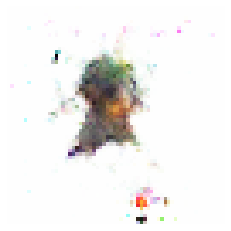

epoch 559
0.004554415587335825 8.279184341430664


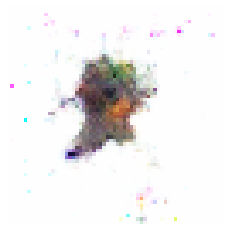

epoch 560
0.007447042036801577 7.313651084899902


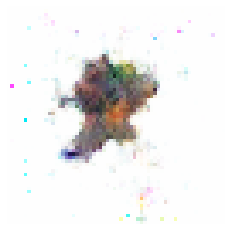

epoch 561
0.0026777080493047833 8.860823631286621


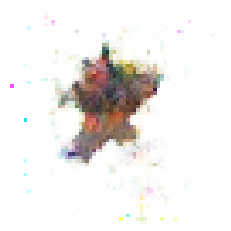

epoch 562
0.0020324023789726198 8.284252166748047


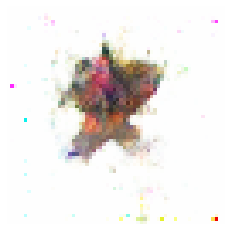

epoch 563
0.004986915737390518 7.87296199798584


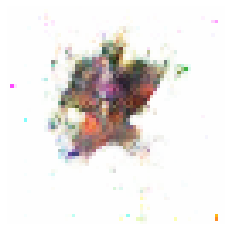

epoch 564
0.0017219685832969844 8.531286239624023


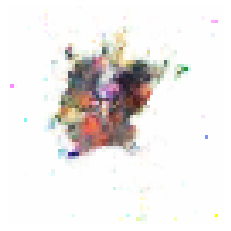

epoch 565
0.0033674309961497784 8.91551685333252


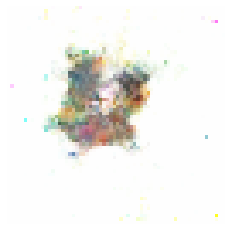

epoch 566
0.0021637085592374206 9.023914337158203


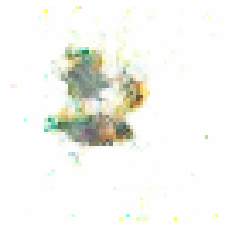

epoch 567
0.15778509234243643 15.955991744995117


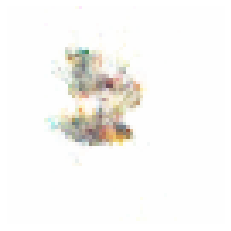

epoch 568
0.002014869314734824 8.884889602661133


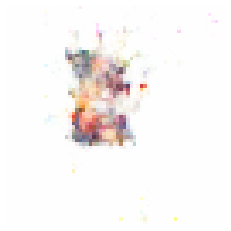

epoch 569
0.0029241988668218255 9.667570114135742


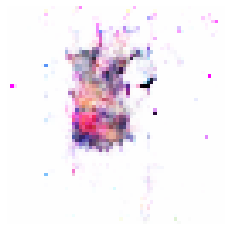

epoch 570
0.0016188959707506 9.48822021484375


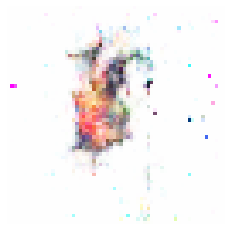

epoch 571
0.014120632084086537 8.407554626464844


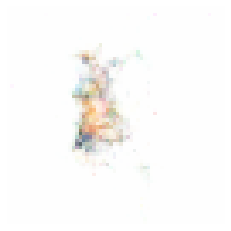

epoch 572
0.004251362872309983 8.905678749084473


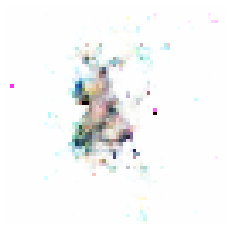

epoch 573
0.009582600556313992 9.259557723999023


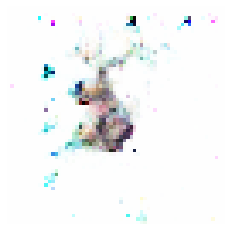

epoch 574
0.014340533874928951 10.15519905090332


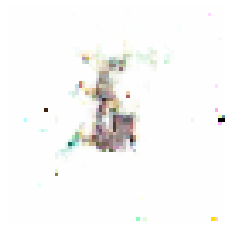

epoch 575
0.029485102684247977 15.959142684936523


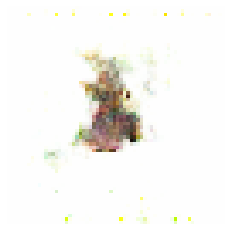

epoch 576
0.001650884805712849 9.370317459106445


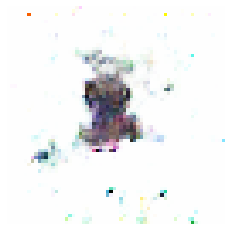

epoch 577
0.033878598231240176 12.834708213806152


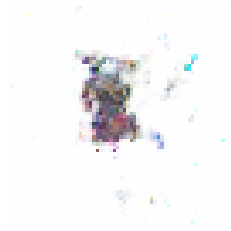

epoch 578
0.0007873440918046981 9.445216178894043


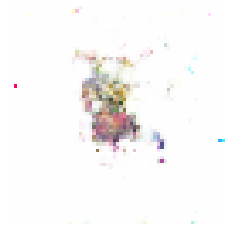

epoch 579
0.006114918505772948 8.61199951171875


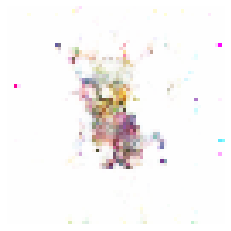

epoch 580
0.0140040471451357 13.400747299194336


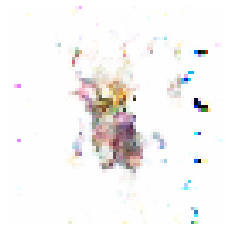

epoch 581
0.0037534584989771247 8.06029987335205


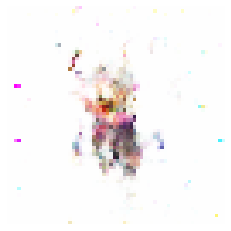

epoch 582
0.009263499989174306 8.694305419921875


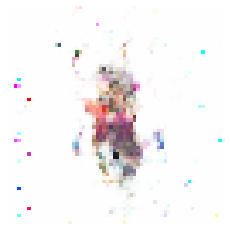

epoch 583
0.009141894359345315 10.600257873535156


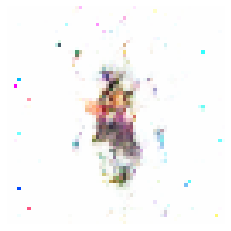

epoch 584
0.0014298453461378813 8.365392684936523


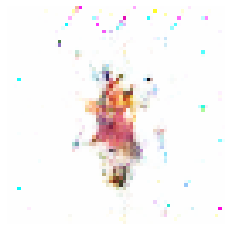

epoch 585
0.0008405941480305046 9.491288185119629


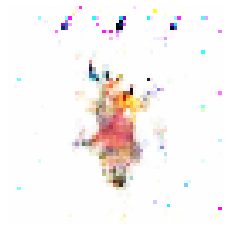

epoch 586
0.000321440449624788 11.275379180908203


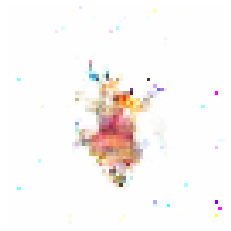

epoch 587
0.003345033328514546 9.146842956542969


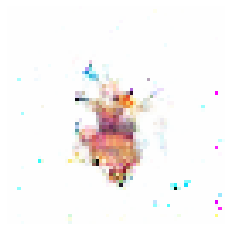

epoch 588
0.009987588506191969 8.136186599731445


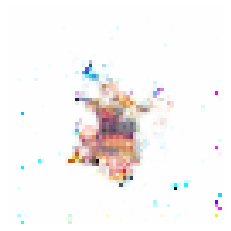

epoch 589
0.017720684176310897 7.994504928588867


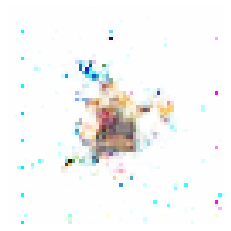

epoch 590
0.038180919364094734 11.997052192687988


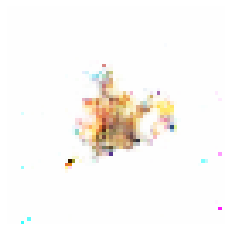

epoch 591
0.0012521874159574509 8.436491966247559


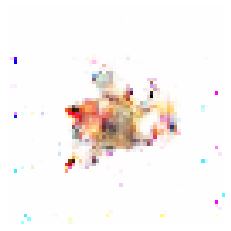

epoch 592
0.0057210520608350635 9.442925453186035


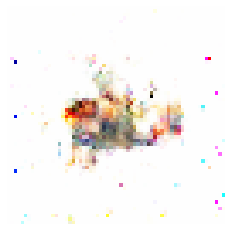

epoch 593
0.013575987177318893 11.432416915893555


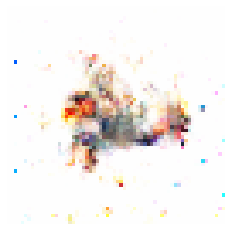

epoch 594
0.12463431712239981 68.76229095458984


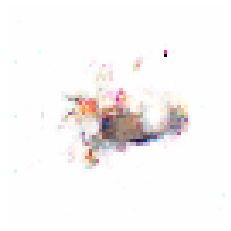

epoch 595
52.28761672973633 320.7008056640625


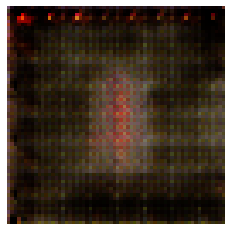

epoch 596
7.449697971344479 73.39236450195312


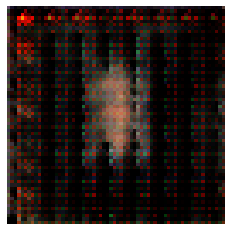

epoch 597
1.5493934750556946 62.7585334777832


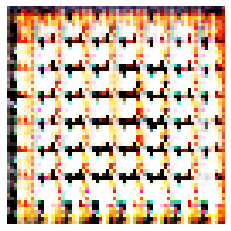

epoch 598
3.5855045318603516 21.537769317626953


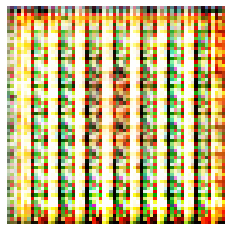

epoch 599
14.656391143798828 64.65989685058594


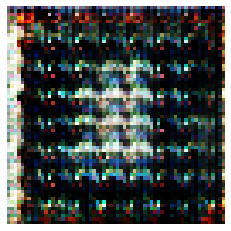

epoch 600
15.586235523223877 41.39292907714844


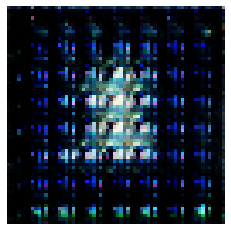

epoch 601
1.480604201555252 26.846818923950195


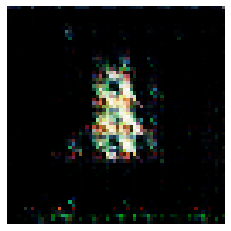

epoch 602
3.221664845943451 19.613643646240234


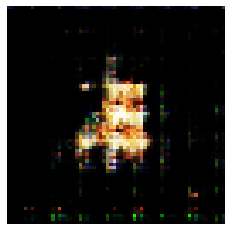

epoch 603
1.8099231123924255 20.37277603149414


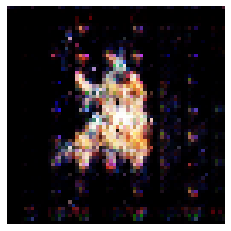

epoch 604
3.7336238622665405 21.423511505126953


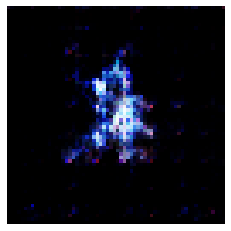

epoch 605
1.9928602576255798 15.570738792419434


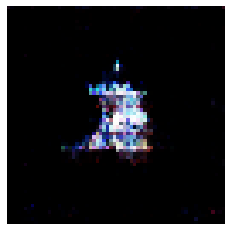

epoch 606
1.8342809677124023 14.616449356079102


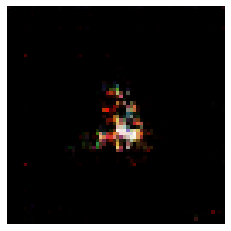

epoch 607
1.3058397769927979 13.322086334228516


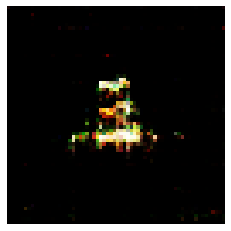

epoch 608
1.1693542674183846 15.022979736328125


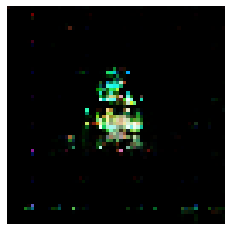

epoch 609
1.7148687243461609 16.684146881103516


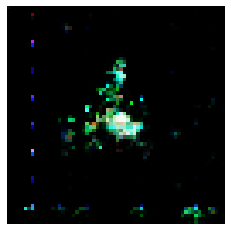

epoch 610
1.6460880637168884 13.033604621887207


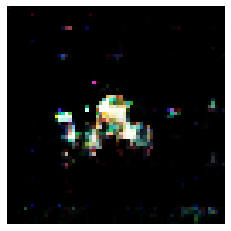

epoch 611
1.1951839923858643 18.19367027282715


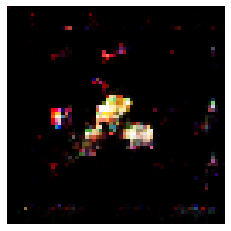

epoch 612
1.0381278693675995 10.823543548583984


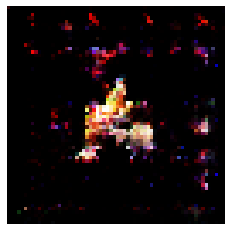

epoch 613
1.6121135354042053 8.954853057861328


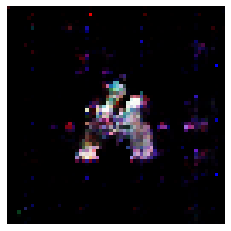

epoch 614
0.6414966583251953 10.989474296569824


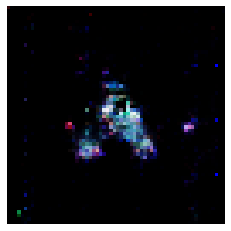

epoch 615
1.060668259859085 12.483400344848633


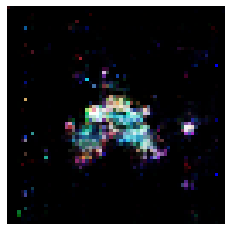

epoch 616
1.052089512348175 11.530197143554688


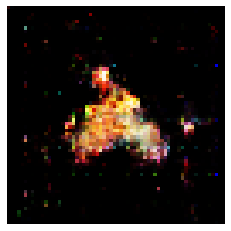

epoch 617
1.988694667816162 12.449411392211914


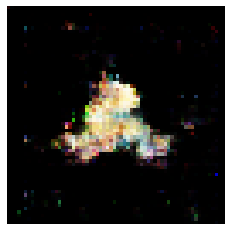

epoch 618
1.1246525049209595 8.720199584960938


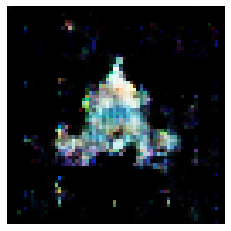

epoch 619
0.6763541400432587 8.302390098571777


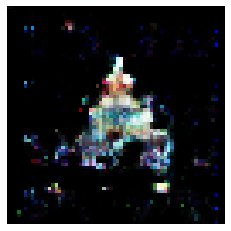

epoch 620
0.7156533598899841 8.489377975463867


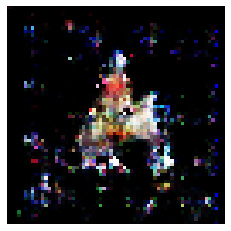

epoch 621
0.653049424290657 10.450687408447266


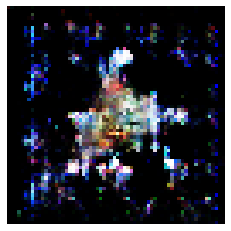

epoch 622
1.7020065784454346 9.709498405456543


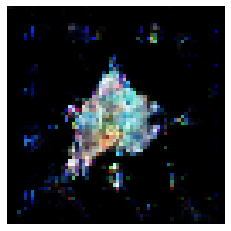

epoch 623
0.8652610182762146 6.8395233154296875


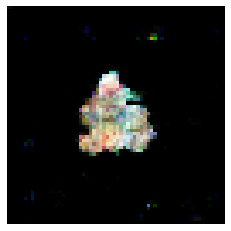

epoch 624
0.8393255770206451 9.443994522094727


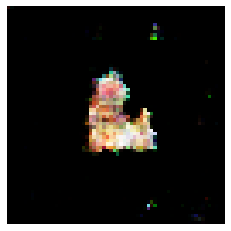

epoch 625
0.5354689359664917 8.655948638916016


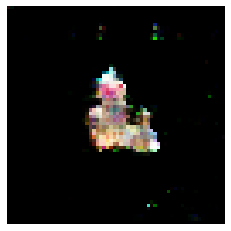

epoch 626
0.44889938831329346 8.656621932983398


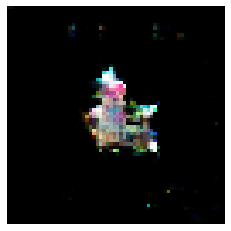

epoch 627
0.49949121475219727 8.469733238220215


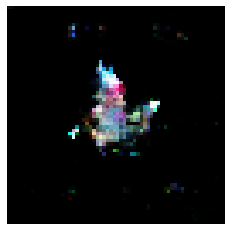

epoch 628
0.3695879280567169 8.20443058013916


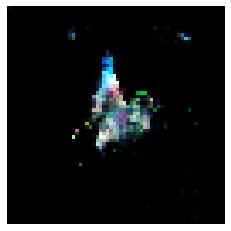

epoch 629
0.5080914497375488 9.223758697509766


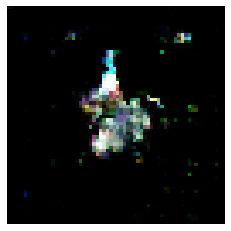

epoch 630
0.7168641686439514 9.130005836486816


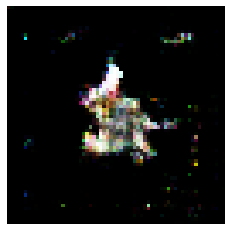

epoch 631
0.5060181021690369 6.910910129547119


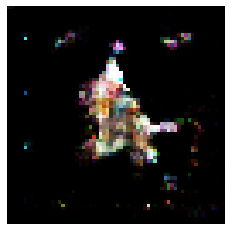

epoch 632
0.47532958537340164 8.395718574523926


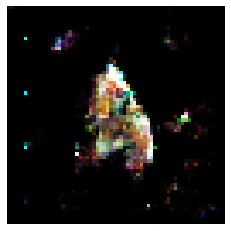

epoch 633
0.5012045353651047 8.36627197265625


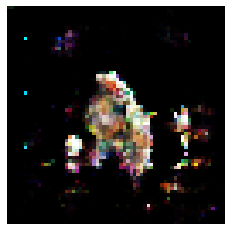

epoch 634
0.6505944207310677 6.637822151184082


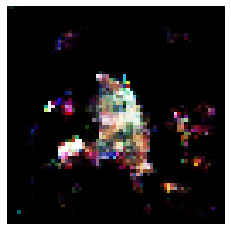

epoch 635
0.553318202495575 8.784114837646484


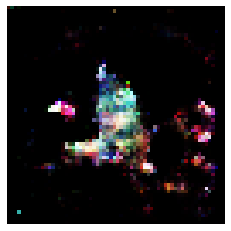

epoch 636
0.3674442768096924 8.549962997436523


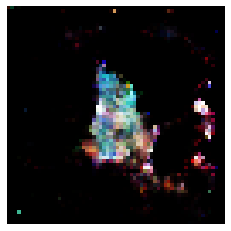

epoch 637
0.9611715078353882 8.20147705078125


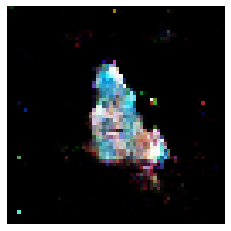

epoch 638
0.38850370049476624 7.170135498046875


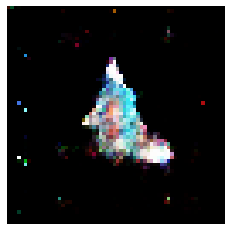

epoch 639
0.2682052403688431 7.04403018951416


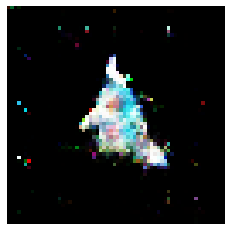

epoch 640
0.9550397396087646 11.996562957763672


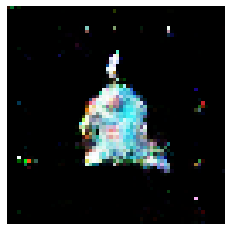

epoch 641
0.7870481610298157 8.740325927734375


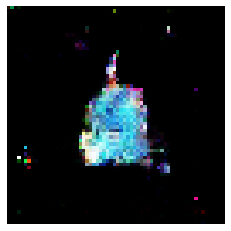

epoch 642
1.1194626092910767 8.5535249710083


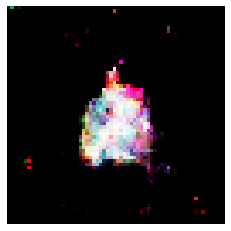

epoch 643
0.9746451079845428 9.095996856689453


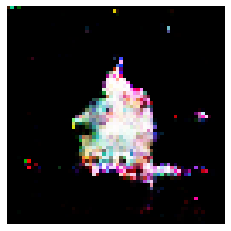

epoch 644
1.5727902054786682 10.950910568237305


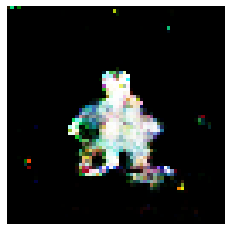

epoch 645
0.6863775849342346 10.626913070678711


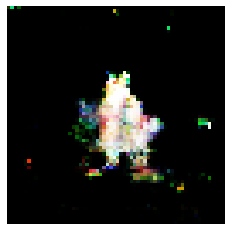

epoch 646
0.8515406847000122 7.710637092590332


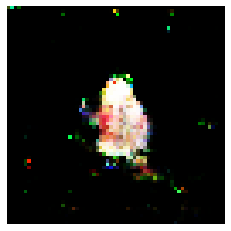

epoch 647
0.6776593923568726 7.691998481750488


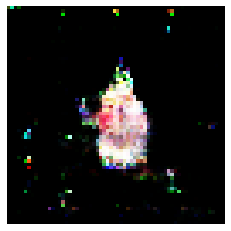

epoch 648
0.6022479236125946 6.299050331115723


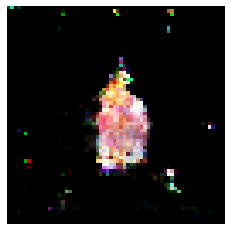

epoch 649
0.6345028877258301 6.962594985961914


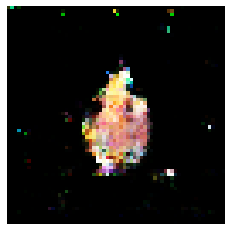

epoch 650
0.8505436480045319 9.235116958618164


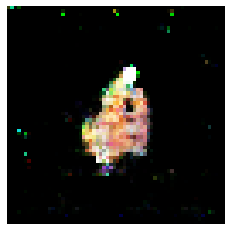

epoch 651
0.7360609769821167 10.879125595092773


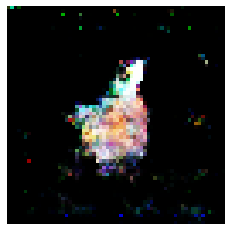

epoch 652
0.39693059027194977 9.062446594238281


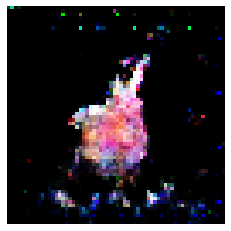

epoch 653
0.46580419689416885 8.51115894317627


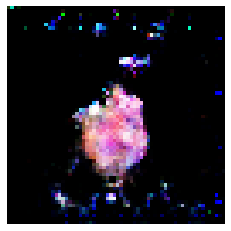

epoch 654
0.4326205402612686 7.752686500549316


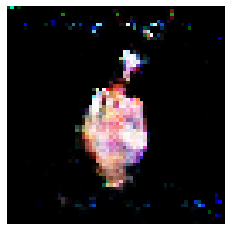

epoch 655
0.4102383702993393 8.72562313079834


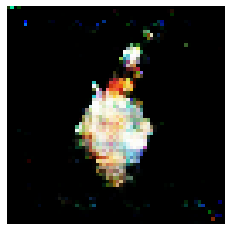

epoch 656
0.5832021236419678 8.508549690246582


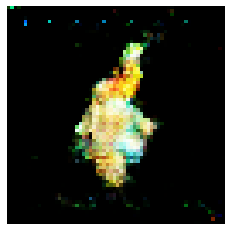

epoch 657
0.40302983904257417 9.082697868347168


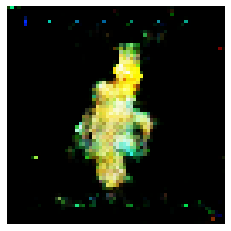

epoch 658
0.38715723156929016 8.293007850646973


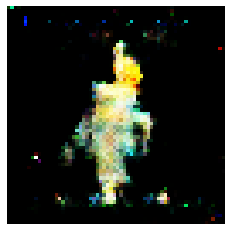

epoch 659
0.4206550046801567 6.391557216644287


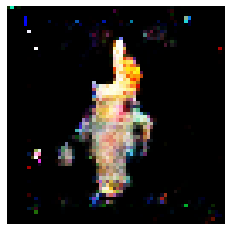

epoch 660
0.35255177319049835 9.062862396240234


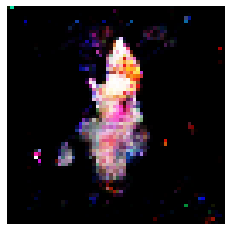

epoch 661
0.4115910679101944 7.9177045822143555


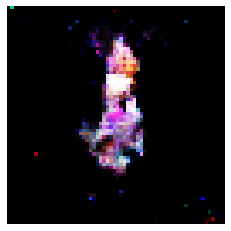

epoch 662
0.35999536514282227 10.329888343811035


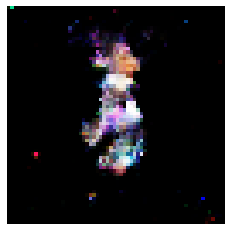

epoch 663
0.7334334552288055 14.303327560424805


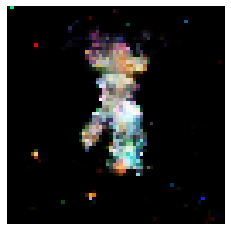

epoch 664
0.6237313747406006 8.290165901184082


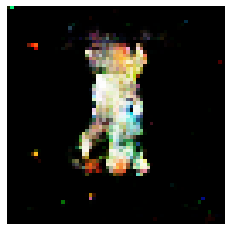

epoch 665
0.5509692132472992 10.008071899414062


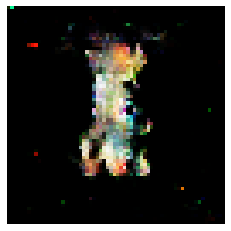

epoch 666
0.28463536500930786 7.185859203338623


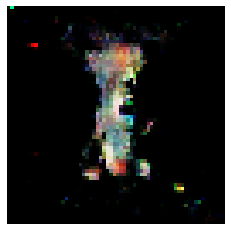

epoch 667
0.5184064209461212 10.570746421813965


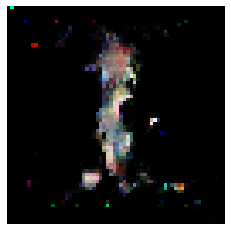

epoch 668
0.3135247230529785 7.104438781738281


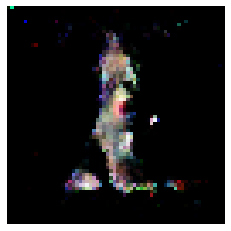

epoch 669
0.5213195085525513 8.377277374267578


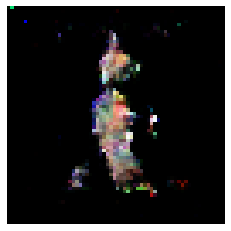

epoch 670
0.36508993059396744 6.703549385070801


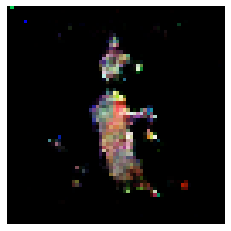

epoch 671
0.3788142651319504 8.668390274047852


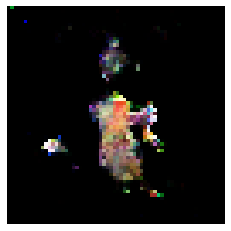

epoch 672
0.39625801891088486 7.097593307495117


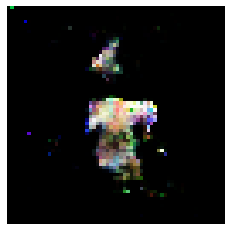

epoch 673
0.2176969051361084 7.465614318847656


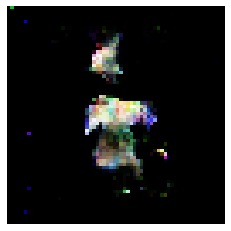

epoch 674
0.1847085803747177 7.241198539733887


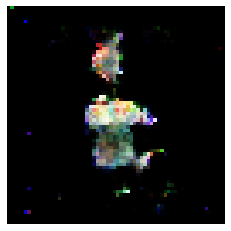

epoch 675
0.1801183931529522 7.233510494232178


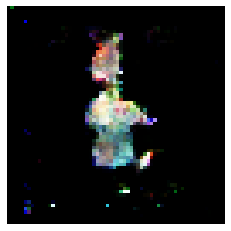

epoch 676
0.23265163600444794 7.729557037353516


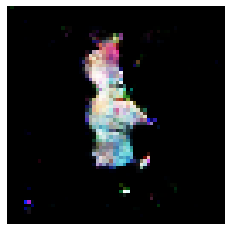

epoch 677
0.3442448526620865 7.769192695617676


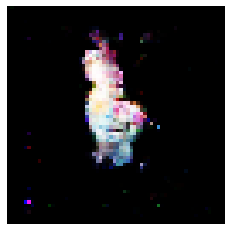

epoch 678
0.26170286536216736 8.737375259399414


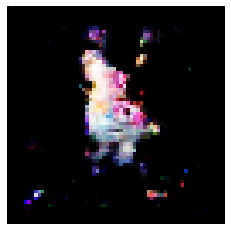

epoch 679
0.39418044686317444 10.756258964538574


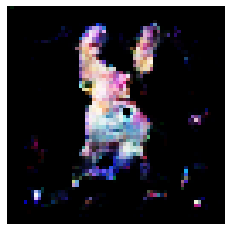

epoch 680
0.550919234752655 10.08568000793457


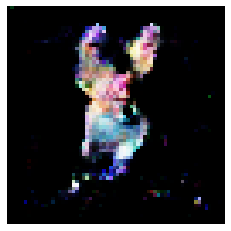

epoch 681
0.33036600798368454 7.325313568115234


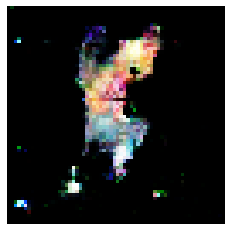

epoch 682
0.21480269730091095 7.6096696853637695


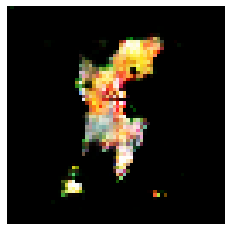

epoch 683
0.08340629190206528 7.995665550231934


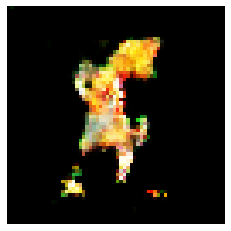

epoch 684
0.1395876295864582 7.884721279144287


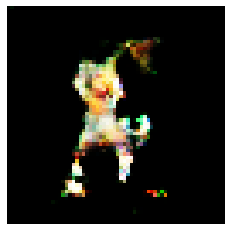

epoch 685
0.7341305613517761 13.00417709350586


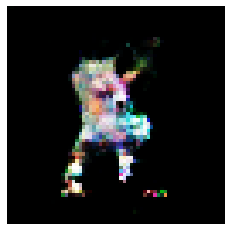

epoch 686
0.32452504336833954 8.760963439941406


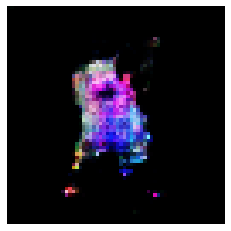

epoch 687
0.22531913220882416 9.136962890625


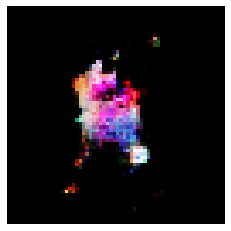

epoch 688
0.12713731545954943 9.635110855102539


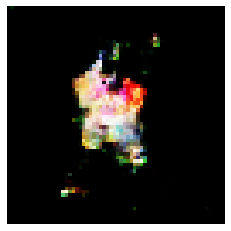

epoch 689
0.14946799539029598 7.318333148956299


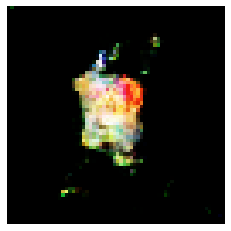

epoch 690
0.24445682764053345 8.458776473999023


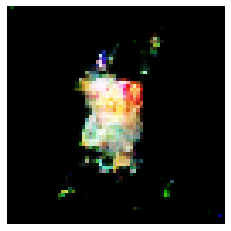

epoch 691
0.32668890058994293 7.031221389770508


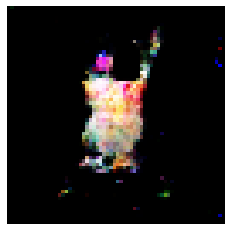

epoch 692
0.2217259779572487 7.620125770568848


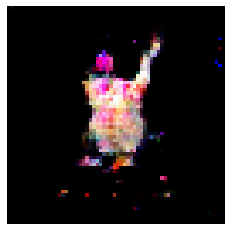

epoch 693
0.30487095564603806 8.043739318847656


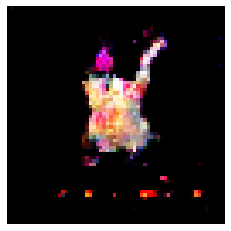

epoch 694
0.2170671671628952 8.296747207641602


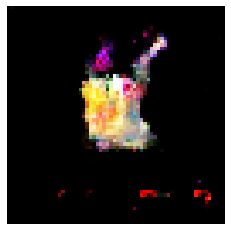

epoch 695
0.2966987043619156 7.477541923522949


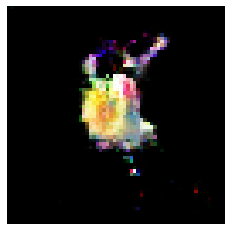

epoch 696
0.3271002024412155 7.85103702545166


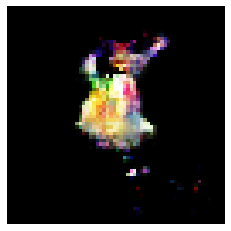

epoch 697
0.198824904859066 7.418455123901367


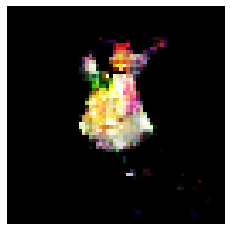

epoch 698
0.14724009111523628 7.534939765930176


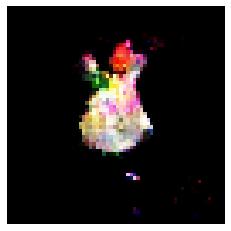

epoch 699
0.2231842279434204 8.399496078491211


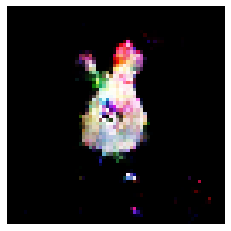

epoch 700
0.2272307574748993 9.032167434692383


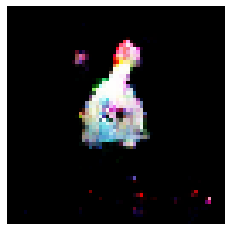

epoch 701
0.19577747583389282 9.754796028137207


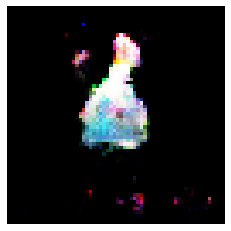

epoch 702
0.09625466912984848 9.577704429626465


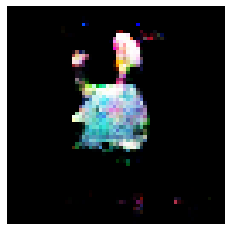

epoch 703
0.14717169106006622 7.984537124633789


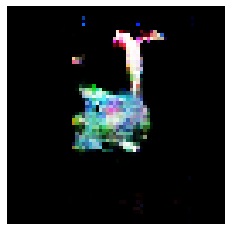

epoch 704
0.24071307480335236 7.622133255004883


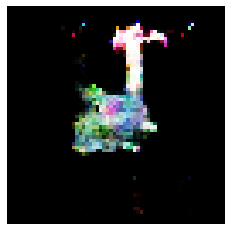

epoch 705
0.05909320339560509 8.02195930480957


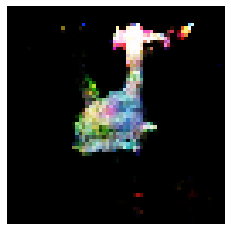

epoch 706
0.3183641582727432 9.773804664611816


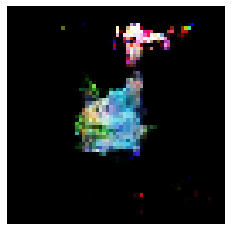

epoch 707
0.49206309020519257 12.266152381896973


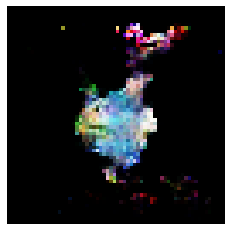

epoch 708
0.09812688082456589 7.487676620483398


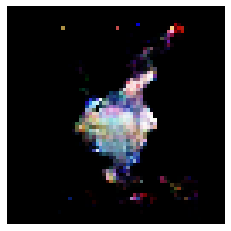

epoch 709
0.2883099988102913 7.963354110717773


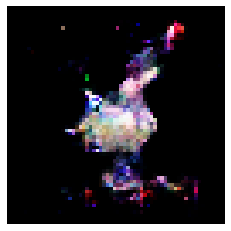

epoch 710
0.18667589128017426 9.679600715637207


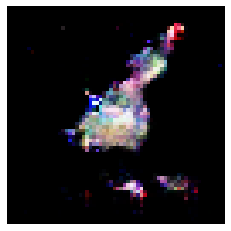

epoch 711
0.26161783933639526 10.011629104614258


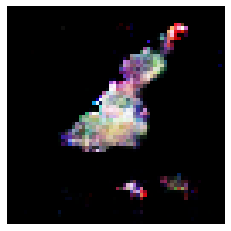

epoch 712
0.15613051503896713 8.791497230529785


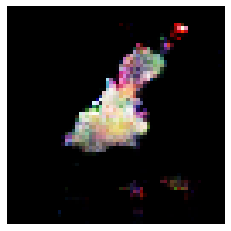

epoch 713
0.2281716763973236 7.606266021728516


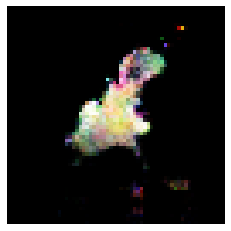

epoch 714
0.13100247085094452 7.7865705490112305


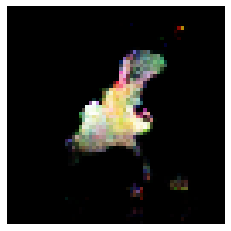

epoch 715
0.1901387684047222 6.297417163848877


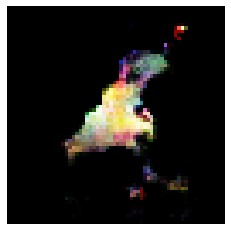

epoch 716
0.20418939739465714 8.227418899536133


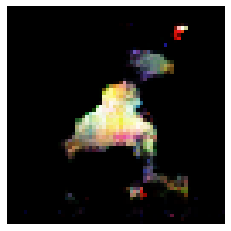

epoch 717
0.4380522668361664 11.537979125976562


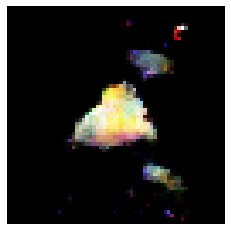

epoch 718
0.12630566209554672 8.509904861450195


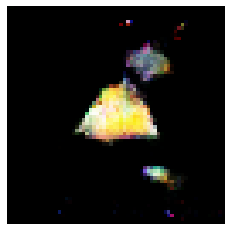

epoch 719
0.07424521446228027 7.246508598327637


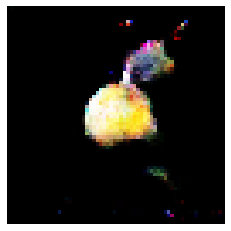

epoch 720
0.15061760321259499 8.108766555786133


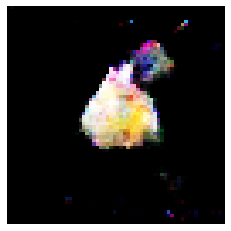

epoch 721
0.04317559860646725 8.704792976379395


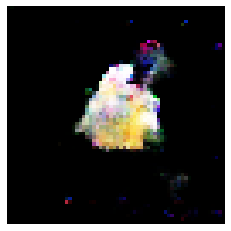

epoch 722
0.08694201707839966 8.457266807556152


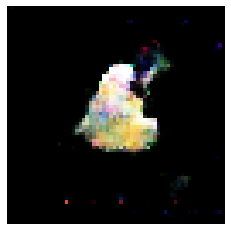

epoch 723
0.08739035204052925 8.075260162353516


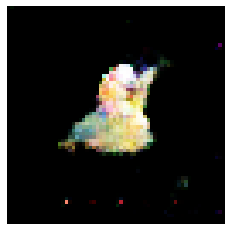

epoch 724
0.05527348816394806 7.645358085632324


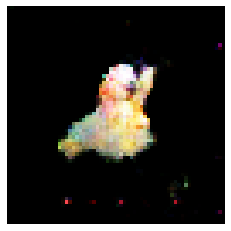

epoch 725
0.20654749125242233 9.65683650970459


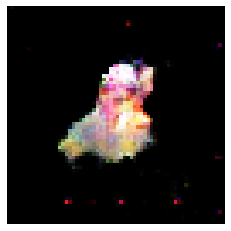

epoch 726
0.1039995588362217 8.308480262756348


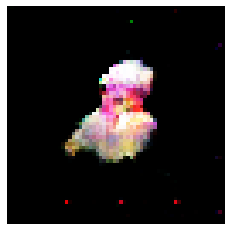

epoch 727
0.11025338619947433 7.206595420837402


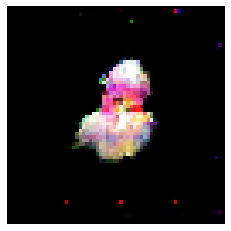

epoch 728
0.08200324326753616 8.01077651977539


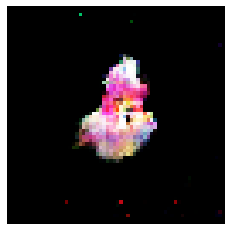

epoch 729
0.1229669451713562 7.691234588623047


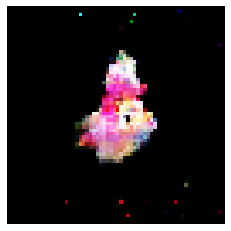

epoch 730
0.05978468991816044 8.94804573059082


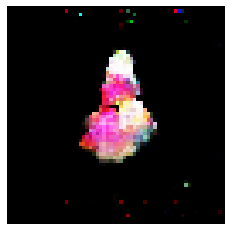

epoch 731
0.07379164732992649 8.947855949401855


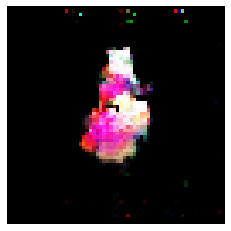

epoch 732
0.18530520051717758 10.001920700073242


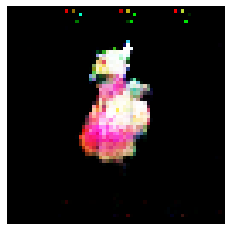

epoch 733
0.06230551935732365 7.558990478515625


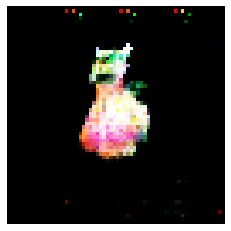

epoch 734
0.05734421219676733 7.910831928253174


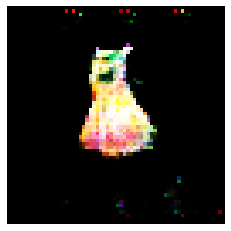

epoch 735
0.059295106679201126 8.65994644165039


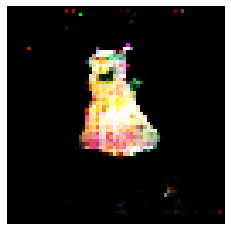

epoch 736
0.07116230763494968 8.014841079711914


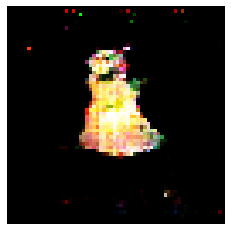

epoch 737
0.046955475583672523 8.919919967651367


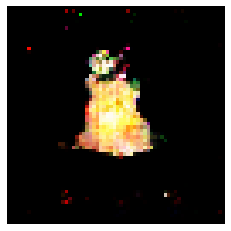

epoch 738
0.1656535118818283 9.481447219848633


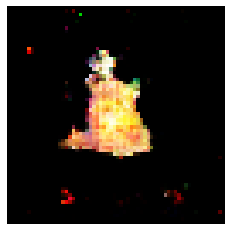

epoch 739
0.03342252876609564 8.54611873626709


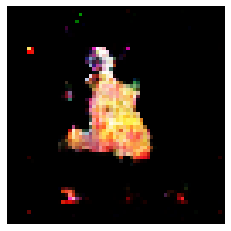

epoch 740
0.16578345745801926 9.139890670776367


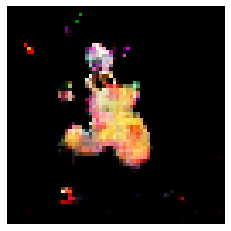

epoch 741
0.13118872791528702 8.882579803466797


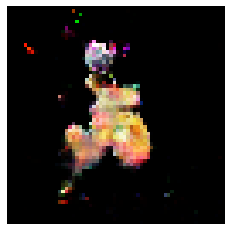

epoch 742
0.23604270815849304 8.997795104980469


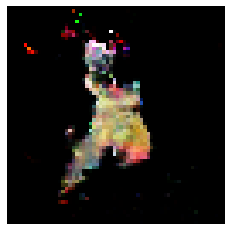

epoch 743
0.17985324561595917 10.529987335205078


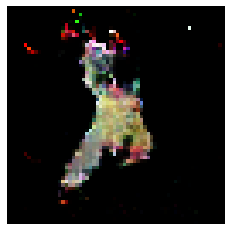

epoch 744
0.04331316985189915 8.01657485961914


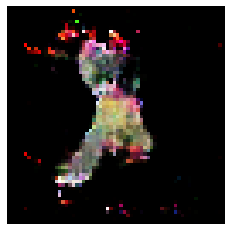

epoch 745
0.22975409030914307 9.32103157043457


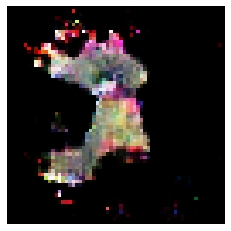

epoch 746
0.2478780411183834 9.146520614624023


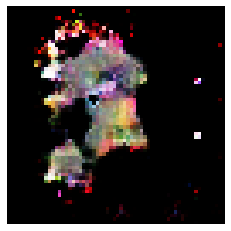

epoch 747
0.09739805851131678 11.998151779174805


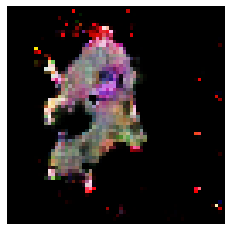

epoch 748
0.06355640757828951 8.156744003295898


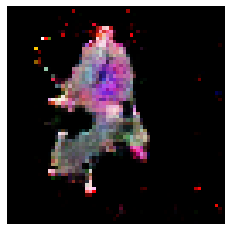

epoch 749
0.25934009440243244 8.975421905517578


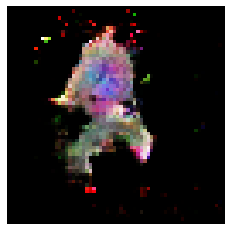

epoch 750
0.1972544207237661 9.291314125061035


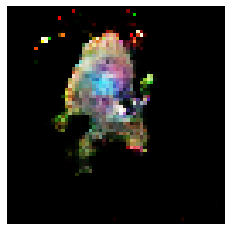

epoch 751
0.27298928052186966 7.249046325683594


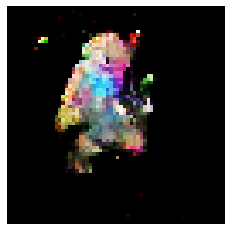

epoch 752
0.050210120389238 9.200313568115234


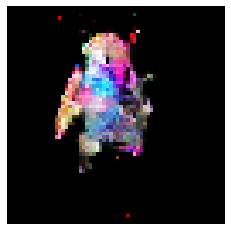

epoch 753
0.1456037051975727 8.04360580444336


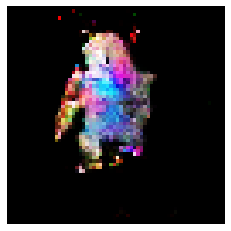

epoch 754
0.14263036847114563 10.064128875732422


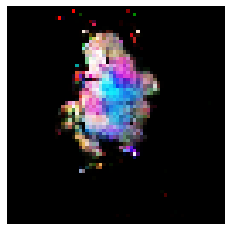

epoch 755
0.11570151895284653 8.64952564239502


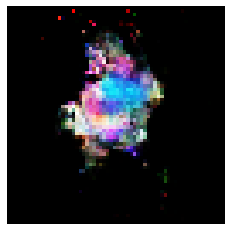

epoch 756
0.12746106833219528 7.838252067565918


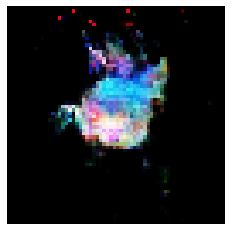

epoch 757
0.0693263839930296 8.29362678527832


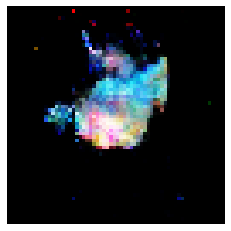

epoch 758
0.11849299923051149 8.552957534790039


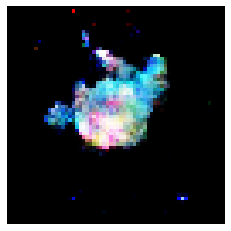

epoch 759
0.060934715904295444 8.456626892089844


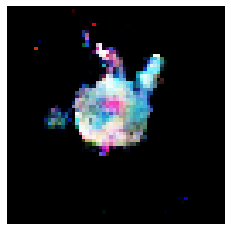

epoch 760
0.08847706764936447 8.298142433166504


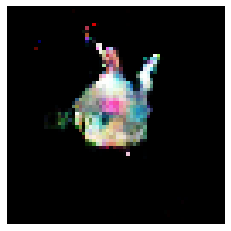

epoch 761
0.26522694528102875 8.766947746276855


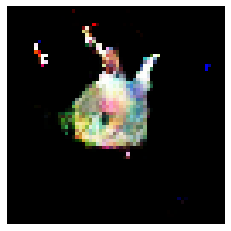

epoch 762
2.547969102859497 35.787906646728516


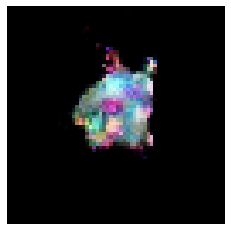

epoch 763
0.36503709852695465 10.331984519958496


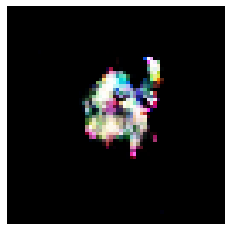

epoch 764
0.1662980616092682 12.122127532958984


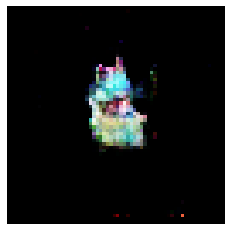

epoch 765
0.1394955813884735 9.815134048461914


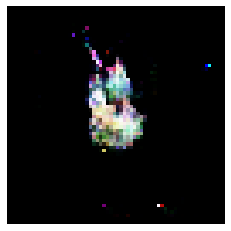

epoch 766
0.12823806703090668 7.943767547607422


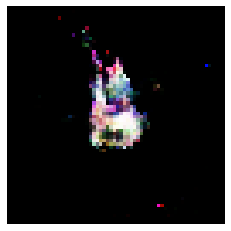

epoch 767
0.11329617723822594 8.61996841430664


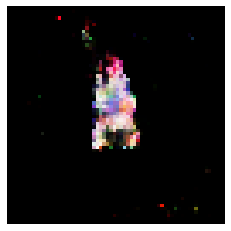

epoch 768
0.12031897902488708 9.404019355773926


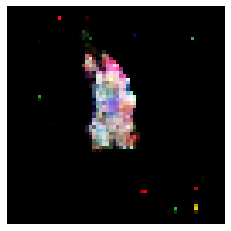

epoch 769
0.10472163185477257 8.781538963317871


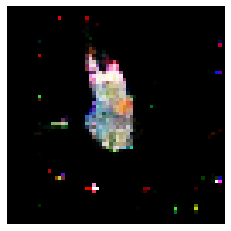

epoch 770
0.13290853798389435 9.826631546020508


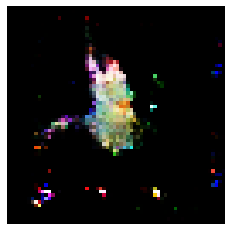

epoch 771
0.08641500025987625 9.543241500854492


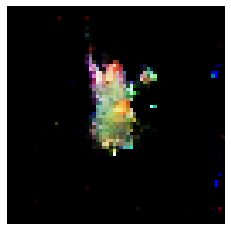

epoch 772
0.17419468611478806 8.974376678466797


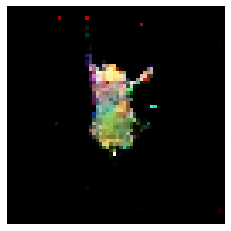

epoch 773
0.15278898924589157 8.474807739257812


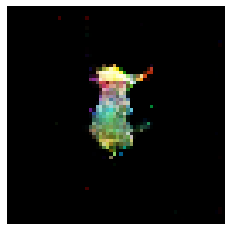

epoch 774
0.0939264576882124 8.521612167358398


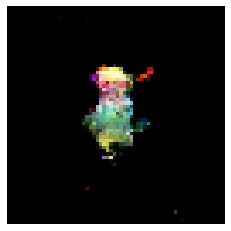

epoch 775
0.05034692399203777 7.777766227722168


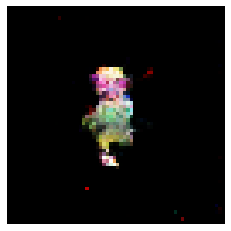

epoch 776
0.0752956485375762 8.910768508911133


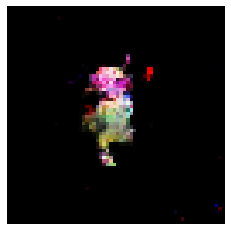

epoch 777
0.054366931319236755 9.35338020324707


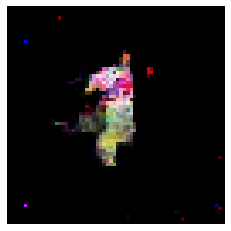

epoch 778
0.0701558394357562 8.519877433776855


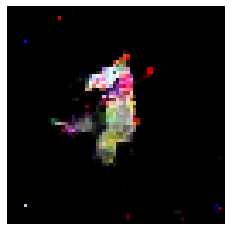

epoch 779
0.1078447625041008 9.996700286865234


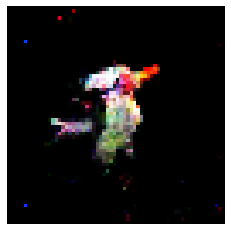

epoch 780
0.05940372124314308 7.861205101013184


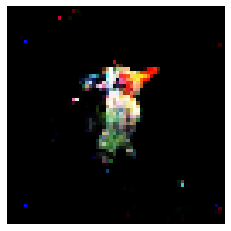

epoch 781
0.1432705596089363 9.938674926757812


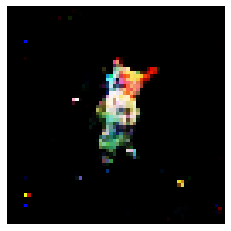

epoch 782
0.19248947501182556 11.217594146728516


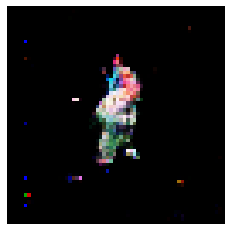

epoch 783
0.2176874577999115 12.37313461303711


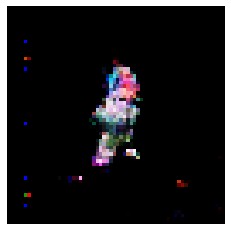

epoch 784
0.038259005756117404 9.862720489501953


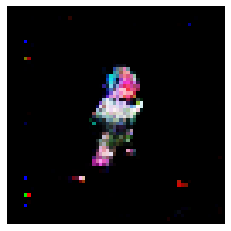

epoch 785
0.06343348324298859 8.547721862792969


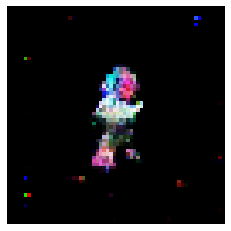

epoch 786
0.05498022958636284 8.744250297546387


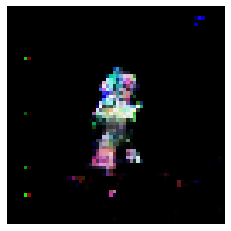

epoch 787
0.039557759184390306 10.434243202209473


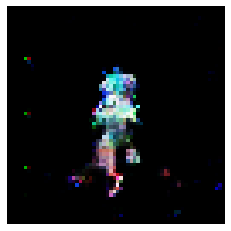

epoch 788
0.021358379162847996 10.184206008911133


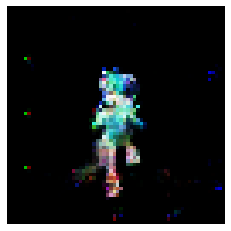

epoch 789
0.06141524948179722 8.372276306152344


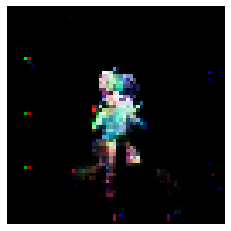

epoch 790
0.03104874026030302 9.714388847351074


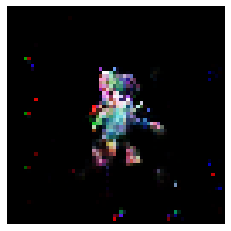

epoch 791
0.044342825189232826 8.517643928527832


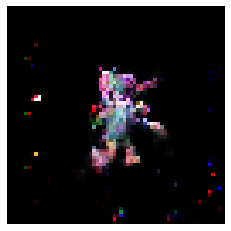

epoch 792
0.10170617699623108 8.590590476989746


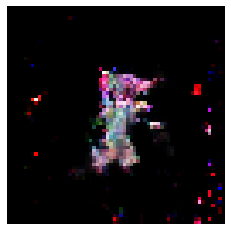

epoch 793
0.047522734850645065 10.168035507202148


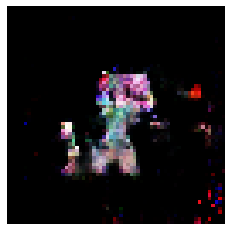

epoch 794
0.3049958199262619 11.733404159545898


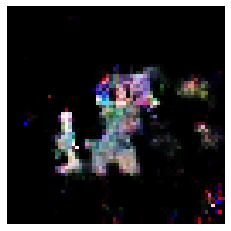

epoch 795
0.1011553667485714 11.994847297668457


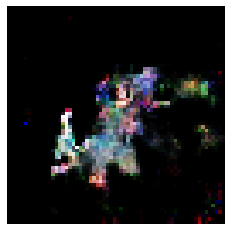

epoch 796
0.12276380881667137 9.510546684265137


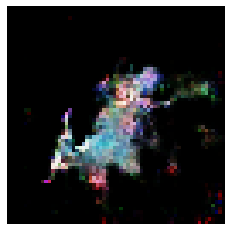

epoch 797
0.0351969450712204 11.026424407958984


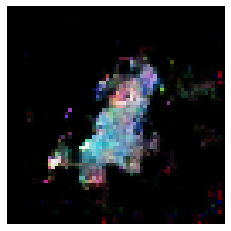

epoch 798
0.11362938955426216 10.217721939086914


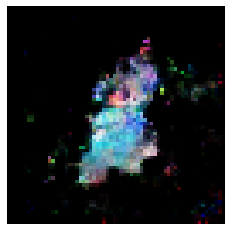

epoch 799
0.15924782305955887 10.71819019317627


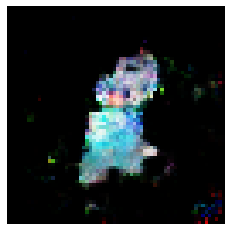

epoch 800
0.06844673119485378 9.456132888793945


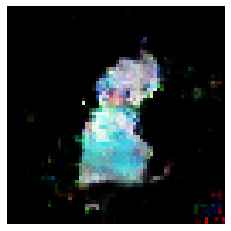

epoch 801
0.0907927337102592 10.53758716583252


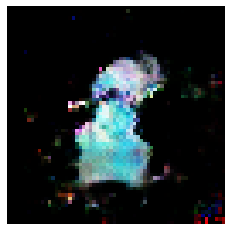

epoch 802
0.14365987665951252 14.523798942565918


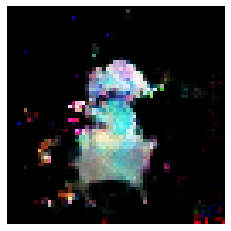

epoch 803
0.18225820362567902 18.468338012695312


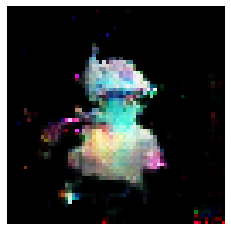

epoch 804
0.06545910943532363 13.83637809753418


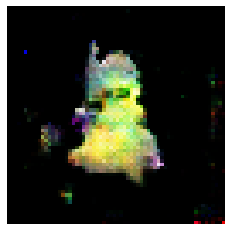

epoch 805
0.023645796813070774 9.204048156738281


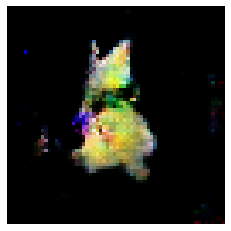

epoch 806
0.023113509640097618 8.645130157470703


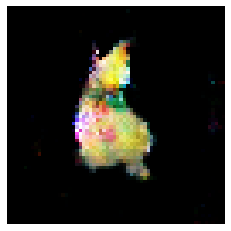

epoch 807
0.19940897449851036 14.924501419067383


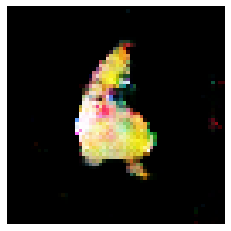

epoch 808
0.054493432864546776 9.986614227294922


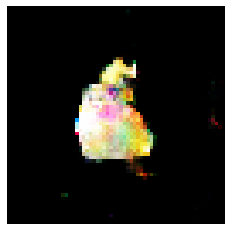

epoch 809
0.0464997012168169 11.732400894165039


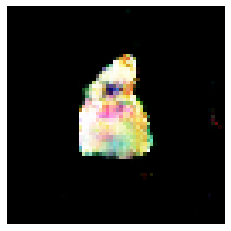

epoch 810
0.09939248859882355 8.548519134521484


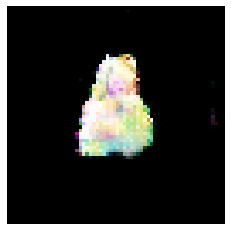

epoch 811
0.06865116953849792 7.760442733764648


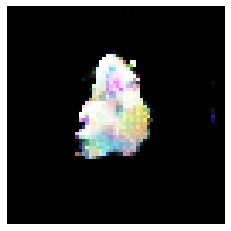

epoch 812
0.05433748476207256 9.00320816040039


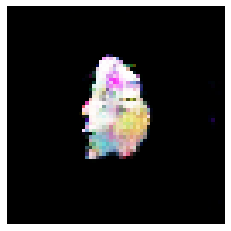

epoch 813
0.04786167712882161 8.212238311767578


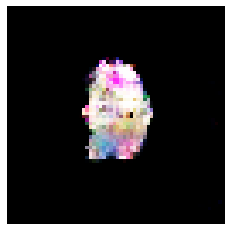

epoch 814
0.07238487899303436 10.3245267868042


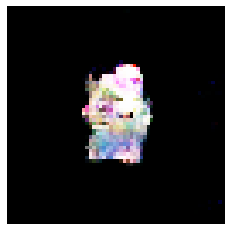

epoch 815
0.050204889848828316 10.610926628112793


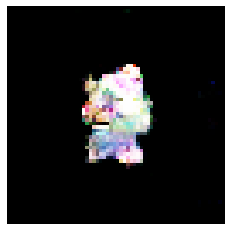

epoch 816
0.021451995708048344 8.956083297729492


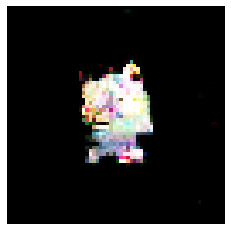

epoch 817
0.138022153172642 10.001398086547852


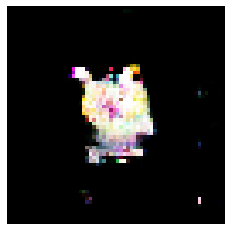

epoch 818
0.0033579740556888282 10.74548625946045


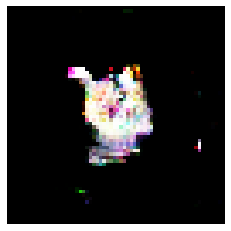

epoch 819
0.03573262970894575 10.523221969604492


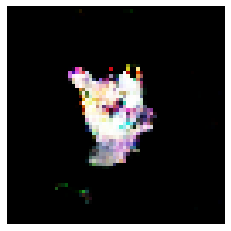

epoch 820
0.062579276971519 8.30217456817627


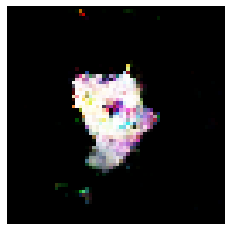

epoch 821
0.044374567456543446 11.007389068603516


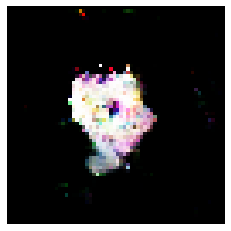

epoch 822
0.13288840651512146 9.647186279296875


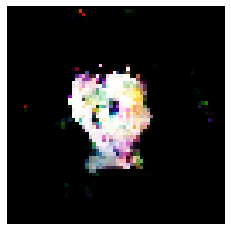

epoch 823
0.007891785819083452 9.26529312133789


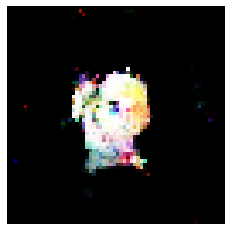

epoch 824
0.0908968411386013 11.156332969665527


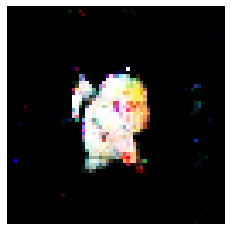

epoch 825
0.03500623628497124 10.18726921081543


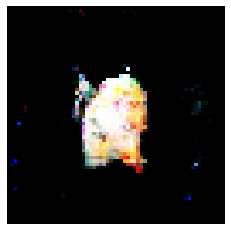

epoch 826
0.05088257044553757 10.79732894897461


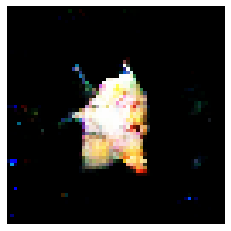

epoch 827
0.03343389555811882 9.26386833190918


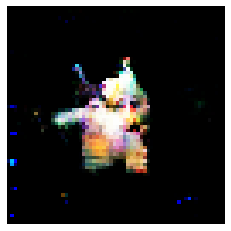

epoch 828
0.04999907873570919 8.535455703735352


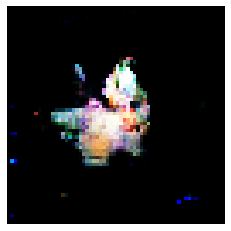

epoch 829
0.015761420130729675 9.183584213256836


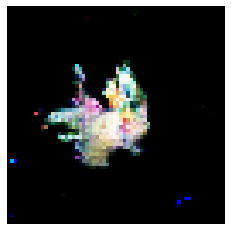

epoch 830
0.06780881062150002 9.76482105255127


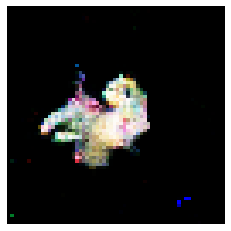

epoch 831
0.01896821614354849 8.400310516357422


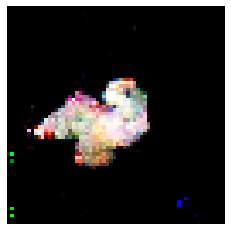

epoch 832
0.009624486556276679 11.055233001708984


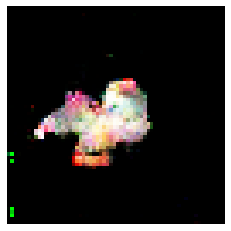

epoch 833
0.034842297434806824 9.240119934082031


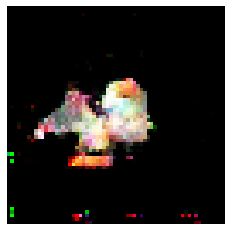

epoch 834
0.015194324543699622 10.922574043273926


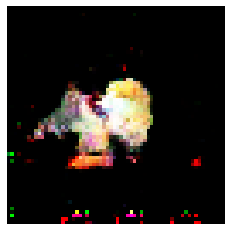

epoch 835
0.015687301522120833 9.5896577835083


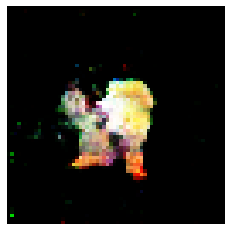

epoch 836
0.12684262171387672 16.879804611206055


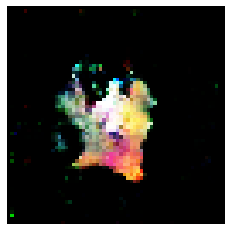

epoch 837
0.0480121411383152 12.896543502807617


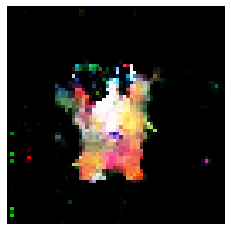

epoch 838
0.07255695015192032 10.807833671569824


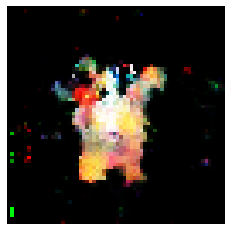

epoch 839
0.053735848516225815 10.723158836364746


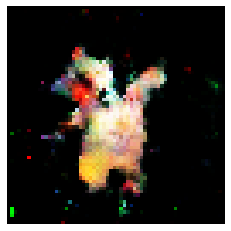

epoch 840
0.07590752467513084 10.909741401672363


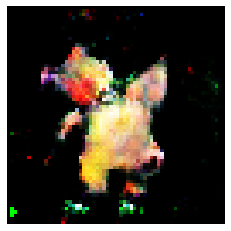

epoch 841
0.0766668647993356 9.487190246582031


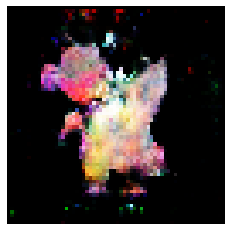

epoch 842
0.043170114047825336 10.797623634338379


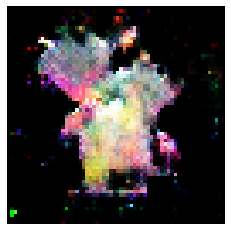

epoch 843
0.016279612493235618 11.542304039001465


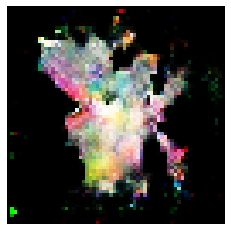

epoch 844
0.034411669126711786 10.56424331665039


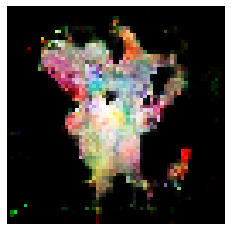

epoch 845
0.038307951763272285 10.69216537475586


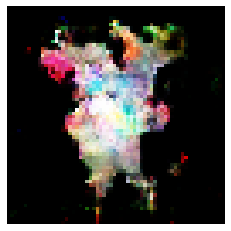

epoch 846
0.03474583476781845 13.635892868041992


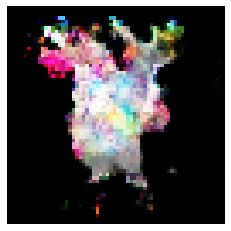

epoch 847
0.07028377056121826 14.331502914428711


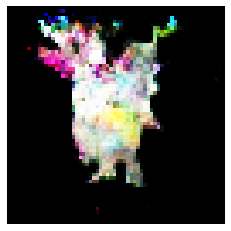

epoch 848
0.0918233242646238 14.233160018920898


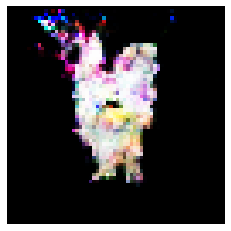

epoch 849
0.009113630512729287 10.604532241821289


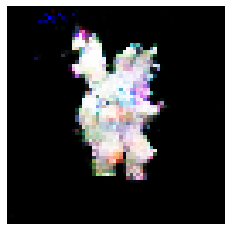

epoch 850
0.04180343076586723 9.246886253356934


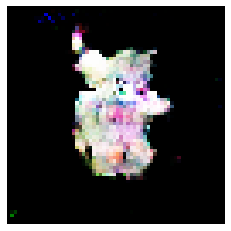

epoch 851
0.1529095098376274 13.76364517211914


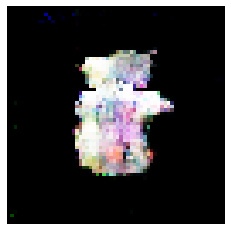

epoch 852
0.10925712017342448 9.208826065063477


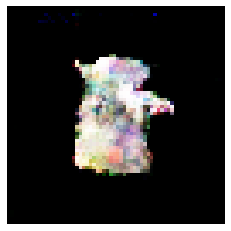

epoch 853
0.027975967153906822 11.772405624389648


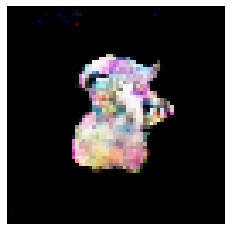

epoch 854
0.0937831923365593 11.72738265991211


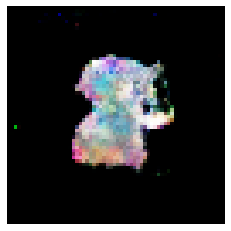

epoch 855
0.03339576721191406 10.01797866821289


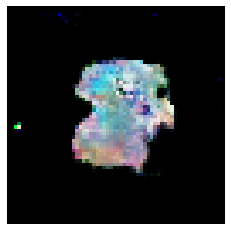

epoch 856
0.07451005047187209 9.69151496887207


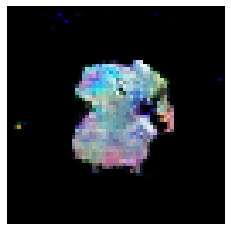

epoch 857
0.20338113808247726 20.762306213378906


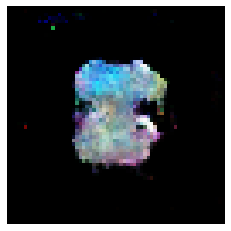

epoch 858
0.022912120446562767 10.744898796081543


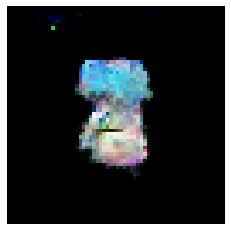

epoch 859
0.03062310628592968 10.733983993530273


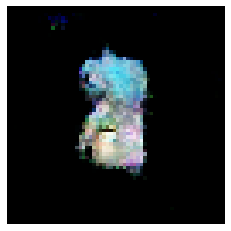

epoch 860
0.07435616850852966 9.147550582885742


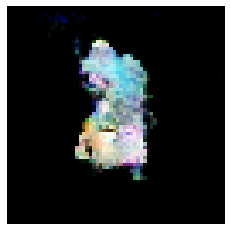

epoch 861
0.05451214872300625 10.42831802368164


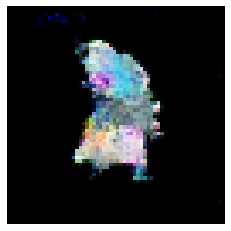

epoch 862
0.01763252168893814 9.673608779907227


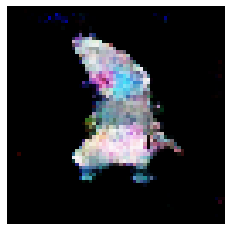

epoch 863
0.034831346943974495 9.617438316345215


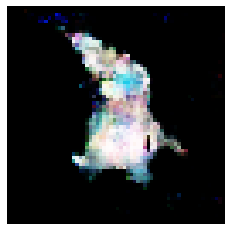

epoch 864
0.07380104577168822 7.523015022277832


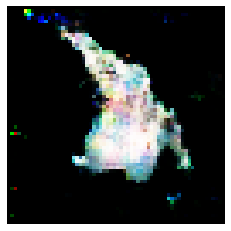

epoch 865
0.08879116550087929 9.305091857910156


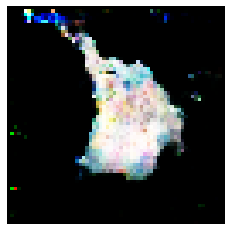

epoch 866
0.04939403012394905 11.650411605834961


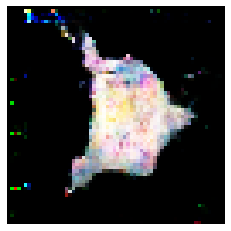

epoch 867
0.052547886967659 12.30186653137207


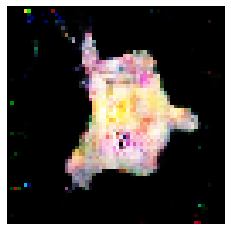

epoch 868
0.02402303460985422 11.21292495727539


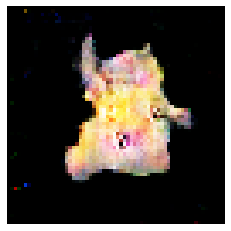

epoch 869
0.012018304070807062 12.059222221374512


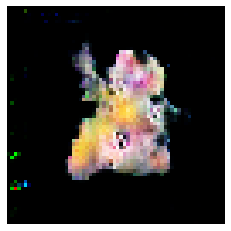

epoch 870
0.007737539010122418 9.677535057067871


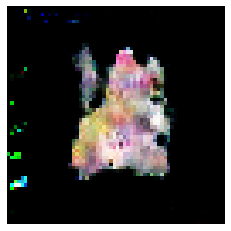

epoch 871
0.014790869783610106 9.740219116210938


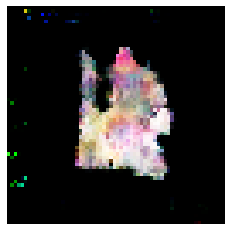

epoch 872
0.026050445390865207 9.406209945678711


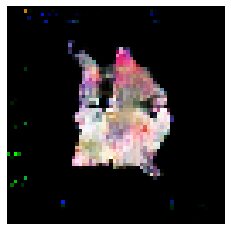

epoch 873
0.03384684701450169 11.53204345703125


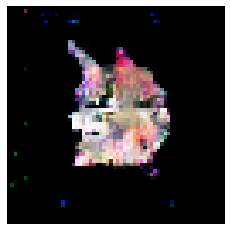

epoch 874
0.08636491745710373 13.429559707641602


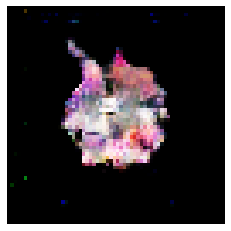

epoch 875
0.06772706657648087 10.551393508911133


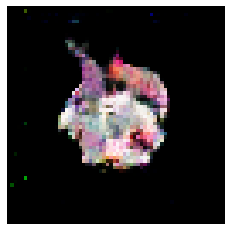

epoch 876
0.05456053838133812 10.459188461303711


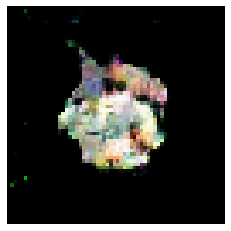

epoch 877
0.023084012791514397 10.675117492675781


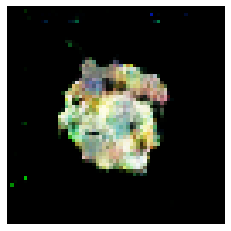

epoch 878
0.1333662010729313 18.382217407226562


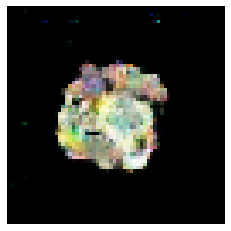

epoch 879
0.00818746560253203 9.761116027832031


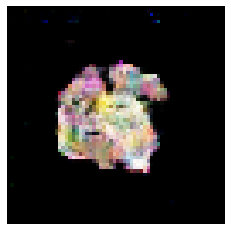

epoch 880
0.01854311814531684 11.085938453674316


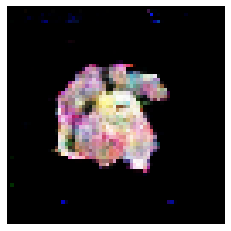

epoch 881
0.05867712013423443 14.685990333557129


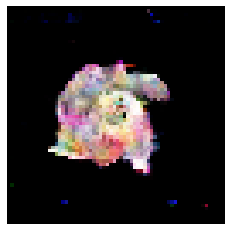

epoch 882
0.0022694289800710976 9.980744361877441


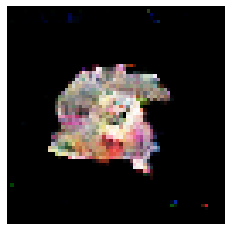

epoch 883
0.01567757735028863 11.173534393310547


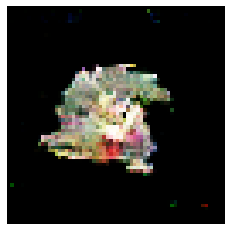

epoch 884
0.010791555978357792 11.21251392364502


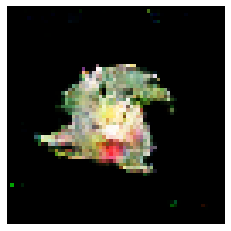

epoch 885
0.02490012209455017 11.87130355834961


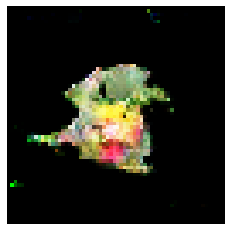

epoch 886
0.019533480517566204 12.434131622314453


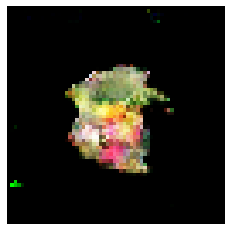

epoch 887
0.01030384423211217 11.563994407653809


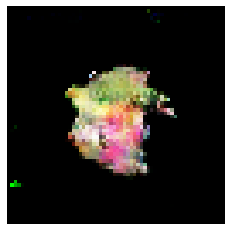

epoch 888
0.05020479531958699 11.117973327636719


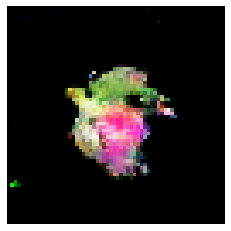

epoch 889
0.015476514585316181 11.234506607055664


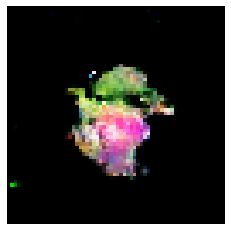

epoch 890
0.0022429163800552487 10.72589111328125


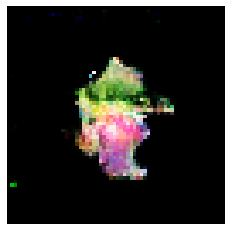

epoch 891
0.018302896060049534 14.014142990112305


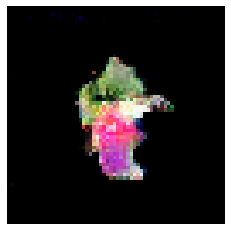

epoch 892
0.05660043843090534 10.963226318359375


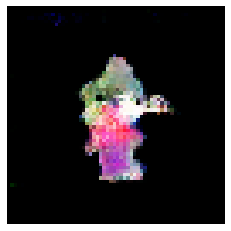

epoch 893
0.05756775662302971 9.952569961547852


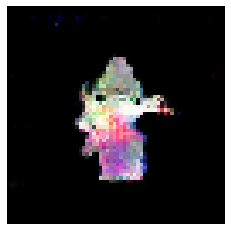

epoch 894
0.04809225909411907 10.057174682617188


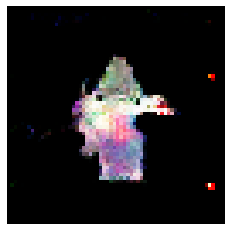

epoch 895
32.6802864074707 39.321998596191406


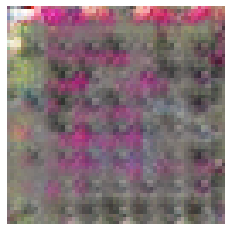

epoch 896
3.23958283662796 83.48817443847656


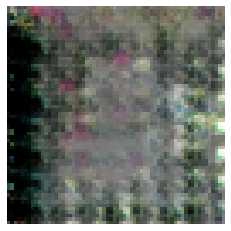

epoch 897
0.3404727131128311 29.472055435180664


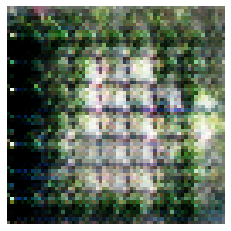

epoch 898
1.0517389178276062 28.73836898803711


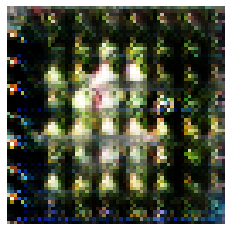

epoch 899
0.7171788774430752 27.86223602294922


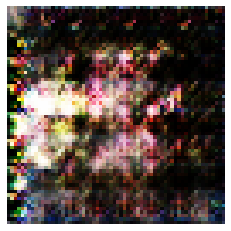

epoch 900
0.3492535501718521 16.009170532226562


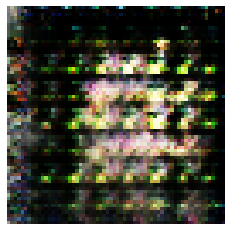

epoch 901
1.327755855294015 24.567344665527344


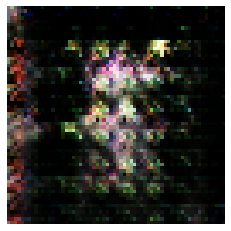

epoch 902
0.08049834414123325 20.638540267944336


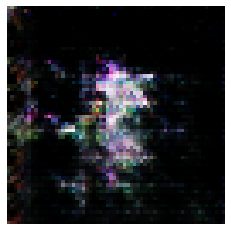

epoch 903
0.05896657286211848 13.432748794555664


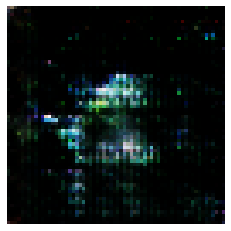

epoch 904
0.2163100764155388 15.788891792297363


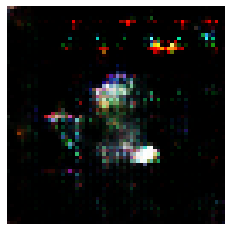

epoch 905
0.2701829522848129 19.547395706176758


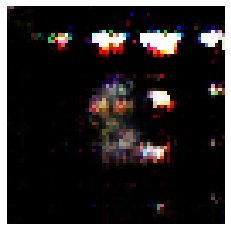

epoch 906
0.2998752072453499 21.087413787841797


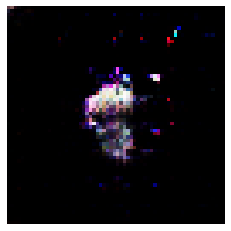

epoch 907
0.037337182089686394 10.181167602539062


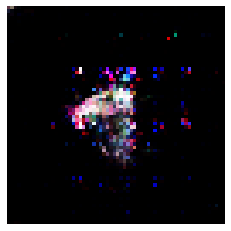

epoch 908
0.10721312835812569 11.284460067749023


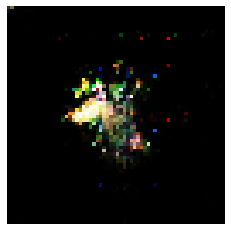

epoch 909
0.03901073522865772 10.753470420837402


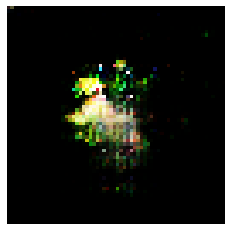

epoch 910
0.13689161115325987 11.619041442871094


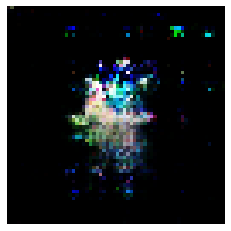

epoch 911
0.1502735260874033 10.447149276733398


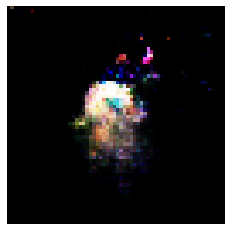

epoch 912
0.07870636321604252 11.355002403259277


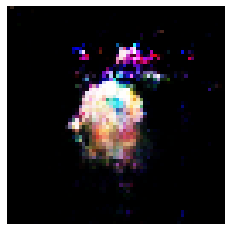

epoch 913
0.23535029171034694 12.178092956542969


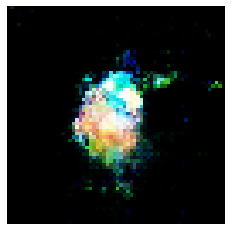

epoch 914
0.6729912385344505 26.59052848815918


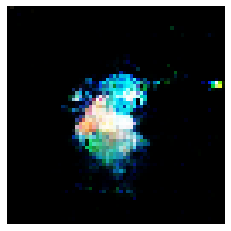

epoch 915
0.08467388153076172 9.948854446411133


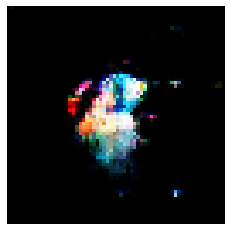

epoch 916
0.07490346394479275 9.574193954467773


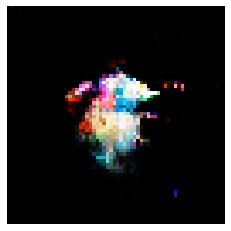

epoch 917
0.0992613285779953 9.285944938659668


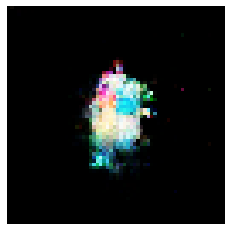

epoch 918
0.1464821957051754 10.025369644165039


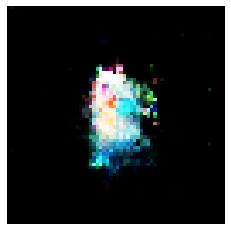

epoch 919
0.026702198199927807 10.565733909606934


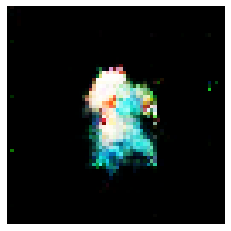

epoch 920
0.04964341502636671 8.87572193145752


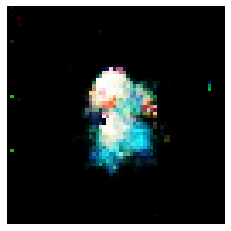

epoch 921
0.12778989039361477 7.470500946044922


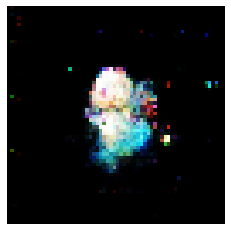

epoch 922
0.13158562034368515 10.596750259399414


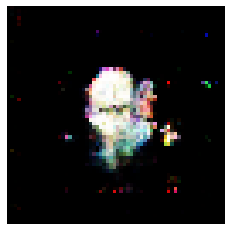

epoch 923
0.027706467546522617 10.933502197265625


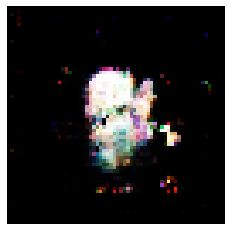

epoch 924
0.07137442882230971 15.664478302001953


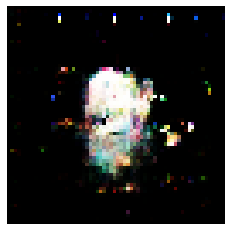

epoch 925
0.01148245669901371 11.388700485229492


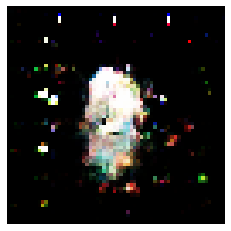

epoch 926
0.11790816951543093 12.643052101135254


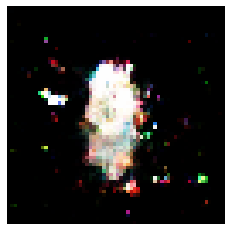

epoch 927
0.1065480038523674 9.499110221862793


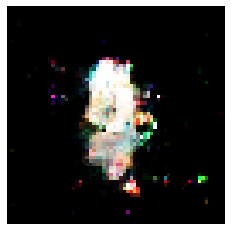

epoch 928
0.06407831516116858 9.578125


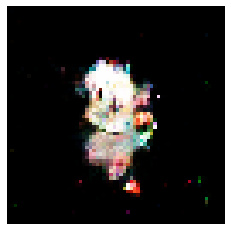

epoch 929
0.062033798545598984 10.080450057983398


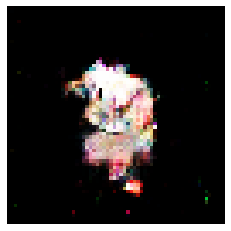

epoch 930
0.02474428666755557 10.153335571289062


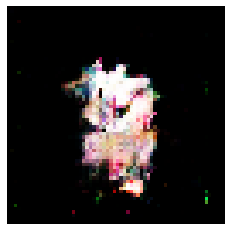

epoch 931
0.02853851846884936 11.198041915893555


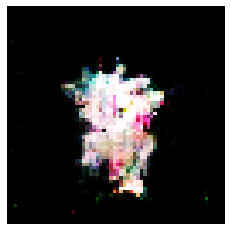

epoch 932
0.06857035122811794 10.274381637573242


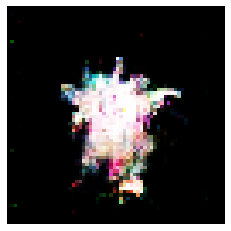

epoch 933
0.0754057988524437 11.995091438293457


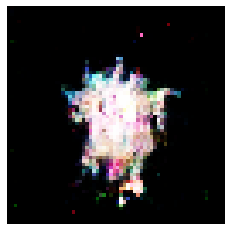

epoch 934
0.12517492100596428 13.750847816467285


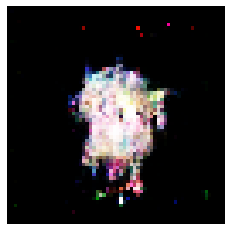

epoch 935
0.0966121107339859 11.085493087768555


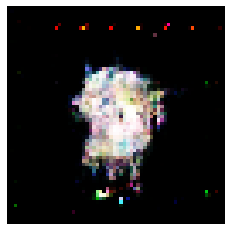

epoch 936
0.0872119851410389 11.726507186889648


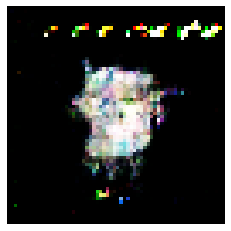

epoch 937
0.10828818008303642 10.830698013305664


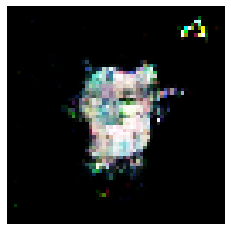

epoch 938
0.08000165596604347 10.057573318481445


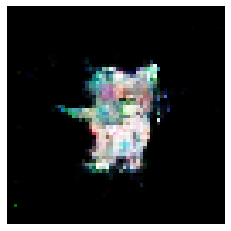

epoch 939
0.09535390138626099 9.947102546691895


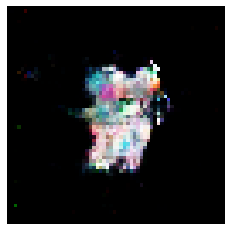

epoch 940
0.0922006405889988 10.902109146118164


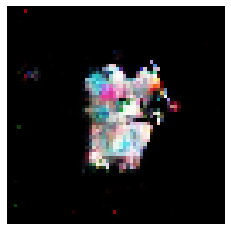

epoch 941
0.04307475220412016 8.054950714111328


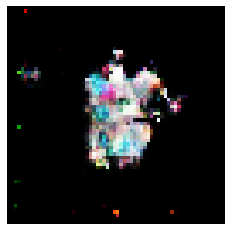

epoch 942
0.02580193299218081 12.531820297241211


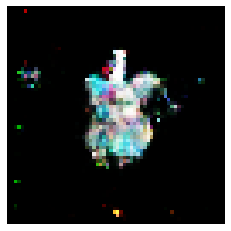

epoch 943
0.020422761561349034 9.339046478271484


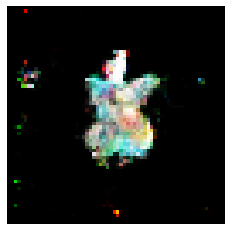

epoch 944
0.06709286570549011 9.533968925476074


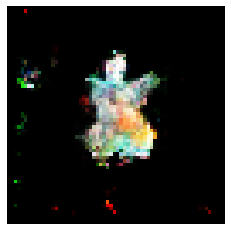

epoch 945
0.10845154896378517 13.725439071655273


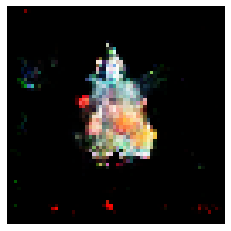

epoch 946
0.056871600449085236 10.510765075683594


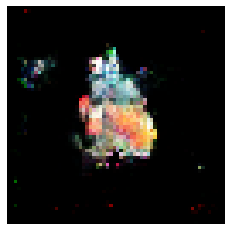

epoch 947
0.14408916980028152 11.502463340759277


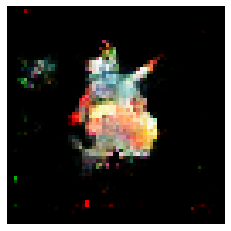

epoch 948
0.08025914430618286 8.543044090270996


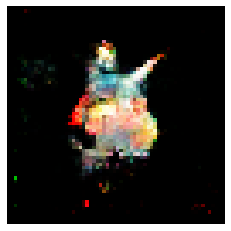

epoch 949
0.09554974734783173 10.334905624389648


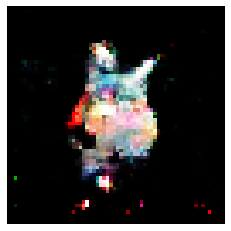

epoch 950
0.035347269382327795 10.668100357055664


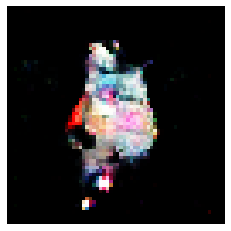

epoch 951
0.060576097574085 9.708478927612305


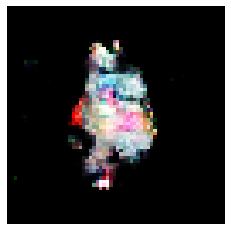

epoch 952
1.0722813606262207 7.550710678100586


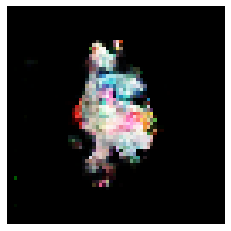

epoch 953
0.012684938730672002 11.820430755615234


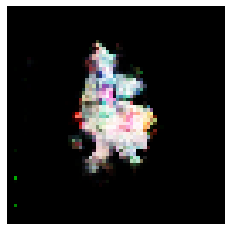

epoch 954
0.04290082864463329 9.462892532348633


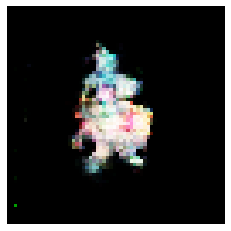

epoch 955
0.0868217688985169 11.760831832885742


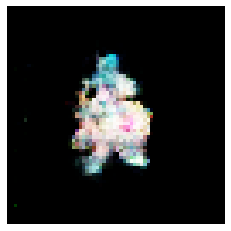

epoch 956
0.08217449858784676 10.261037826538086


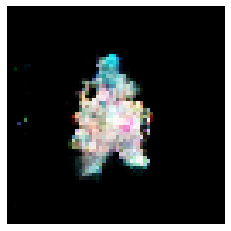

epoch 957
0.07819321984425187 8.825698852539062


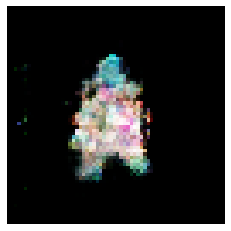

epoch 958
0.04869231814518571 10.20281982421875


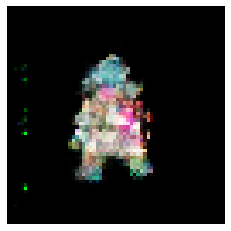

epoch 959
0.0876145251095295 9.428143501281738


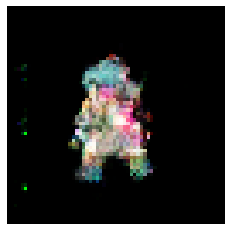

epoch 960
0.07763315550982952 9.331811904907227


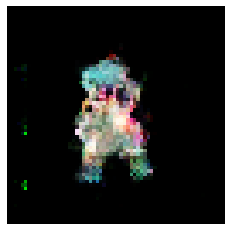

epoch 961
0.07617278397083282 9.682960510253906


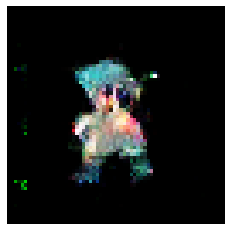

epoch 962
0.015779053792357445 10.504627227783203


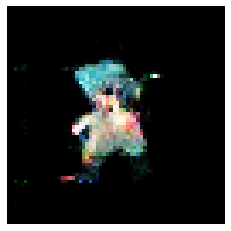

epoch 963
0.044577840715646744 9.743757247924805


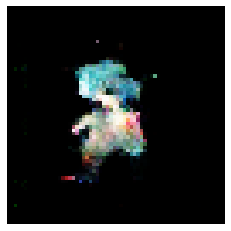

epoch 964
0.031223963014781475 9.693587303161621


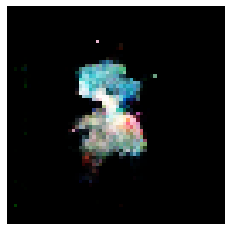

epoch 965
0.06135229952633381 10.091835021972656


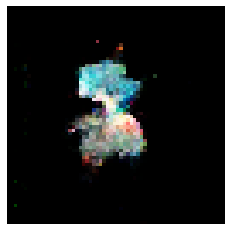

epoch 966
0.06345184333622456 8.971784591674805


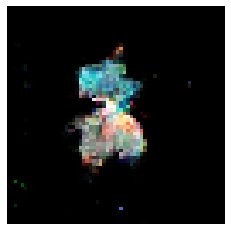

epoch 967
0.009430052246898413 9.302774429321289


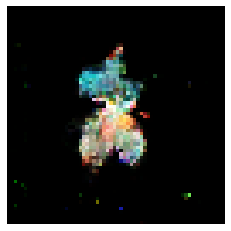

epoch 968
0.0021852352656424046 11.298568725585938


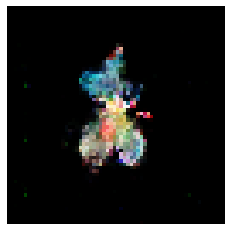

epoch 969
0.01612219726666808 11.734333992004395


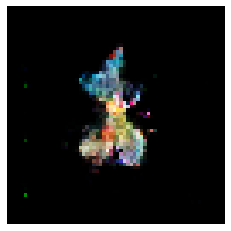

epoch 970
0.007862061378546059 9.102787017822266


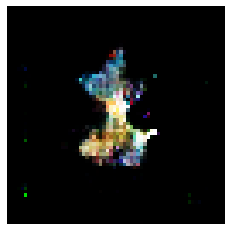

epoch 971
0.050131212919950485 8.946578025817871


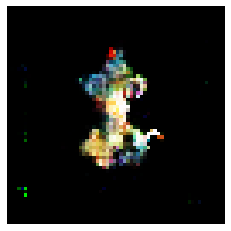

epoch 972
0.01794020365923643 9.99422836303711


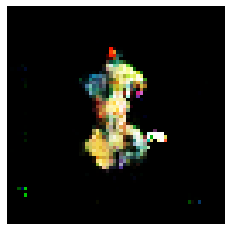

epoch 973
0.023459941614419222 9.316715240478516


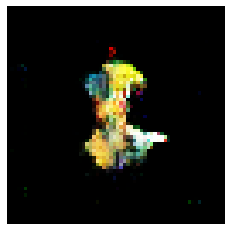

epoch 974
0.1447136476635933 15.697075843811035


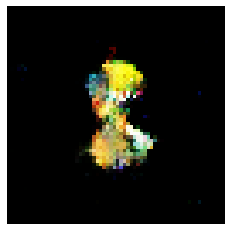

epoch 975
0.3371433690190315 10.283008575439453


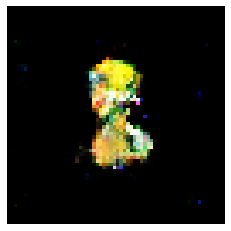

epoch 976
0.047673944383859634 12.348860740661621


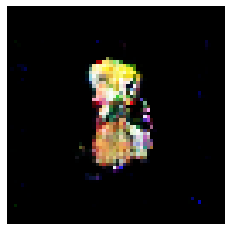

epoch 977
0.04373994655907154 9.411258697509766


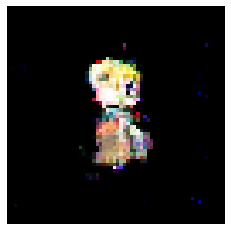

In [ ]:
train(x_train, n_epochs=1000, n_batch=128)

##評価

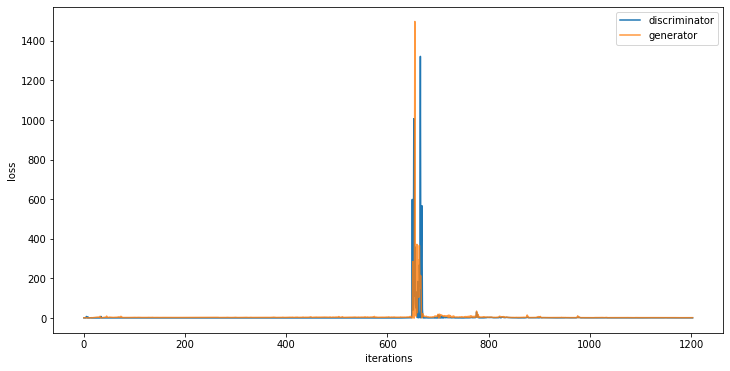

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(d_history, label='discriminator')
plt.plot(g_history, label='generator', alpha=0.8)
plt.legend()
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


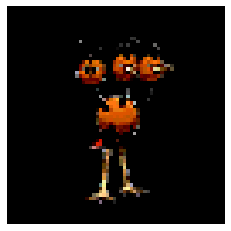

real image


In [ ]:
#リアル画像
plt.imshow(x_train[0])
plt.axis("off")
plt.show()
print('real image')

In [ ]:
##フェイク画像の表示を関数化

def make_fake_images():
  # 二つのノイズをサンプリング
  z_1 =  np.random.randn(latent_dim)
  z_2 =  np.random.randn(latent_dim)

  z_1 = z_1.reshape((1, latent_dim))
  z_2 = z_2.reshape((1, latent_dim))

# これらに対して、Gでフェイク画像を生成
  x_1 = g_4.predict(z_1)
  x_2 = g_4.predict(z_2)

# 画素値は[-1,1]にスケールされていたので、[0,1]に戻してプロット
# フェイク画像１
  plt.imshow((x_1[0,:,:,:]+1)/2)
  plt.axis("off")
  plt.show()
# フェイク画像２
  plt.imshow((x_2[0,:,:,:]+1)/2)
  plt.axis("off")
  plt.show()

###1st try

1st try epoch around 1500


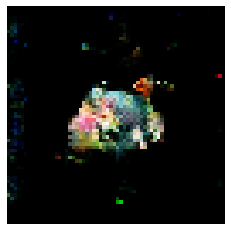

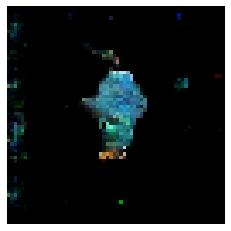

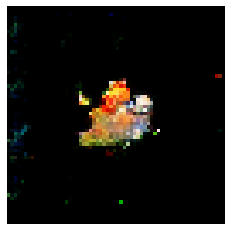

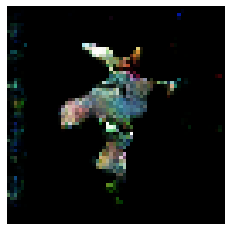

In [ ]:
print('1st try epoch around 1500')
make_fake_images()
make_fake_images()

1st try epoch around 1200


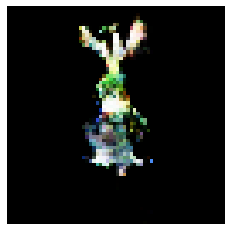

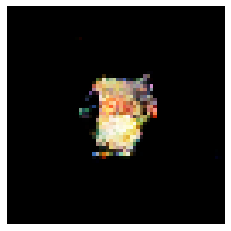

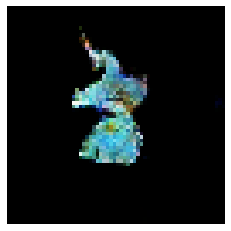

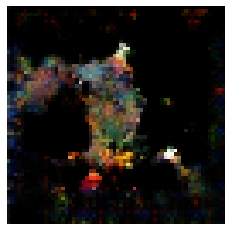

In [ ]:
print('1st try epoch around 1200')
make_fake_images()
make_fake_images()

1st try epoch around 900


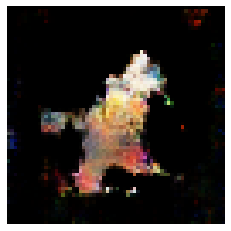

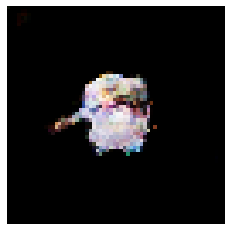

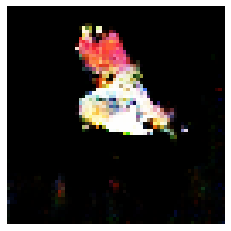

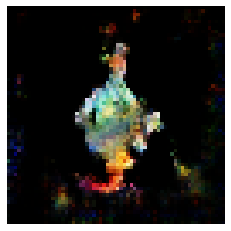

In [ ]:
print('1st try epoch around 900')
make_fake_images()
make_fake_images()

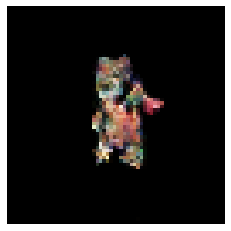

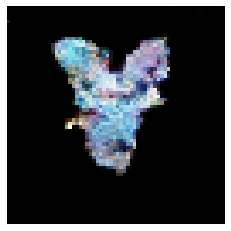

1st try epoch around 700


In [ ]:
make_fake_images()
print('1st try epoch around 700')

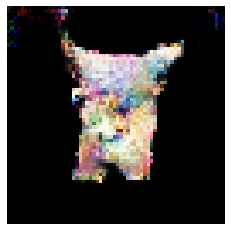

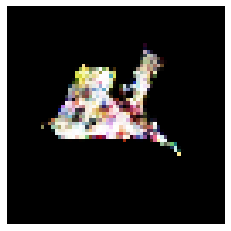

1st try epoch around 600


In [ ]:
make_fake_images()
print('1st try epoch around 600')

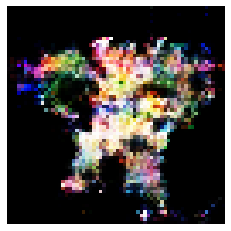

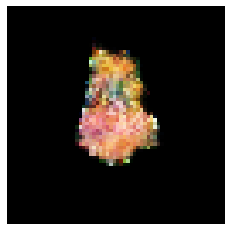

1st try epoch around 500


In [ ]:
make_fake_images()
print('1st try epoch around 500')

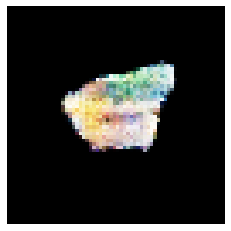

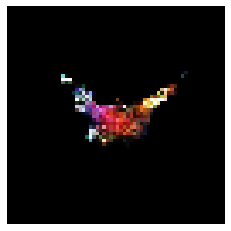

1st try epoch around 430


In [ ]:
make_fake_images()
print('1st try epoch around 430')

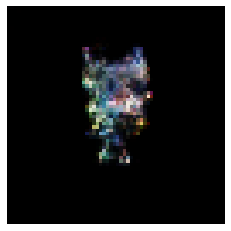

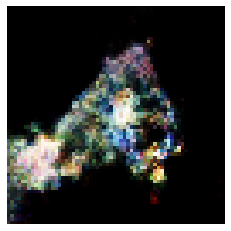

1st try epoch around 380


In [ ]:
make_fake_images()
print('1st try epoch around 380')

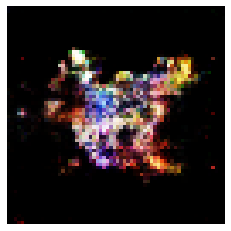

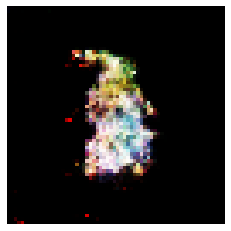

1st try epoch around 330


In [ ]:
make_fake_images()
print('1st try epoch around 330')

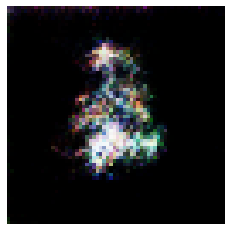

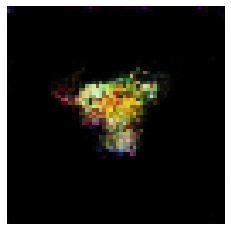

1st try epoch around 280


In [ ]:
make_fake_images()
print('1st try epoch around 280')

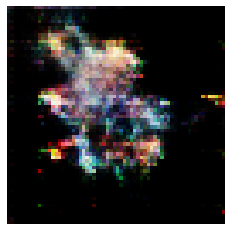

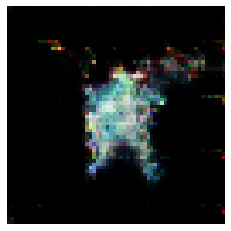

1st try epoch around 235


In [ ]:
make_fake_images()
print('1st try epoch around 235')

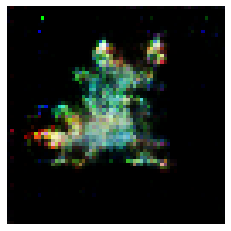

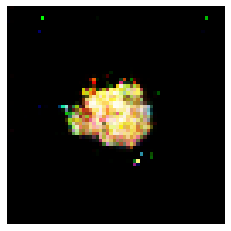

1st try epoch around 195


In [ ]:
make_fake_images()
print('1st try epoch around 195')

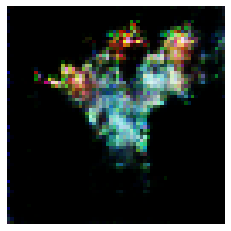

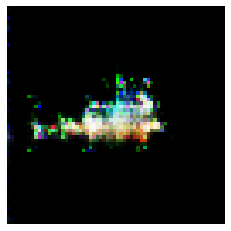

1st try epoch around 170


In [ ]:
make_fake_images()
print('1st try epoch around 170')

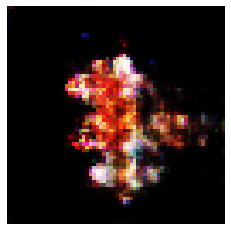

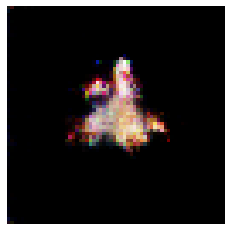

1st try epoch around 160


In [ ]:
make_fake_images()
print('1st try epoch around 160')

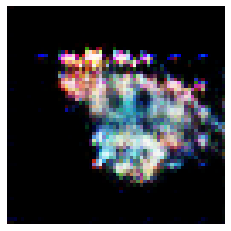

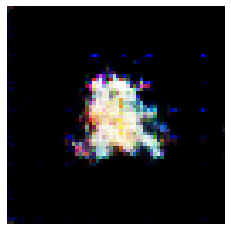

1st try epoch around 150


In [ ]:
make_fake_images()
print('1st try epoch around 150')

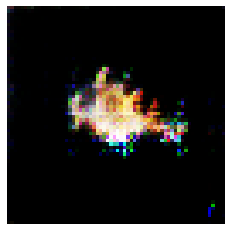

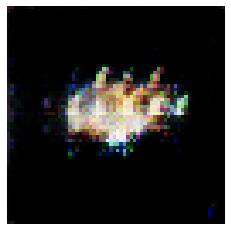

1st try epoch around 110


In [ ]:
make_fake_images()
print('1st try epoch around 110')

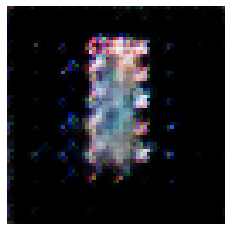

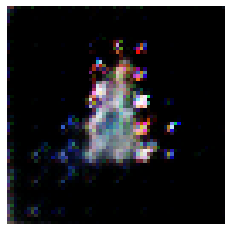

1st try epoch around 100


In [ ]:
make_fake_images()
print('1st try epoch around 100')

## まとめと考察

（なぜその問題を選んだのかの理由（モチベーション）、結果のまとめと議論、どこをがんばったか、これまで学んだことの何が役立ったか、この問題をもっとうまく解くために今後自分が勉強しなければならないことは何か、）

###課題設定

前回の第２回レポートでポケモンの画像を生成する課題を選択したが、シルエットがそれらしい画像を生成することには成功したが、なかなかはっきりとポケモンらしい画像を生成することができなかったため、手法を変えて挑戦を試みた。

###コード、アルゴリズムについて
PGGANと呼ばれるアルゴリズムを参考に実装してみた。DCGANでは難しい解像度の高い画像を生成するために解像度の低い画像から順にstep by stepで生成していく手法である。

今回は解像度の低い画像から順に生成していくことと、重みを共有したレイヤーを使用するということを採用した。まず、重みの共有だが、変数として層を作成することで、functional APIによって多出力モデルのように同じ畳み込み層を活用できるようにした。それらを(8,8,3),(16,16,3),(32,32,3),(64,64,3)を出力、もしくは入力する生成器と識別器をそれぞれ作成した。この時、生成器の畳み込み層は重みを共有している。そして、訓練の時にはそれらを順番に学習していくように実装した。

###結果と考察

評価の1st tryを見ると、ポケモンらしきなにかがいい具合に生成されているように見える。後ろ姿くらいの荒さだ。第２回課題のポケモンはドット絵にモザイクをかけたような、ポケモン緑と赤くらいの荒さだったが、今回はゲームボーイのポケモンリーフグリーンとファイアレッドくらいの見た目に成長したのではないかと思う。

着目する点としては、前回は奇跡の1枚が数枚あり、鳥らしきポケモンが一番うまくいっていた程度であったが、今回は多種多様な見た目をしたポケモンらしき画像が生成することができている点である。ウサギらしきもの、ネコらしきもの、悪魔っぽいもの、蝶々っぽいものなどなど。これは訓練画像のポケモンらしさを上手い具合に抽象表現として獲得できているということだと考えることができる。これはDCGANではあまりうまくできていなかったことなので、今回のPGGANもどきは実装成功と言えるのではないか。

ただその一方で、ポケモンぽくはあるが、はっきりとしたみためを持たせることができる生成器を作ることはできなかった。特に目がある画像は1枚程度しか見かけなかった。

・どこを頑張ったか

あまり期間がない中で、PGGANの実装を一番頑張った。ソースコードを見ても、大まかに大事なところはわかるが、どこを切り取れば良いのかがわからなかったため、図を見てそれに近くなるようにコーディングをした。そのため元論文とは少々違う実装になったように思う。

・これまで学んだことの何が役立ったか

GANに対する理解力と設計力と実装力である。その３点ができているからこそなんとなくという感覚でも理解して、設計して、実装して、画像の生成までたどり着くことができた。特に実装力はこの１年で急成長した。

・この問題をもっとうまく解くために今後自分が勉強しなければならないことは何か

他のGANの種類をまず知る必要がある。DCGANの上位互換を探して、１番はじめに目についたPGGANを選んだが、類似の手法はもっとたくさんあるはずであり、それらを知ることがより良い画像を生成することにつながるはずである。
また、PGGANの本来の実装をもう少し読み込む必要がある。今回は見様見真似で実装してしまったので、実装できたことに満足せずに、より良い実装を探究する必要がある。また、GANのモデル部分はあまり変更しなかったため、もっと自由にモデル設計をしてみたい。

ぜひ今度時間がある時によりリアルなポケモンの画像が生成できるようなGANを作ってみたいと思う。

##参考文献

元論文：
Tero Karras, Timo Aila, Samuli Laine, Jaakko Lehtinen, 2017,"Progressive Growing of GANs for Improved Quality, Stability, and Variation"
https://arxiv.org/pdf/1710.10196.pdf

Github:

https://github.com/tkarras/progressive_growing_of_gans/blob/master/networks.py

PGGANについての解説：

http://www.thothchildren.com/chapter/5b3e27ba103f2f31687077c8

共有レイヤーについては以下サイトを参考に。

https://blog.shikoan.com/keras-change-inputs-on-shared-layer/

